# Analysis of f$_{NL}$ with DESI LRGs

This notebook will include snippets regardin the log-normal mocks for the DESI fNL project.

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import sys
import os

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import fitsio as ft
import healpy as hp
from glob import glob
from time import time


from scipy.optimize import minimize
import pandas as pd

HOME = os.getenv('HOME')
print(f'running on {HOME}')
sys.path.append(f'{HOME}/github/LSSutils')
sys.path.append(f'{HOME}/github/sysnetdev')
import sysnet.sources as src

from lssutils.dataviz import setup_color, add_locators
from lssutils.utils import (histogram_cell, maps_dr9, make_hp,
                            chi2_fn, get_chi2pdf, get_inv, hpix2radec, shiftra)
from lssutils.io import (read_nbmocks, read_nnbar, read_clx, read_clxmocks, 
                         read_clmocks, read_window, read_window, read_chain)
from lssutils.theory.cell import (dNdz_model, init_sample, SurveySpectrum, Spectrum)
from lssutils.extrn.mcmc import Posterior
from lssutils.extrn import corner
from lssutils.stats.window import WindowSHT
from lssutils.stats.pcc import pcc

running on /users/PHS0336/medirz90


In [4]:
%matplotlib inline

In [5]:
# make plots look nicer
setup_color()

## Cleaned data
First we prepare the data into `hpix`, `features`, `label`, and `fracgood`.

Text(0, 0.5, 'sin(DEC [deg])')

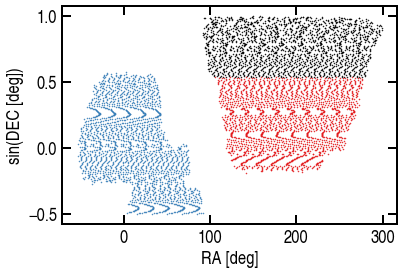

In [6]:
for r in ['bmzls', 'ndecals', 'sdecals']:
    
    table = f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_{r}_256.fits'
    dt = ft.read(table)
    
    ra, dec = hpix2radec(256, dt['hpix'])
    plt.scatter(shiftra(ra[::50]), np.sin(np.radians(dec[::50])), 1, marker='.')
    
plt.xlabel('RA [deg]')
plt.ylabel('sin(DEC [deg])')

Now, let's combine BASS/MzLS with DECaLS North into NGC

In [23]:
bmzls = ft.read('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_bmzls_256.fits')
ndecals = ft.read('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_ndecals_256.fits')

common = np.intersect1d(bmzls['hpix'], ndecals['hpix'])
ngc = np.concatenate([bmzls, ndecals])

mask_comm = np.in1d(ngc['hpix'], common)
ngc_comm = ngc[mask_comm]
ngc_comm = np.sort(ngc_comm, order='hpix')
commons = np.zeros(common.size, dtype=ngc_comm.dtype)

for key in commons.dtype.names:
    
    if key=='hpix':
        commons[key] = ngc_comm[key][:-1:2]
    elif key in ['label', 'fracgood']:
        commons[key] = (ngc_comm[key][:-1:2]+ngc_comm[key][1::2])
    elif key=='features':
        commons[key] = (ngc_comm[key][:-1:2]+ngc_comm[key][1::2]) / 2.0
    else:
        print(key)
        
ngc_unique = ngc[~mask_comm]
combined = np.concatenate([ngc_unique, commons])
assert ngc.size ==2*commons.size+ngc_unique.size        

ft.write('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_ngc_256.fits', combined)

Combine NGC and DECaLS S into desi

In [6]:
ngc = ft.read('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_ngc_256.fits')
sdecals = ft.read('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_sdecals_256.fits')

common = np.intersect1d(sdecals['hpix'], ngc['hpix'])
assert len(common) == 0
desi = np.concatenate([ngc, sdecals])

ft.write('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_desi_256.fits', desi)

In [7]:
ls /fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/ -altr

total 98577
drwxr-xr-x+ 6 medirz90 PHS0336     4096 Dec  2 16:38 ../
-rw-rw-r--+ 1 medirz90 PHS0336 12553920 Feb 10 19:21 nlrg_features_bmzls_256.fits
-rw-rw-r--+ 1 medirz90 PHS0336 14152320 Feb 10 19:21 nlrg_features_ndecals_256.fits
-rw-rw-r--+ 1 medirz90 PHS0336 14019840 Feb 10 19:21 nlrg_features_sdecals_256.fits
-rw-rw-r--+ 1 medirz90 PHS0336 26637120 Feb 10 22:10 nlrg_features_ngc_256.fits
drwxrwxr-x+ 2 medirz90 PHS0336     4096 Feb 11 11:52 ./
-rw-rw-r--+ 1 medirz90 PHS0336 40648320 Feb 11 11:52 nlrg_features_desi_256.fits


In [5]:
desi = ft.read('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_desi_256.fits')

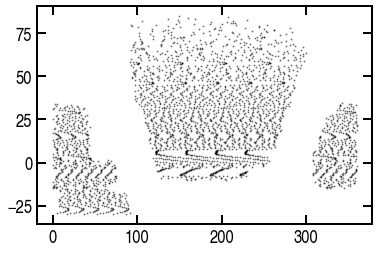

In [6]:
plt.scatter(*hpix2radec(256, desi['hpix'][::100]), 1, alpha=0.4)

## Bin C$_{\ell}$

In [6]:
def bin_clmock(fnl, survey):    
    #ell_edges = np.array([2] + [10*i for i in range(1,10)] + [100+i*20 for i in range(5)] + [200+i*50 for i in range(3)])
    ell_edges = np.array([2, 6, 10, 14, 18, 22, 26] \
                       + [10*i for i in range(3,10)] \
                       + [100+i*20 for i in range(5)] \
                       + [200+i*50 for i in range(3)])

    cl_mocks = np.load(f'/fs/ess/PHS0336/data/lognormal/v2/clustering/clmock_{fnl}_{survey}.npy')
    nmocks, lmax = cl_mocks.shape

    ell = np.arange(lmax)
    cl_mocks_binned = []
    for cl_i in cl_mocks:
        ell_bin, cl_bin = histogram_cell(ell, cl_i, bins=ell_edges)
        cl_mocks_binned.append(cl_bin)
    cl_mocks_binned = np.array(cl_mocks_binned)

    nbins = ell_edges.size-1
    assert (cl_mocks_binned.shape[1]==nbins)

    hf = (nmocks - 1.0)/(nmocks - nbins - 2.0)
    cl_cov = np.cov(cl_mocks_binned, rowvar=False)*hf #/ nmocks
    inv_cov = np.linalg.inv(cl_cov)
    print(f'Hartlap with #mocks ({nmocks}) and #bins ({nbins}): {hf:.2f}' )

    #fg, ax = plt.subplots(ncols=2, figsize=(12, 4))
    #ax[0].imshow(inv_cov, origin='lower')
    #ax[1].imshow(inv_cov.dot(cl_cov), origin='lower')

    np.savez(f'/fs/ess/PHS0336/data/lognormal/v2/clustering/clmock_{fnl}_{survey}_mean.npz',
         **{'el_edges':ell_edges, 'el_bin':ell_bin, 'cl':cl_mocks_binned.mean(axis=0)})

    np.savez(f'/fs/ess/PHS0336/data/lognormal/v2/clustering/clmock_{fnl}_{survey}_cov.npz',
         **{'el_edges':ell_edges, 'el_bin':ell_bin, 'clcov':cl_cov})

In [10]:
ls /fs/ess/PHS0336/data/lognormal/v2/clustering/cl*

/fs/ess/PHS0336/data/lognormal/v2/clustering/clmock_zero_bmzls.npy
/fs/ess/PHS0336/data/lognormal/v2/clustering/clmock_zero_desi.npy
/fs/ess/PHS0336/data/lognormal/v2/clustering/clmock_zero_fullsky.npy
/fs/ess/PHS0336/data/lognormal/v2/clustering/clmock_zero_ndecals.npy
/fs/ess/PHS0336/data/lognormal/v2/clustering/clmock_zero_ngc.npy
/fs/ess/PHS0336/data/lognormal/v2/clustering/clmock_zero_sdecals.npy


In [11]:
fnl = 'zero'
for survey in ['ndecals', 'sdecals',
               'ngc', 'desi', 'fullsky', 'bmzls']:

    bin_clmock(fnl, survey)
    print(f'{survey} done.')

Hartlap with #mocks (1000) and #bins (21): 1.02
ndecals done.
Hartlap with #mocks (1000) and #bins (21): 1.02
sdecals done.
Hartlap with #mocks (1000) and #bins (21): 1.02
ngc done.
Hartlap with #mocks (1000) and #bins (21): 1.02
desi done.
Hartlap with #mocks (1000) and #bins (21): 1.02
fullsky done.


## MCMC

Text(0.3, 0.2, 'Truth')

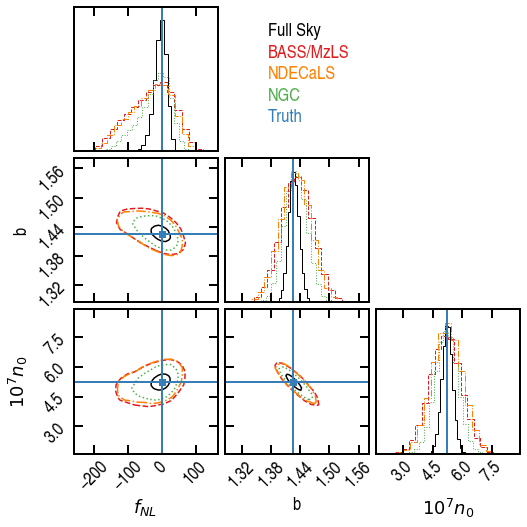

In [8]:
stats = {}
stats['Full Sky'], fs = read_chain('/fs/ess/PHS0336/data/lognormal/v1/mcmc/mcmc_lrg_zero_fullsky_noweight_steps10k_walkers50.npz')
stats['BMzLS'], bm = read_chain('/fs/ess/PHS0336/data/lognormal/v1/mcmc/mcmc_lrg_zero_bmzls_noweight_steps10k_walkers50.npz')
stats['NDECaLS'], nd = read_chain('/fs/ess/PHS0336/data/lognormal/v1/mcmc/mcmc_lrg_zero_ndecals_noweight_steps10k_walkers50.npz')
stats['Joint (BMzLS+NDECaLS)'], bnd = read_chain('/fs/ess/PHS0336/data/lognormal/v1/mcmc/mcmc_lrg_zero_bmzlsndecals_noweight_steps10k_walkers50.npz', ndim=5, iscale=[2, 4])
stats['NGC (BMzLS+NDECaLS)'], ngc = read_chain('/fs/ess/PHS0336/data/lognormal/v1/mcmc/mcmc_lrg_zero_ngc_noweight_steps10k_walkers50.npz')
stats['DESI'], desi = read_chain('/fs/ess/PHS0336/data/lognormal/v1/mcmc/mcmc_lrg_zero_desi_noweight_steps10k_walkers50.npz')
stats['Full Sky [scaled]'], fss = read_chain('/fs/ess/PHS0336/data/lognormal/v1/mcmc/mcmc_lrg_zero_fullskyscaled_noweight_steps10k_walkers50.npz')


kw = dict(plot_datapoints=False, truths=[0.0, 1.426, 5.24], truth_color='C2',
          labels=[r'$f_{NL}$', 'b', '$10^{7}n_{0}$'], plot_density=False,
          fill_contours=False, levels=[0.68, ])

fig = corner.corner(fs, color='C0', **kw)
corner.corner(bm, fig=fig, color='C1', contour_kwargs=dict(linestyles='--'), **kw)
corner.corner(nd, fig=fig, color='C3', contour_kwargs=dict(linestyles='-.'), **kw)
corner.corner(ngc, fig=fig, color='C4', contour_kwargs=dict(linestyles=':'), **kw)
# corner.corner(bnd, fig=fig, color='C5', contour_kwargs=dict(linestyles=':'), **kw)

ax = fig.get_axes()

ax[1].text(0.3, 0.8, 'Full Sky', color='C0', transform=ax[1].transAxes)
ax[1].text(0.3, 0.65, 'BASS/MzLS', color='C1', transform=ax[1].transAxes)
ax[1].text(0.3, 0.5, 'NDECaLS', color='C3', transform=ax[1].transAxes)
ax[1].text(0.3, 0.35, 'NGC', color='C4', transform=ax[1].transAxes)
#ax[1].text(0.3, 0.2, 'BMzLS+NDECaLS', color='C5', transform=ax[1].transAxes)
ax[1].text(0.3, 0.2, 'Truth', color='C2', transform=ax[1].transAxes)

# # fig.savefig('mcmc_mocks.pdf', bbox_inches='tight')

In [9]:
pstats = pd.DataFrame(stats,
                      index=['MAP [scipy]', 'MAP [chain]', 'Mean [chain]',
                             'Median [chain]', '16th', '84th']).T
pstats

MAP [scipy]  MAP [chain]  Mean [chain]  Median [chain]  \
Full Sky                 -0.102982    -0.169296     -4.481302       -2.834291   
BMzLS                     1.579499     1.533232    -32.400988      -25.483725   
NDECaLS                   1.712933     1.705552    -32.886055      -26.050876   
Joint (BMzLS+NDECaLS)     1.651002    -0.436883    -22.716550      -15.338130   
NGC (BMzLS+NDECaLS)       1.361792     0.927928    -21.946799      -14.882515   
DESI                      1.131549     0.899756    -15.141885       -9.217642   
Full Sky [scaled]        -0.354778    -0.839537    -32.747492      -24.366308   

                             16th       84th  
Full Sky               -22.820769  14.017492  
BMzLS                 -103.954325  33.208484  
NDECaLS               -100.598563  29.014995  
Joint (BMzLS+NDECaLS)  -74.659006  25.287960  
NGC (BMzLS+NDECaLS)    -70.083562  22.201480  
DESI                   -51.490068  19.807616  
Full Sky [scaled]      -96.384085  24.098743

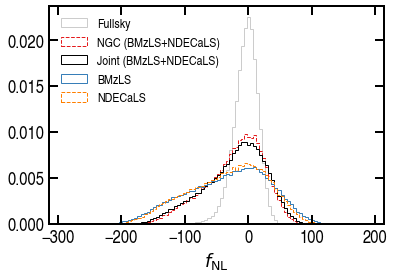

In [10]:
kw = dict(histtype='step', bins=100, range=(-290, 190), density=True)

plt.figure()#figsize=(10, 6))
plt.hist(fs[:, 0], alpha=0.2, **kw, label='Fullsky')
plt.hist(ngc[:, 0], **kw, label='NGC (BMzLS+NDECaLS)')
plt.hist(bnd[:, 0], color='k',ls='-', **kw, label='Joint (BMzLS+NDECaLS)')
plt.hist(bm[:, 0], **kw, ls='-', label='BMzLS')
plt.hist(nd[:, 0], **kw, label='NDECaLS')
plt.legend(loc=2)
_ = plt.xlabel(r'$f_{\rm NL}$')

Text(0.3, 0.5, 'Full Sky (scaled)')

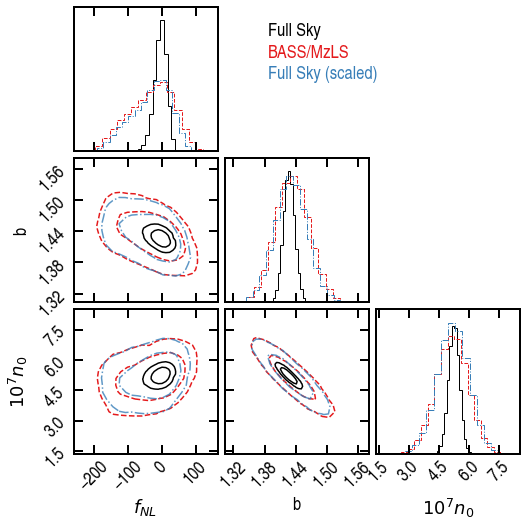

In [19]:
kw = dict(plot_datapoints=False, #truths=[0.0, 1.426, 5.24], truth_color='C2',
          labels=[r'$f_{NL}$', 'b', '$10^{7}n_{0}$'], plot_density=False,
          fill_contours=False, levels=[0.68, 0.95])

fig = corner.corner(fs, color='C0', **kw)
corner.corner(bm, fig=fig, color='C1', contour_kwargs=dict(linestyles='--'), **kw)
corner.corner(fss, fig=fig, color='C2', contour_kwargs=dict(linestyles='-.', alpha=0.8), **kw)
ax = fig.get_axes()

ax[1].text(0.3, 0.8, 'Full Sky', color='C0', transform=ax[1].transAxes)
ax[1].text(0.3, 0.65, 'BASS/MzLS', color='C1', transform=ax[1].transAxes)
ax[1].text(0.3, 0.5, 'Full Sky (scaled)', color='C2', transform=ax[1].transAxes)
#ax[1].text(0.3, 0.35, 'Truth', color='C2', transform=ax[1].transAxes)

# fig.savefig('mcmc_mocks.pdf', bbox_inches='tight')

Text(0.3, 0.5, 'Truth')

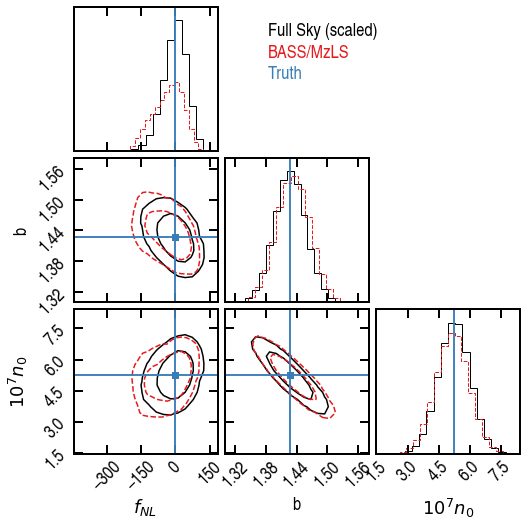

In [11]:
fs_ = fs.copy()
fs_m = fs_.mean(axis=0)
fs_ = fs_ - fs_m
fs_ /= np.sqrt(0.125)
fs_ += fs_m

kw = dict(plot_datapoints=False, truths=[0.0, 1.426, 5.24], truth_color='C2',
          labels=[r'$f_{NL}$', 'b', '$10^{7}n_{0}$'], plot_density=False,
          fill_contours=False, levels=[0.68, 0.95])

fig = corner.corner(fs_, color='C0', **kw)
corner.corner(bm, fig=fig, color='C1', contour_kwargs=dict(linestyles='--'), **kw)
ax = fig.get_axes()

ax[1].text(0.3, 0.8, 'Full Sky (scaled)', color='C0', transform=ax[1].transAxes)
ax[1].text(0.3, 0.65, 'BASS/MzLS', color='C1', transform=ax[1].transAxes)
ax[1].text(0.3, 0.5, 'Truth', color='C2', transform=ax[1].transAxes)

# fig.savefig('mcmc_mocks.pdf', bbox_inches='tight')

## Feature selection

In [21]:
fr = ft.read('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_bmzls_256.fits')['features']

In [22]:
maps_dr9 = ['ebv', 'nstar']\
            + [f'galdepth_{b}' for b in ['r', 'g', 'z']]\
            + [f'psfdepth_{b}' for b in ['r', 'g', 'z', 'w1', 'w2']] \
            + [f'psfsize_{b}' for b in ['r', 'g', 'z']]

In [23]:
ccf = np.corrcoef(fr, rowvar=False)
ccf.max(), ccf.min()

(1.0, -0.5124436766967613)

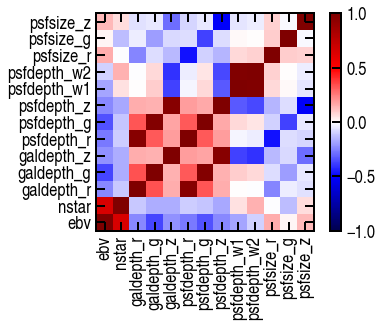

In [24]:
fg, ax = plt.subplots()

mp = ax.imshow(ccf, cmap='seismic', origin='lower', vmin=-1.0, vmax=1.0)
fg.colorbar(mp)

ax.set_xticks(np.arange(len(maps_dr9)))
ax.set_xticklabels(maps_dr9, rotation=90)
ax.set_yticks(np.arange(len(maps_dr9)))
_ = ax.set_yticklabels(maps_dr9)

In [6]:
model = src.LinearRegression(add_bias=True)

In [12]:
def run_rfe(filename):
 
    maps_dr9 = ['ebv', 'nstar']\
                + [f'galdepth_{b}' for b in ['r', 'g', 'z']]\
                + [f'psfdepth_{b}' for b in ['r', 'g', 'z', 'w1', 'w2']] \
                + [f'psfsize_{b}' for b in ['r', 'g', 'z']]

    dl = src.MyDataLoader(filename, 
                          do_kfold=True, seed=85)
    axes = []
    for i in range(5):
        fs = src.FeatureElimination(model, dl.load_data(-1, i))
        fs.run([j for j in range(13)])
        axes.append(fs.results['axes_to_keep'])


    #     fs.plot(labels=maps_dr9, cmap='seismic', vmin=0.99, vmax=1.01)
    
    weights = [[(1.+i)/len(axes_i) for i in range(len(axes_i))] for axes_i in axes]

    axes_ = []
    for axi in axes:
        for axj in axi:
            axes_.append(axj)

    weights_ = []
    for wt in weights:
        for wj in wt:
            weights_.append(wj)

    plt.hist(axes_, weights=weights_, bins=np.arange(13), align='left', width=0.8)
    plt.xticks(ticks=np.arange(13), labels=maps_dr9, rotation=90)
    plt.xlim(-1, 13)
    plt.ylim(0, 5.2)

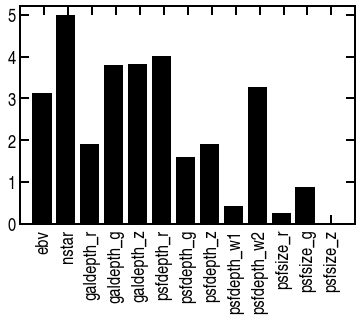

In [13]:
run_rfe('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_bmzls_256.fits')

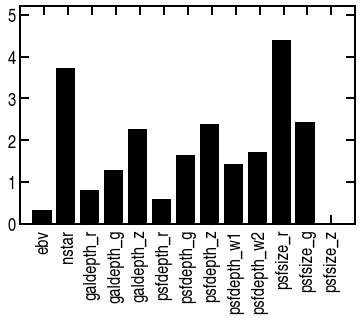

In [16]:
run_rfe('/fs/ess/PHS0336/data/lognormal/v0/tables/bmzls/nlrg-10-bmzls.fits')

In [23]:
maps_dr9 = ['ebv', 'nstar']\
            + [f'galdepth_{b}' for b in ['r', 'g', 'z']]\
            + [f'psfdepth_{b}' for b in ['r', 'g', 'z', 'w1', 'w2']] \
            + [f'psfsize_{b}' for b in ['r', 'g', 'z']]

In [40]:
r = 'bmzls'
def run_pcc(r):
    
    dt = ft.read(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_{r}_256.fits')
    pcc_d, = pcc(dt['features'], dt['label'], return_err=False)

    pcc_m = []
    for filename in glob(f'/fs/ess/PHS0336/data/lognormal/v0/tables/{r}/nlrg-*-{r}.fits')[:100]:
        mc = ft.read(filename)
        pcc_, = pcc(mc['features'], mc['label'], return_err=False)
        pcc_m.append(pcc_)
        
    plt.bar(np.arange(13), pcc_d, alpha=0.4)#, label='DR9 BMzLS')        
    for pcc_i in pcc_m:
        plt.plot(pcc_i, lw=1, alpha=0.2, ls='-', c='C1')
    # plt.xticks(ticks=np.arange(len(maps_dr9)), labels=maps_dr9, rotation=90)
    plt.ylabel('PCC')
    # plt.legend()
    _ = plt.xticks(ticks=np.arange(13), labels=maps_dr9, rotation=90)        

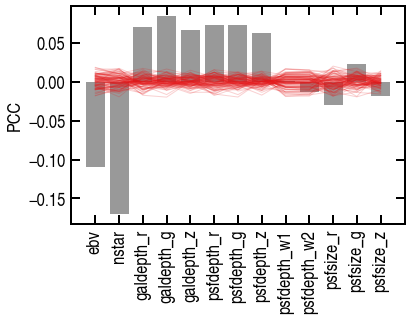

In [41]:
run_pcc(r)

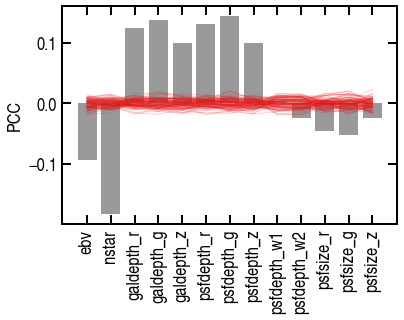

In [42]:
run_pcc('ndecals')

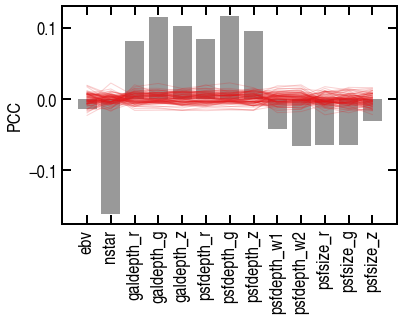

In [43]:
run_pcc('sdecals')

## Mean Density After Feature Selection

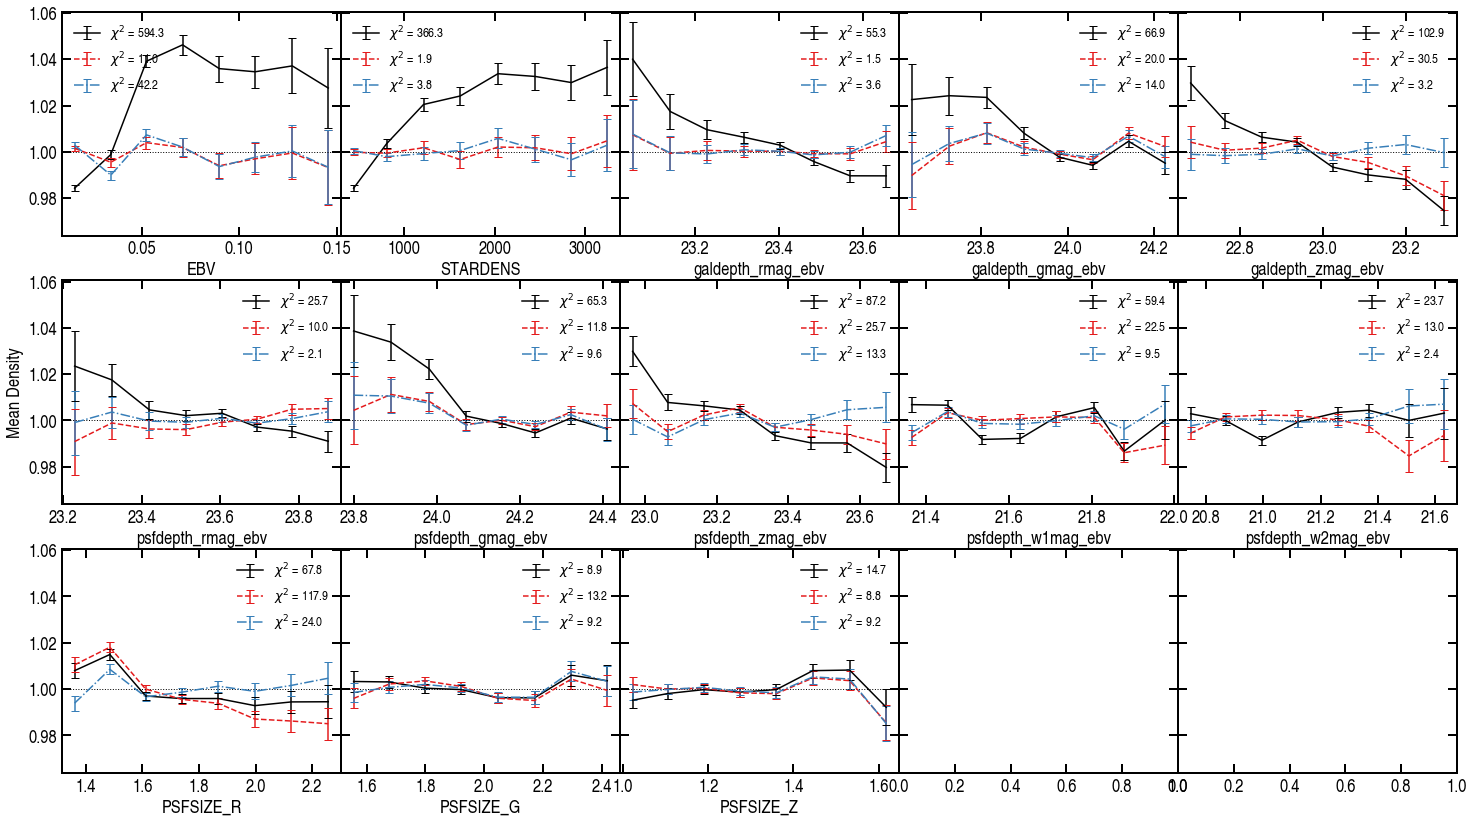

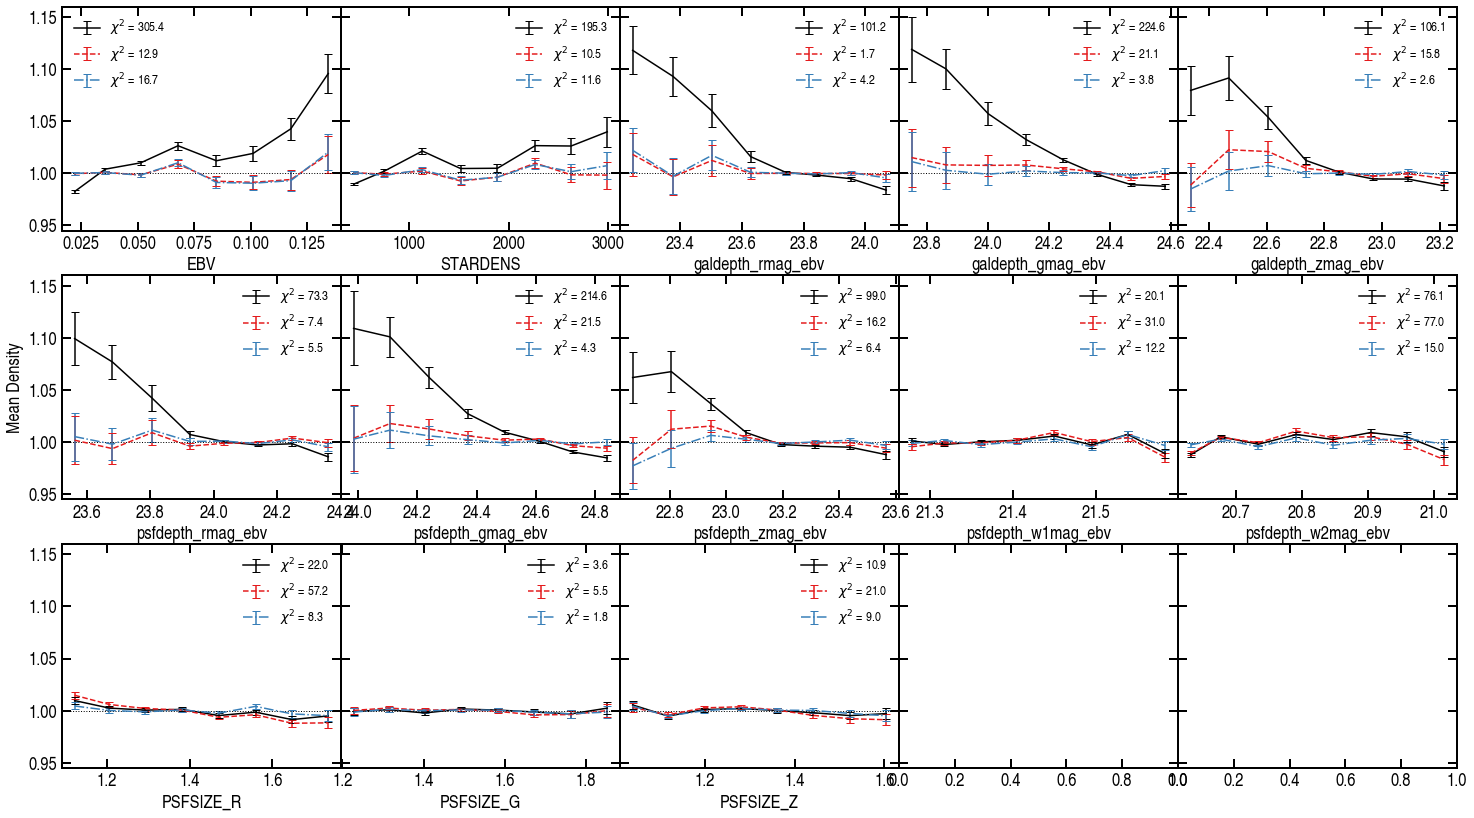

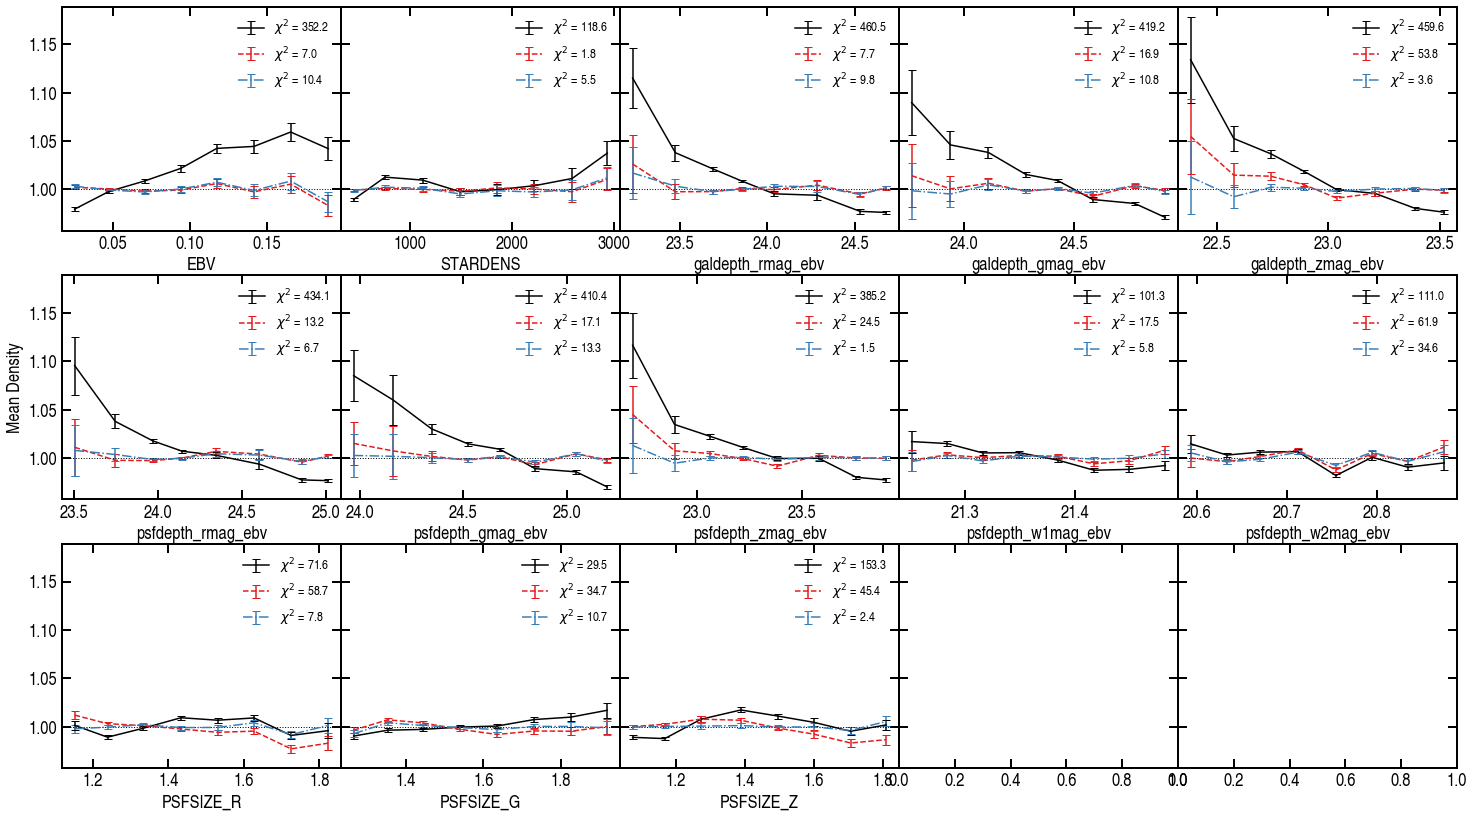

In [7]:
p_ = '/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/0.57.0/'
for r in ['bmzls', 'ndecals', 'sdecals']:
    
    nbars = {}
    for n in ['noweight', 'nn_known', 'nn_all']:
        nbars[n] = np.load(f'{p_}nbar_lrg_{r}_256_{n}.npy', allow_pickle=True)
        
    fg, ax = plt.subplots(nrows=3, ncols=5, figsize=(25, 14), sharey=True)
    ax = ax.flatten()
    fg.subplots_adjust(wspace=0.0)

    def errorbar(axi, *arrays, **kwargs):
        _, y, ye = arrays
        chi2 = (((y-1)/ye)**2).sum()
        axi.errorbar(*arrays, **kwargs, label=fr'$\chi^{2}$ = {chi2:.1f}')

    for i in range(13):
        for n in nbars.keys():
            errorbar(ax[i], nbars[n][i]['bin_avg'], nbars[n][i]['nnbar'], nbars[n][i]['nnbar_err'], capsize=4)

        ax[i].axhline(1.0, ls=':', lw=1)
        ax[i].set_xlabel(nbars['nn_known'][i]['sys'])
        ax[i].legend()
    # plt.plot(nbars['nn'])
    ax[5].set_ylabel('Mean Density')
    # plt.plot(nbars['noweight'])
    fg.show()

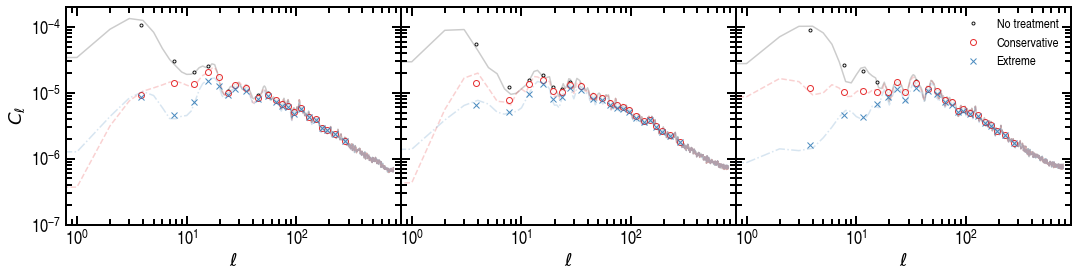

In [44]:
ell_edges = np.array([2, 6, 10, 14, 18, 22, 26] \
                   + [10*i for i in range(3,10)] \
                   + [100+i*20 for i in range(5)] \
                   + [200+i*50 for i in range(3)])


fg, ax = plt.subplots(ncols=3, figsize=(18, 4), sharey=True)
fg.subplots_adjust(wspace=0.0)

names = ['No treatment', 'Conservative', 'Extreme']
markers = ['.', 'o', 'x']

for i, r in enumerate(['bmzls', 'ndecals', 'sdecals']):
    
    for j,method in enumerate(['noweight', 'nn_known', 'nn_all']):



        cl = np.load(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/0.57.0/cl_lrg_{r}_256_{method}.npy', 
                     allow_pickle=True).item()
        lb, clb = histogram_cell(cl['cl_gg']['l'], cl['cl_gg']['cl'], bins=ell_edges)

        ln = ax[i].plot(cl['cl_gg']['cl'], alpha=0.2)
        ax[i].plot(lb, clb, marker=markers[j], 
                   ls='None', color=ln[0].get_color(), label=names[j], mfc='w', alpha=0.9)
        
    ax[i].set(yscale='log', xscale='log', ylim=(1.0e-7, 2.0e-4), xlim=(0.8, 900), xlabel=r'$\ell$')

ax[0].set(ylabel=r'$C_{\ell}$')
ax[2].legend()

In [7]:
def bin_cldr9(r, method): 
    
    ell_edges = np.array([2, 6, 10, 14, 18, 22, 26] \
                       + [10*i for i in range(3,10)] \
                       + [100+i*20 for i in range(5)] \
                       + [200+i*50 for i in range(3)])

    cl = np.load(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/0.57.0/cl_lrg_{r}_256_{method}.npy', 
                 allow_pickle=True).item()
    lb, clb = histogram_cell(cl['cl_gg']['l'], cl['cl_gg']['cl'], bins=ell_edges)
    
    np.savez(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/0.57.0/clgg_lrg_{r}_256_{method}.npz',
         **{'el_edges':ell_edges, 'el_bin':lb, 'cl':clb})

In [8]:
for r in ['bmzls', 'ndecals', 'sdecals']:
    for m in ['noweight', 'nn_known', 'nn_all']:
        bin_cldr9(r, m)

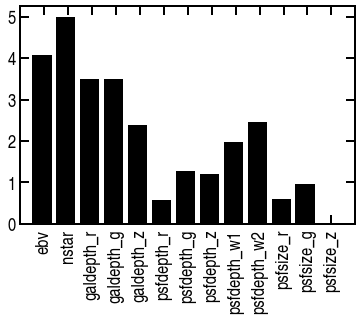

In [53]:
run_rfe('sdecals')

(-1, 13)

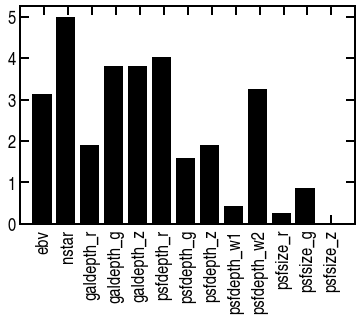

In [11]:
## Mean Density mocks

In [14]:
region = 'bmzls'
print(f'region: {region}')

list_nbars = glob(f'/fs/ess/PHS0336/data/lognormal/v0/clustering/nbarmock_*_lrg_{region}_256_noweight.npy')
err_mat = read_nbmocks(list_nbars)

region: bmzls
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [15]:
print('# mocks', len(list_nbars))
invcov, covmax = get_inv(err_mat, True)

# mocks 1000
Hartlap factor: 1.1174496644295302
with nmocks: 1000 and nbins: 104


In [18]:
np.diagonal(covmax)**0.5

array([0.00198348, 0.00450814, 0.00516802, 0.00776665, 0.00967367,
       0.01134104, 0.01301628, 0.01587732, 0.00199845, 0.00325227,
       0.00537817, 0.00733255, 0.00889576, 0.01083543, 0.01300263,
       0.01524648, 0.01500923, 0.00995488, 0.00644571, 0.00354827,
       0.00212516, 0.00220835, 0.00403652, 0.00729507, 0.01598874,
       0.01012854, 0.00656985, 0.00361072, 0.00196101, 0.00209158,
       0.0038266 , 0.00734165, 0.01038872, 0.00565124, 0.00313704,
       0.00219087, 0.00225374, 0.00373829, 0.00615206, 0.00974982,
       0.014655  , 0.00966374, 0.00598491, 0.00358533, 0.00231521,
       0.00211063, 0.00365741, 0.00716167, 0.01603861, 0.01001999,
       0.00637592, 0.00340135, 0.00199461, 0.00212979, 0.00378341,
       0.00742117, 0.0094239 , 0.00539582, 0.00295412, 0.00220962,
       0.00242409, 0.0036853 , 0.00585933, 0.00961718, 0.00688579,
       0.00508885, 0.00480477, 0.00483785, 0.00571637, 0.00541723,
       0.010269  , 0.02162776, 0.00571144, 0.00449524, 0.00473

In [24]:
covmax.shape[0]/13

8.0

In [9]:
d_ = np.load(f'/fs/ess/PHS0336/data/lognormal/v0/clustering/nbarmock_1_lrg_bmzls_256_noweight.npy', allow_pickle=True)

In [12]:
edges = []
for d_i in d_:
    edges.append(d_i['bin_edges'])

In [18]:
edge_ = np.array(edges).flatten()

In [20]:
edge_[27:27+9]

array([23.59330772, 23.67892117, 23.76453462, 23.85014806, 23.93576151,
       24.02137496, 24.1069884 , 24.19260185, 24.27821529])

In [16]:
class Data:
    def __init__(self, dt):
        self.ng = make_hp(256, dt['hpix'], dt['label'])
        self.pix = dt['hpix']
        self.nr = make_hp(256, dt['hpix'], dt['fracgood'])
        self.ebv = make_hp(256, dt['hpix'], dt['features'][:, 0])

In [17]:
bm = Data(bmzls)
nd = Data(ndecals)

In [18]:
common = np.intersect1d(bm.pix, nd.pix)

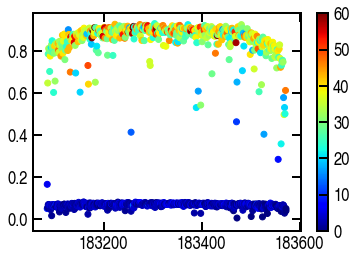

In [38]:
plt.scatter(common, bm.nr[common], c=bm.ng[common], cmap='jet', vmin=0, vmax=60)
plt.scatter(common, nd.nr[common], c=nd.ng[common], cmap='jet', vmin=0, vmax=60)
plt.colorbar()

(-1, 10)

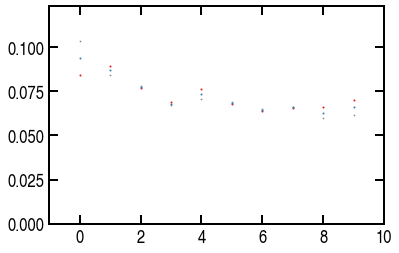

In [84]:
plt.scatter(np.arange(common.size), bm.ebv[common], 1, alpha=0.3)
plt.scatter(np.arange(common.size), nd.ebv[common], 1)
plt.scatter(np.arange(common.size), ebvc[common], 1)
plt.xlim([-1, 10])

In [40]:
ngc = np.concatenate([bmzls, ndecals])
ngc.size, bmzls.size+ndecals.size

(208530, 208530)

In [56]:
commons = np.in1d(ngc['hpix'], common)
ngc_ = ngc[commons]

In [72]:
common.size

486

In [74]:
commons = np.zeros(common.size, dtype=ngc_.dtype)

In [76]:
for key in commons.dtype.names:
    commons[key] = (ngc_[key][:-1:2]+ngc_[key][1::2]) / 2.0

In [79]:
ebvc = make_hp(256, commons['hpix'], commons['features'][:, 0])

In [70]:
ngc_['hpix'][:-1:2][:10]

array([183085, 183086, 183087, 183088, 183089, 183090, 183091, 183092,
       183093, 183094])

In [71]:
ngc_['hpix'][1::2][:10]

array([183085, 183086, 183087, 183088, 183089, 183090, 183091, 183092,
       183093, 183094])

## Parameter Fitting Mocks
### Best Fit on individual mocks

In [5]:
params = {}

for r in ['fullsky', 'bmzls']:
    bf = np.load(f'/fs/ess/PHS0336/data/lognormal/v0/mcmc/bestfit_{r}_noweight_fine.npz')

    if np.all(bf['success']):print(f'{r} all best fit optimizers termined successfully!')
    p = bf['params']
    p[:, 2] *= 1.0e7  # scale shotnoise term
    
    params[r] = p

fullsky all best fit optimizers termined successfully!
bmzls all best fit optimizers termined successfully!


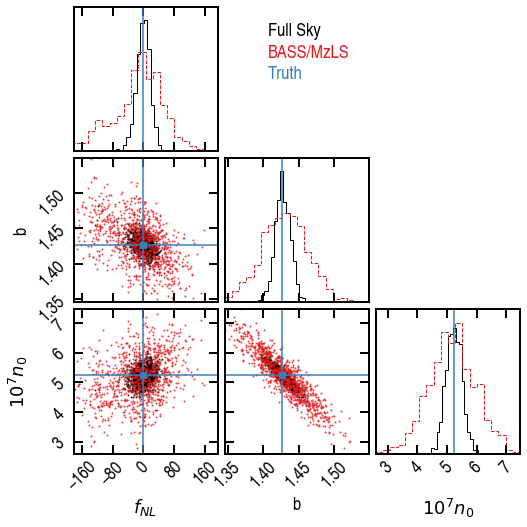

In [6]:
fg = corner.corner(params['fullsky'], labels=[r'$f_{NL}$', 'b', '$10^{7}n_{0}$'], truths=[0.0, 1.426, 5.24], truth_color='C2',
              **dict(fill_contours=False, plot_density=False, plot_contours=False, data_kwargs={'alpha':0.8}))
corner.corner(params['bmzls'], labels=[r'$f_{NL}$', 'b', '$10^{7}n_{0}$'], fig=fg, color='C1',
              **dict(fill_contours=False, plot_density=False, plot_contours=False, data_kwargs={'alpha':0.8}))
fg.align_labels()

ax = fg.get_axes()
ax[1].text(0.3, 0.8, 'Full Sky', color='C0', transform=ax[1].transAxes)
ax[1].text(0.3, 0.65, 'BASS/MzLS', color='C1', transform=ax[1].transAxes)
ax[1].text(0.3, 0.5, 'Truth', color='C2', transform=ax[1].transAxes)
# fg.savefig('bestfit_mocks.pdf', bbox_inches='tight')
fg.show()

In [12]:
params['fullsky'].std(axis=0)/params['bmzls'].std(axis=0), np.sqrt(0.125)

(array([0.29575075, 0.34186259, 0.34529955]), 0.3535533905932738)

### MCMC on mean of mocks

Text(0.3, 0.5, 'Truth')

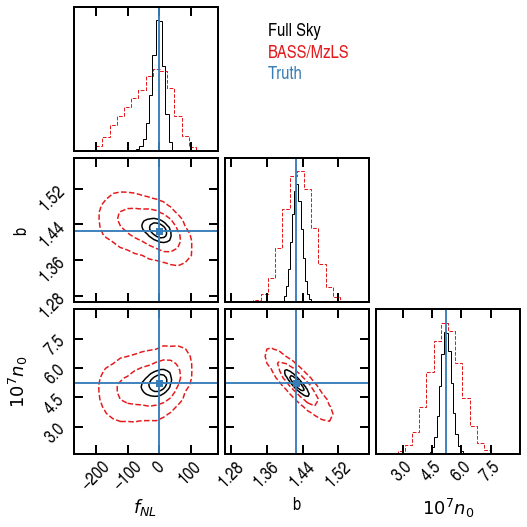

In [34]:
stats = {}

stats['BASS/MzLS'], bm = read_chain('/fs/ess/PHS0336/data/lognormal/v0/mcmc/mcmc_lrg_bmzls_noweight_steps10000_walkers50.npz')
stats['Full Sky'], fs = read_chain('/fs/ess/PHS0336/data/lognormal/v0/mcmc/mcmc_lrg_fullsky_noweight_steps10000_walkers50.npz')

kw = dict(plot_datapoints=False, truths=[0.0, 1.426, 5.24], truth_color='C2',
          labels=[r'$f_{NL}$', 'b', '$10^{7}n_{0}$'], plot_density=False,
          fill_contours=False, levels=[0.68, 0.95])

fig = corner.corner(fs, color='C0', **kw)
corner.corner(bm, fig=fig, color='C1', contour_kwargs=dict(linestyles='--'), **kw)
ax = fig.get_axes()

ax[1].text(0.3, 0.8, 'Full Sky', color='C0', transform=ax[1].transAxes)
ax[1].text(0.3, 0.65, 'BASS/MzLS', color='C1', transform=ax[1].transAxes)
ax[1].text(0.3, 0.5, 'Truth', color='C2', transform=ax[1].transAxes)

# fig.savefig('mcmc_mocks.pdf', bbox_inches='tight')

In [9]:
pstats = pd.DataFrame(stats,
                      index=['MAP [scipy]', 'MAP [chain]', 'Mean [chain]',
                             'Median [chain]', '16th', '84th']).T
pstats

MAP [scipy]  MAP [chain]  Mean [chain]  Median [chain]        16th  \
BASS/MzLS     1.538112     1.640255    -32.534779      -25.357378 -104.225468   
Full Sky     -0.102984     0.002433     -4.467522       -3.064479  -22.646831   

                84th  
BASS/MzLS  33.017024  
Full Sky   13.905328

In [13]:
(22.65+13.9)/(33.02+104.22), np.sqrt(0.125)

(0.2663217720781113, 0.3535533905932738)

Text(0.3, 0.5, 'Truth')

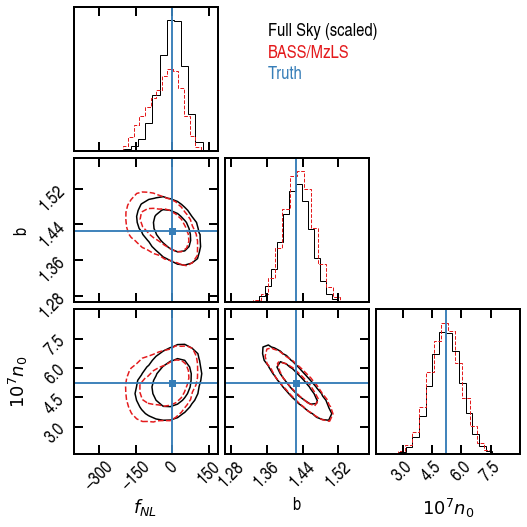

In [26]:
fs_ = fs.copy()
fs_m = fs_.mean(axis=0)
fs_ = fs_ - fs_m
fs_ /= np.sqrt(0.125)
fs_ += fs_m

kw = dict(plot_datapoints=False, truths=[0.0, 1.426, 5.24], truth_color='C2',
          labels=[r'$f_{NL}$', 'b', '$10^{7}n_{0}$'], plot_density=False,
          fill_contours=False, levels=[0.68, 0.95])

fig = corner.corner(fs_, color='C0', **kw)
corner.corner(bm, fig=fig, color='C1', contour_kwargs=dict(linestyles='--'), **kw)
ax = fig.get_axes()

ax[1].text(0.3, 0.8, 'Full Sky (scaled)', color='C0', transform=ax[1].transAxes)
ax[1].text(0.3, 0.65, 'BASS/MzLS', color='C1', transform=ax[1].transAxes)
ax[1].text(0.3, 0.5, 'Truth', color='C2', transform=ax[1].transAxes)

# fig.savefig('mcmc_mocks.pdf', bbox_inches='tight')

[Text(0, 0.5, 'b'), Text(0.5, 0, 'f$_{\\rm NL}$')]

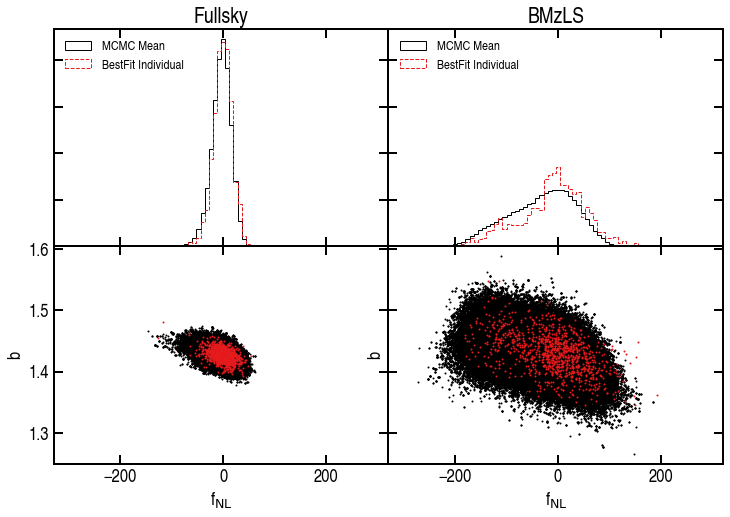

In [62]:
fg, ax = plt.subplots(nrows=2, ncols=2, 
                      figsize=(12, 8), sharex=True, 
                      sharey='row')
fg.subplots_adjust(hspace=0.0, wspace=0.0)
ax = ax.flatten()

kw = dict(density=True, histtype='step', bins=np.arange(-300, 300, 8))
ax[0].hist(fs[:, 0], **kw, label='MCMC Mean')
ax[0].hist(params['fullsky'][:, 0], **kw, label='BestFit Individual')
ax[0].set_yticklabels([])
ax[0].legend(loc=2)
ax[0].set(title='Fullsky')
ax[2].scatter(*fs[:, :2].T, 1.)
ax[2].scatter(*params['fullsky'][:, :2].T, 1.)
ax[2].set(xlabel=r'f$_{\rm NL}$', ylabel='b')


kw = dict(density=True, histtype='step', bins=np.arange(-300, 300, 8))
ax[1].hist(bm[:, 0], **kw, label='MCMC Mean')
ax[1].hist(params['bmzls'][:, 0], **kw, label='BestFit Individual')
ax[1].set_yticklabels([])
ax[1].set(title='BMzLS')
ax[1].legend(loc=2)
ax[3].scatter(*bm[:, :2].T, 1.)
ax[3].scatter(*params['bmzls'][:, :2].T, 1.)
ax[3].set(xlabel=r'f$_{\rm NL}$', ylabel='b')

## Model Spectrum

In [15]:
bm = np.load('/fs/ess/PHS0336/data/lognormal/v0/mcmc/mcmc_lrg_bmzls_noweight_steps10000_walkers50.npz')

zbdndz = init_sample(kind='lrg')

# read survey geometry
dt = ft.read(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_bmzls_256.fits')
w = np.zeros(12*256*256)
w[dt['hpix']] = 1.0
weight = hp.ud_grade(w, 1024)
mask = weight > 0.5

model = Spectrum()
model.add_tracer(*zbdndz, p=1.6)
model.add_kernels(np.arange(2000))

wind = WindowSHT(weight, mask, np.arange(2048), ngauss=2048)


fnl, b, noise = bm['best_fit']
el_g = np.arange(2000)
cl_bf = model(el_g, fnl=fnl, b=b, noise=noise)
        
cl_bfw = wind.convolve(el_g, cl_bf)
lmax = max(el_g)+1
cl_bfwic = wind.apply_ic(cl_bfw[:lmax])

cl_ = np.load('/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_bmzls_noweight_mean_fine.npz')
el_edges = cl_['el_edges']
el = cl_['el_bin']
cl = cl_['cl']

cl_models = {}
for name, cl_i in zip(['Best Fit Model', '+ Window Convolution', '+ Integral Constraint'],
                      [cl_bf, cl_bfw[:2000], cl_bfwic[:2000]]):
    
    cl_models[name] = histogram_cell(el_g, cl_i, bins=el_edges)

h         : 0.67556
T0_cmb    : 2.7255
Omega0_b  : 0.0482754208891869
Omega0_cdm: 0.26377065934278865
N_ur      : None
m_ncdm    : [0.06]
P_k_max   : 10.0
P_z_max   : 100.0
sigma8    : 0.8225
gauge     : synchronous
n_s       : 0.9667
nonlinear : False
p = 1.6


/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:263: RuntimeWarning: divide by zero encountered in true_divide
  fnl_f = self.alpha_fnl/(k2*self.Tlin(k))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:264: RuntimeWarning: invalid value encountered in multiply
  w_f1 = self.wfnlk1[i][1]*fnl_f
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:275: RuntimeWarning: invalid value encountered in multiply
  i_gf1.append(self.simps(k3pk*w_g*w_f1, lnk))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:276: RuntimeWarning: invalid value encountered in multiply
  i_gf2.append(self.simps(k3pk*w_g*w_f2, lnk))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:265: RuntimeWarning: invalid value encountered in multiply
  w_f2 = self.wfnlk2[i][1]*fnl_f
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:272: RuntimeWarning: invalid value encountered in multiply
  i_f1f1.append(self.simps(k3pk*w_f1*w_f1, lnk))
/users

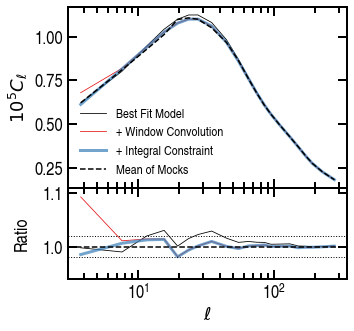

In [25]:
fig = plt.figure(figsize=(5, 5), constrained_layout=False)
gs = GridSpec(3, 1, figure=fig)

ax1 = fig.add_subplot(gs[:2, 0])
ax2 = fig.add_subplot(gs[2, 0])

f = 1.0e5
lw = [0.8, 0.8, 3.]
ls = ['-', '-', '-']
al = [1., 1., 0.7]
for i, (n, v) in enumerate(cl_models.items()):
    kw = dict(label=n, lw=lw[i], ls=ls[i], alpha=al[i])
    ax1.plot(v[0], f*v[1], **kw)
    ax2.plot(el, v[1]/cl, **kw)
    
ax1.plot(el, f*cl, 'C0--', label='Mean of Mocks')
ax2.axhline(1.0, color='C0', ls='--')


ax1.legend(ncol=1)
ax1.set(xscale='log', ylabel=r'$10^{5}C_{\ell}$')
ax1.tick_params(labelbottom=False)
ax2.set(xscale='log', xlabel=r'$\ell$', ylabel='Ratio')
ax2.set_xlim(ax1.get_xlim())
ax2.set(ylim=(0.94, 1.11))
for hline in [0.98, 1.02]:
    ax2.axhline(hline, ls=':', lw=1)

fig.subplots_adjust(hspace=0.0, wspace=0.02)
fig.align_labels()

# fig.savefig('model_window.pdf', bbox_inches='tight')

## Create C_ell for mocks with fNL != 0
Create cosmologies with fNL to test the pipeline

h         : 0.67556
T0_cmb    : 2.7255
Omega0_b  : 0.0482754208891869
Omega0_cdm: 0.26377065934278865
N_ur      : None
m_ncdm    : [0.06]
P_k_max   : 10.0
P_z_max   : 100.0
sigma8    : 0.8225
gauge     : synchronous
n_s       : 0.9667
nonlinear : False
p = 1.6


/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:263: RuntimeWarning: divide by zero encountered in true_divide
  fnl_f = self.alpha_fnl/(k2*self.Tlin(k))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:264: RuntimeWarning: invalid value encountered in multiply
  w_f1 = self.wfnlk1[i][1]*fnl_f
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:275: RuntimeWarning: invalid value encountered in multiply
  i_gf1.append(self.simps(k3pk*w_g*w_f1, lnk))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:276: RuntimeWarning: invalid value encountered in multiply
  i_gf2.append(self.simps(k3pk*w_g*w_f2, lnk))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:265: RuntimeWarning: invalid value encountered in multiply
  w_f2 = self.wfnlk2[i][1]*fnl_f
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:272: RuntimeWarning: invalid value encountered in multiply
  i_f1f1.append(self.simps(k3pk*w_f1*w_f1, lnk))
/users

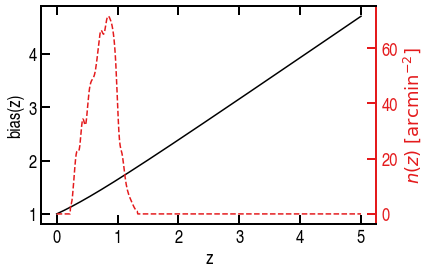

In [6]:
z, b, dNdz = init_sample(kind='lrg', plot=True)

model = Spectrum()
model.add_tracer(z, b, dNdz, p=1.6)
model.add_kernels(np.arange(2000))

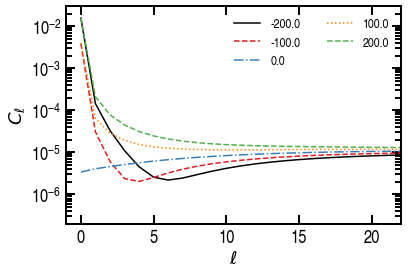

In [7]:
fg, ax = plt.subplots()


el = np.arange(2000)
for fnl, name in zip([-200, -100, 0, 100, 200],
                     ['ne200', 'ne100', 'zero', 'po100', 'po200']):
    
    cl_raw = model(el, fnl=fnl, b=1.43)
    ax.plot(cl_raw, label='%.1f'%fnl)
    np.savetxt(f'/users/PHS0336/medirz90/github/flask/data/desiCl{name}-f1z1f1z1.dat', 
               np.column_stack([el, cl_raw]), header='# el -- Cel')
    
ax.set(xlim=(-1, 22), yscale='log', xlabel=r'$\ell$', 
       ylim=(2.0e-7, 3.0e-2), ylabel=r'$C_\ell$')
ax.legend(ncol=2)
#bbox_to_anchor=(1.5, 1.))
#ax[1].set(xlim=(1, 700))

## Test Window with fNL mocks

In [14]:
zbdndz = init_sample(kind='lrg')

# read survey geometry
dt = ft.read(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_bmzls_256.fits')
w = np.zeros(12*256*256)
w[dt['hpix']] = 1.0
weight = hp.ud_grade(w, 1024)
mask = weight > 0.5

model = SurveySpectrum()
model.add_tracer(*zbdndz, p=1.6)
model.add_kernels(np.arange(2000))

h         : 0.67556
T0_cmb    : 2.7255
Omega0_b  : 0.0482754208891869
Omega0_cdm: 0.26377065934278865
N_ur      : None
m_ncdm    : [0.06]
P_k_max   : 10.0
P_z_max   : 100.0
sigma8    : 0.8225
gauge     : synchronous
n_s       : 0.9667
nonlinear : False
p = 1.6


/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:263: RuntimeWarning: divide by zero encountered in true_divide
  fnl_f = self.alpha_fnl/(k2*self.Tlin(k))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:264: RuntimeWarning: invalid value encountered in multiply
  w_f1 = self.wfnlk1[i][1]*fnl_f
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:275: RuntimeWarning: invalid value encountered in multiply
  i_gf1.append(self.simps(k3pk*w_g*w_f1, lnk))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:276: RuntimeWarning: invalid value encountered in multiply
  i_gf2.append(self.simps(k3pk*w_g*w_f2, lnk))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:265: RuntimeWarning: invalid value encountered in multiply
  w_f2 = self.wfnlk2[i][1]*fnl_f
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:272: RuntimeWarning: invalid value encountered in multiply
  i_f1f1.append(self.simps(k3pk*w_f1*w_f1, lnk))
/users

In [15]:
model.add_window(weight, mask, np.arange(2048), ngauss=2048)

In [5]:
cl_fs = np.load('/fs/ess/PHS0336/data/lognormal/v1/clustering/clmock_lrg-ne200_fullsky.npy')
cl_bm = np.load('/fs/ess/PHS0336/data/lognormal/v1/clustering/clmock_lrg-ne200_bmzls.npy')

[None,
 (1e-07, 0.001),
 Text(0, 0.5, 'C$_{\\ell}$'),
 None,
 Text(0.5, 0, '$\\ell$')]

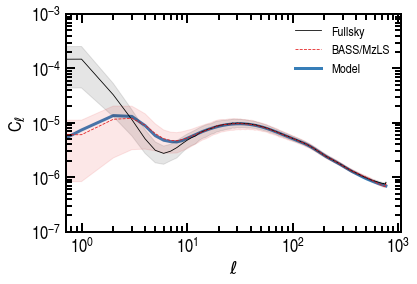

In [28]:
fg, ax = plt.subplots()

el = np.arange(768)

for cl_i, name_i in zip([cl_fs, cl_bm], 
                        ['Fullsky', 'BASS/MzLS']):
    
    ln, = ax.plot(cl_i.mean(axis=0), label=name_i, lw=0.8)
    ax.fill_between(el, *np.percentile(cl_i, [16, 84], axis=0), 
                    color=ln.get_color(), alpha=0.1)
    
    
ax.plot(el, model(el, fnl=-200, b=1.43, noise=5.0e-7), label='Model', lw=3, ls='-', zorder=-10)
ax.legend()
ax.set(xscale='log', yscale='log', ylim=(1.0e-7, 1.0e-3),
      xlabel=r'$\ell$', ylabel=r'C$_{\ell}$')

In [ ]:
,

In [5]:
from sympy.physics.wigner import wigner_3j

In [7]:
nside = 256
weight, mask = read_window('bmzls', nside=nside)

read window


In [7]:
from scipy.optimize import curve_fit

def model(l, *p):
    return p[0]*np.log10(l)+p[1]

def get_cl_wind(weight, mask, plot=False, nside=256):

    weight[~mask] = hp.UNSEEN
    cl_wind = hp.anafast(weight, lmax=2*nside)

    el_p = 10
    el = np.arange(5000)
    is_small = el < el_p

    lmin = 10
    lmax = 2*nside-1
    x = np.arange(lmin, lmax+1)
    y = cl_wind[lmin:lmax+1]
    res = curve_fit(model, x, np.log10(y), p0=[1, 1])

    cl_window = np.zeros(el.size)
    cl_window[:el_p] = cl_wind[:el_p]
    cl_window[~is_small] = 10**model(el[~is_small], *res[0])
    
    if plot:
        x_g = np.arange(el_p, 5000)
        plt.plot(cl_wind, alpha=0.2, lw=4)
        plt.plot(cl_window, alpha=0.4, lw=2, ls='-')
        plt.plot(x_g, 10**model(x_g, *res[0]), lw=1)
        plt.xscale('log')
        plt.yscale('log')    
        
    return cl_window

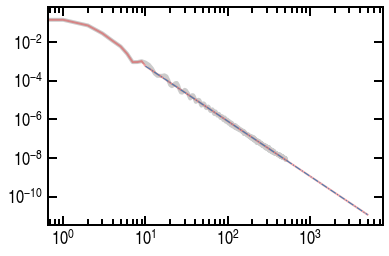

In [8]:
cl_w = get_cl_wind(weight, mask, plot=True)

In [9]:
l1 = np.arange(31)
l2 = np.arange(100)
l3 = np.arange(200)

mixm = np.zeros((l1.size, l2.size))
for l1_ in l1:
    print('.', end='')
    
    for l2_ in l2:
        l3sum_ = 0.0        
        for l3_ in l3:
            l3sum_ += (2*l3_+1)*cl_w[l3_]*float(wigner_3j(l1_, l2_, l3_, 0, 0, 0))**2        
        mixm[l1_, l2_] = l3sum_*(2*l2_+1)/(4.*np.pi)
        

# res = float()
mixm

...............................

array([[1.55370159e-02, 3.32664977e-02, 2.82236370e-02, ...,
        1.35140880e-05, 1.32598919e-05, 1.30129924e-05],
       [1.10888326e-02, 2.68264707e-02, 2.87753917e-02, ...,
        1.35199178e-05, 1.32654957e-05, 1.30183812e-05],
       [5.64472740e-03, 1.72652350e-02, 2.59126189e-02, ...,
        1.35315883e-05, 1.32767137e-05, 1.30291686e-05],
       ...,
       [2.38041426e-06, 7.17846684e-06, 1.20896054e-05, ...,
        1.62182741e-05, 1.58518891e-05, 1.54986825e-05],
       [2.15414575e-06, 6.49382766e-06, 1.09287914e-05, ...,
        1.64407890e-05, 1.60645353e-05, 1.57020174e-05],
       [1.95599768e-06, 5.89461794e-06, 9.91399254e-06, ...,
        1.66756903e-05, 1.62889172e-05, 1.59164805e-05]])

In [10]:
fsky = mask.mean()
fsky

0.1246477762858073

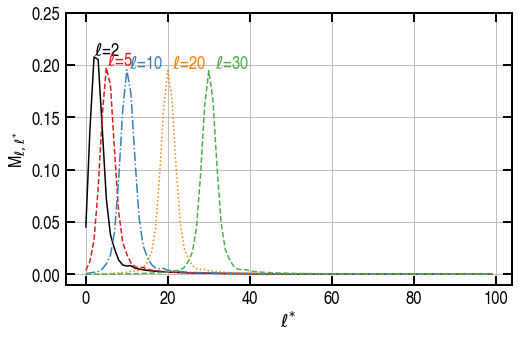

In [11]:
plt.figure(figsize=(8, 5))

for ell in [2, 5, 10, 20, 30]:
    y_ = mixm[ell, :]/fsky
    line,  = plt.plot(y_)
    plt.text(np.argmax(y_)*1.05, y_.max()*1.01, r'$\ell$=%d'%ell, color=line.get_color())
    
plt.ylabel(r'M$_{\ell, \ell^{*}}$')
plt.xlabel(r'$\ell^{*}$')
plt.ylim(-0.01, .25)
# plt.legend()
plt.grid()

(-4.95, 60)

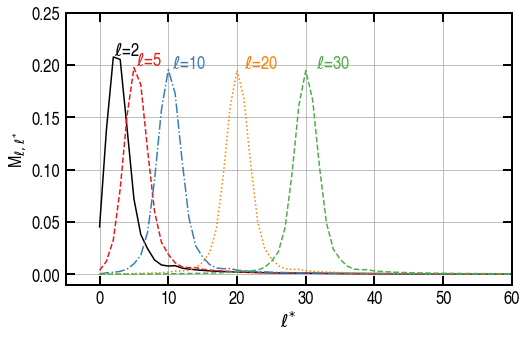

In [12]:
plt.figure(figsize=(8, 5))

for ell in [2, 5, 10, 20, 30]:
    y_ = mixm[ell, :]/fsky
    line,  = plt.plot(y_)
    plt.text(np.argmax(y_)*1.05, y_.max()*1.01, r'$\ell$=%d'%ell, color=line.get_color())
    
plt.ylabel(r'M$_{\ell, \ell^{*}}$')
plt.xlabel(r'$\ell^{*}$')
plt.ylim(-0.01, .25)
# plt.legend()
plt.grid()
plt.xlim(xmax=60)

In [8]:
el = np.arange(1000)
wind = WindowSHT(weight, mask, el)

In [9]:
wind.read_rr('../scripts/bmzls_rr_window_256.npy', mask.sum(), 12*256*256)

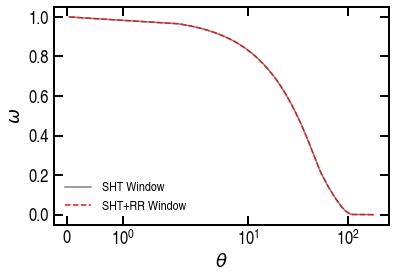

In [10]:
x_ = np.degrees(np.arccos(wind.x))

plt.plot(x_, wind.xi_mask, alpha=0.5, label='SHT Window')
plt.plot(x_, wind.xi_mask_smooth, label='SHT+RR Window')
                
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\omega$')
plt.xscale('symlog', linethreshx=1)
plt.legend(loc='lower left')#, title='BASS/MzLS')
# plt.axes([0.4,  ,0.45, 0.45, 0.35])


# plt.plot(x_, wind.xi_mask, alpha=0.5)
# plt.plot(x_, wind.xi_mask_smooth)
# plt.yscale('log')
# plt.ylim(-1.0e-6, 1.0e-5)
# plt.xlim(100, 190)
# plt.axis([90, 190, -4.0e-8, 3.5e-8])

In [11]:
z, b, dNdz = init_sample(kind='lrg')

model = Spectrum()
model.add_tracer(z, b, dNdz, p=1.6)
model.add_kernels(np.arange(2000))

h         : 0.67556
T0_cmb    : 2.7255
Omega0_b  : 0.0482754208891869
Omega0_cdm: 0.26377065934278865
N_ur      : None
m_ncdm    : [0.06]
P_k_max   : 10.0
P_z_max   : 100.0
sigma8    : 0.8225
gauge     : synchronous
n_s       : 0.9667
nonlinear : False
p = 1.6


/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:263: RuntimeWarning: divide by zero encountered in true_divide
  fnl_f = self.alpha_fnl/(k2*self.Tlin(k))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:264: RuntimeWarning: invalid value encountered in multiply
  w_f1 = self.wfnlk1[i][1]*fnl_f
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:275: RuntimeWarning: invalid value encountered in multiply
  i_gf1.append(self.simps(k3pk*w_g*w_f1, lnk))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:276: RuntimeWarning: invalid value encountered in multiply
  i_gf2.append(self.simps(k3pk*w_g*w_f2, lnk))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:265: RuntimeWarning: invalid value encountered in multiply
  w_f2 = self.wfnlk2[i][1]*fnl_f
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:272: RuntimeWarning: invalid value encountered in multiply
  i_f1f1.append(self.simps(k3pk*w_f1*w_f1, lnk))
/users

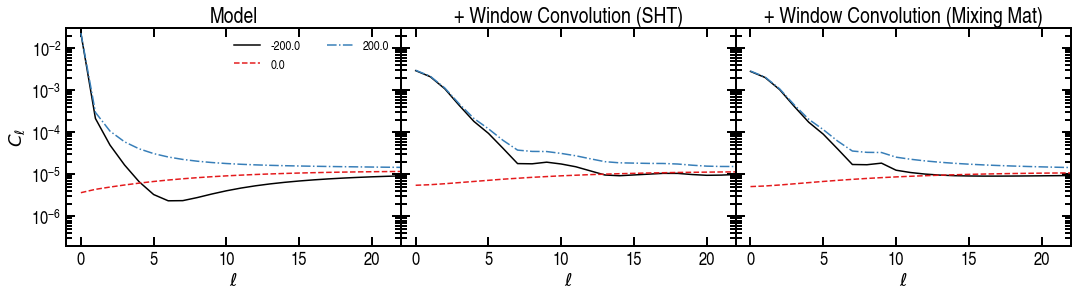

In [18]:
fg, ax = plt.subplots(ncols=3, sharey=True, sharex=True, figsize=(18, 4))
fg.subplots_adjust(wspace=0.0)

el = np.arange(2000)
for fnl in [-200, 0, 200]:
    
    cl_raw = model(el, fnl=fnl, b=1.5)
    cl_w = wind.convolve(el, cl_raw)
    cl_w2 = mixm.dot(cl_raw[:100])/0.13
    
    ax[0].plot(cl_raw, label='%.1f'%fnl)
    ax[1].plot(cl_w)
    ax[2].plot(cl_w2)
    
ax[0].set(xlim=(-1, 22), yscale='log', ylim=(2.0e-7, 3.0e-2), ylabel=r'$C_\ell$')

titles = ['Model', '+ Window Convolution (SHT)', '+ Window Convolution (Mixing Mat)']
for i, axi in enumerate(ax):
    axi.set_title(titles[i])
    axi.set_xlabel(r'$\ell$')
ax[0].legend(ncol=2)#bbox_to_anchor=(1.5, 1.))
#ax[1].set(xlim=(1, 700))

rm sq
rm sq
rm sq
rm sq
rm sq
rm sq
rm sq


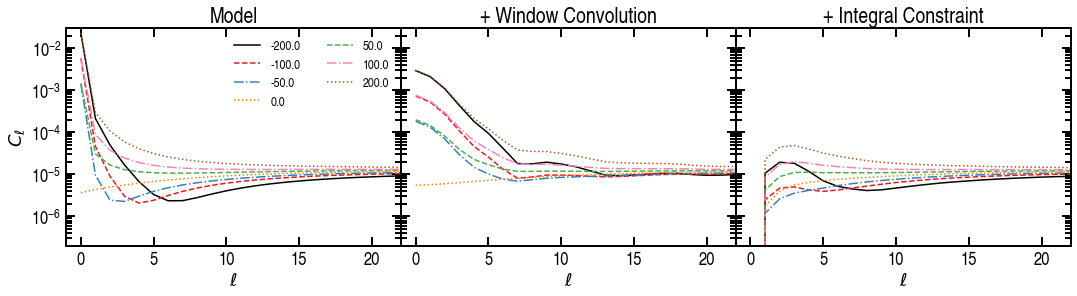

In [12]:
fg, ax = plt.subplots(ncols=3, sharey=True, sharex=True, figsize=(18, 4))
fg.subplots_adjust(wspace=0.0)

el = np.arange(2000)
for fnl in [-200, -100, -50, 0, 50, 100, 200]:
    cl_raw = model(el, fnl=fnl, b=1.5)
    cl_w = wind.convolve(el, cl_raw)
    cl_wic = wind.apply_ic(cl_w[:700])
    
    ax[0].plot(cl_raw, label='%.1f'%fnl)
    ax[1].plot(cl_w)
    ax[2].plot(cl_wic)
    
ax[0].set(xlim=(-1, 22), yscale='log', ylim=(2.0e-7, 3.0e-2), ylabel=r'$C_\ell$')

titles = ['Model', '+ Window Convolution', '+ Integral Constraint']
for i, axi in enumerate(ax):
    axi.set_title(titles[i])
    axi.set_xlabel(r'$\ell$')
ax[0].legend(ncol=2)#bbox_to_anchor=(1.5, 1.))
#ax[1].set(xlim=(1, 700))

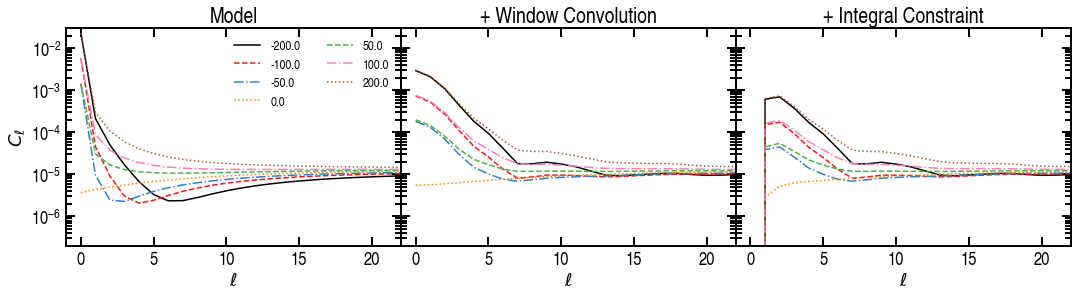

In [21]:
fg, ax = plt.subplots(ncols=3, sharey=True, sharex=True, figsize=(18, 4))
fg.subplots_adjust(wspace=0.0)

el = np.arange(2000)
for fnl in [-200, -100, -50, 0, 50, 100, 200]:
    cl_raw = model(el, fnl=fnl, b=1.5)
    cl_w = wind.convolve(el, cl_raw)
    cl_wic = wind.apply_ic(cl_w[:700])
    
    ax[0].plot(cl_raw, label='%.1f'%fnl)
    ax[1].plot(cl_w)
    ax[2].plot(cl_wic)
    
ax[0].set(xlim=(-1, 22), yscale='log', ylim=(2.0e-7, 3.0e-2), ylabel=r'$C_\ell$')

titles = ['Model', '+ Window Convolution', '+ Integral Constraint']
for i, axi in enumerate(ax):
    axi.set_title(titles[i])
    axi.set_xlabel(r'$\ell$')
ax[0].legend(ncol=2)#bbox_to_anchor=(1.5, 1.))
#ax[1].set(xlim=(1, 700))

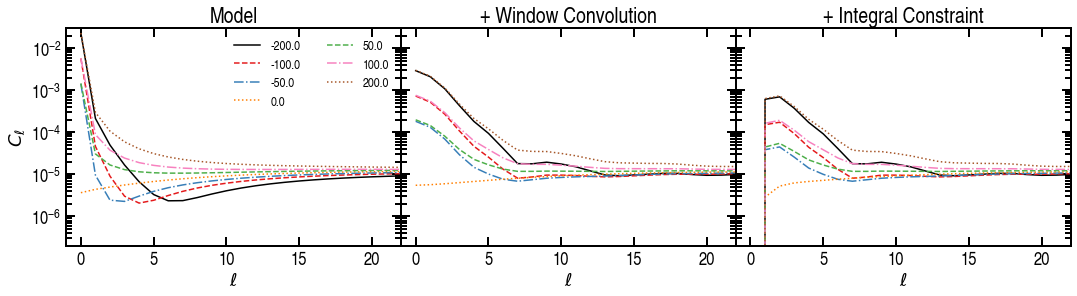

In [22]:
fg, ax = plt.subplots(ncols=3, sharey=True, sharex=True, figsize=(18, 4))
fg.subplots_adjust(wspace=0.0)

el = np.arange(2000)
for fnl in [-200, -100, -50, 0, 50, 100, 200]:
    cl_raw = model(el, fnl=fnl, b=1.5)
    cl_w = wind.convolve(el, cl_raw, with_smooth=True)
    cl_wic = wind.apply_ic(cl_w[:700])
    
    ax[0].plot(cl_raw, label='%.1f'%fnl)
    ax[1].plot(cl_w)
    ax[2].plot(cl_wic)
    
ax[0].set(xlim=(-1, 22), yscale='log', ylim=(2.0e-7, 3.0e-2), ylabel=r'$C_\ell$')

titles = ['Model', '+ Window Convolution', '+ Integral Constraint']
for i, axi in enumerate(ax):
    axi.set_title(titles[i])
    axi.set_xlabel(r'$\ell$')
ax[0].legend(ncol=2)#bbox_to_anchor=(1.5, 1.))
#ax[1].set(xlim=(1, 700))

[90, 190, -5.1e-07, 5.1e-07]

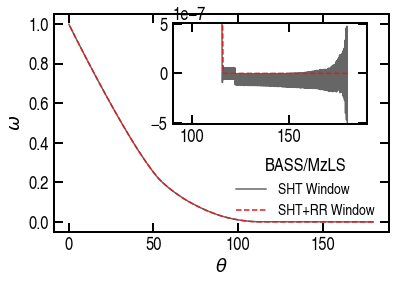

Text(0, 0.5, '$\\omega$')

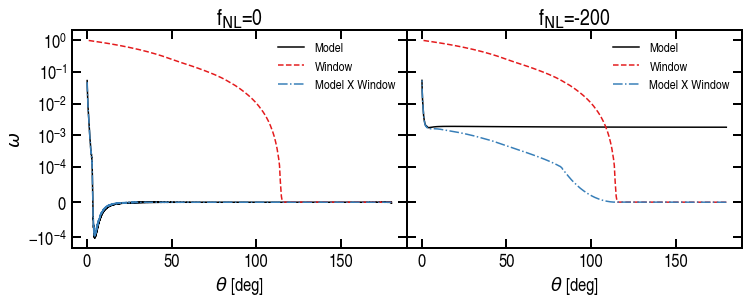

In [24]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)
fig.subplots_adjust(wspace=0.0)

s = np.degrees(np.arccos(wind.x))

for i, (a, fnl) in enumerate(zip(ax, [0, -200])):
    
    cl_raw = model(el, fnl=fnl, b=1.5)
    xi_raw = wind.cl2xi(el, cl_raw)

    a.plot(s, xi_raw, label='Model')
    a.plot(s, wind.xi_mask_smooth, label='Window')
    a.plot(s, wind.xi_mask_smooth*xi_raw, label='Model X Window')

    a.legend(loc='upper right')
    a.set_xlabel(r'$\theta$ [deg]')
    a.set_title(r'f$_{\rm NL}$=%.f'%fnl)
    a.set_yscale('symlog', linthreshy=1.0e-4)
    
ax[0].set_ylabel(r'$\omega$')    

Text(0, 0.5, '$\\omega$')

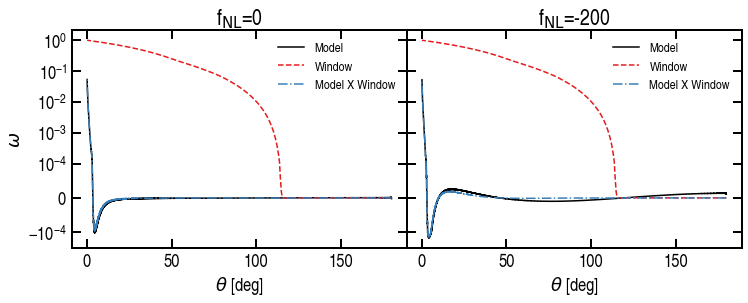

In [27]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)
fig.subplots_adjust(wspace=0.0)

s = np.degrees(np.arccos(wind.x))

for i, (a, fnl) in enumerate(zip(ax, [0, -200])):
    
    cl_raw = model(el, fnl=fnl, b=1.5)
    cl_raw[0] = 0
    cl_raw[1] = 0
    xi_raw = wind.cl2xi(el, cl_raw)

    a.plot(s, xi_raw, label='Model')
    a.plot(s, wind.xi_mask_smooth, label='Window')
    a.plot(s, wind.xi_mask_smooth*xi_raw, label='Model X Window')

    a.legend(loc='upper right')
    a.set_xlabel(r'$\theta$ [deg]')
    a.set_title(r'f$_{\rm NL}$=%.f'%fnl)
    a.set_yscale('symlog', linthreshy=1.0e-4)
    
ax[0].set_ylabel(r'$\omega$')    

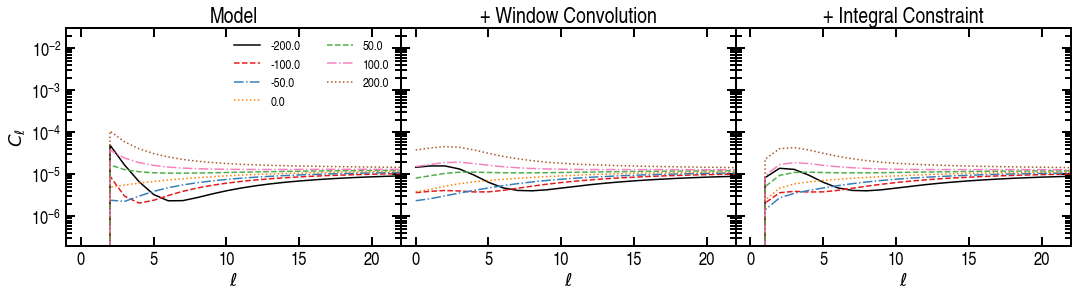

In [28]:
fg, ax = plt.subplots(ncols=3, sharey=True, sharex=True, figsize=(18, 4))
fg.subplots_adjust(wspace=0.0)

el = np.arange(2000)
for fnl in [-200, -100, -50, 0, 50, 100, 200]:
    cl_raw = model(el, fnl=fnl, b=1.5)
    cl_raw[:2] = 0.0
    cl_w = wind.convolve(el, cl_raw, with_smooth=True)
    cl_wic = wind.apply_ic(cl_w[:700])
    
    ax[0].plot(cl_raw, label='%.1f'%fnl)
    ax[1].plot(cl_w)
    ax[2].plot(cl_wic)
    
ax[0].set(xlim=(-1, 22), yscale='log', ylim=(2.0e-7, 3.0e-2), ylabel=r'$C_\ell$')

titles = ['Model', '+ Window Convolution', '+ Integral Constraint']
for i, axi in enumerate(ax):
    axi.set_title(titles[i])
    axi.set_xlabel(r'$\ell$')
ax[0].legend(ncol=2)#bbox_to_anchor=(1.5, 1.))
#ax[1].set(xlim=(1, 700))

In [25]:
cl_raw = model(el, fnl=fnl, b=1.5)
xi_raw = wind.cl2xi(el, cl_raw)
cl_raw2 = wind.xi2cl(xi_raw)

Text(0, 0.5, 'C$_{\\ell}$')

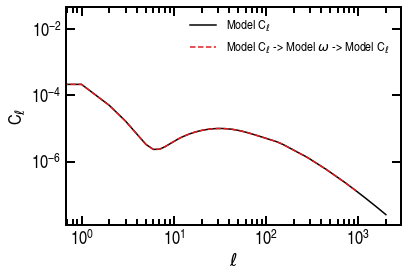

In [26]:
plt.plot(cl_raw, label=r'Model C$_{\ell}$')
plt.plot(cl_raw2, label='Model C$_{\ell}$ -> Model $\omega$ -> Model C$_{\ell}$')

plt.legend()
plt.loglog()
plt.xlabel(r'$\ell$')
plt.ylabel(r'C$_{\ell}$')

In [84]:
abs(cl_raw[:1100]/cl_raw2).max()

0.9999999999991181

In [5]:
region = 'bmzls'
path_cov = '/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_bmzls_noweight_mean_fine.npz'  
cl_cov_ = np.load(path_cov)

el_edges = cl_cov_['el_edges']
icov = np.linalg.inv(cl_cov_['clcov'])

def read_inputs(path_cl, path_cov):
    
    dcl_obs = np.load(path_cl)
    dclcov_obs = np.load(path_cov)
    assert np.array_equal(dcl_obs['el_edges'], dclcov_obs['el_edges'])
    
    el_edges = dcl_obs['el_edges']
    cl_obs = dcl_obs['cl']
    invcov_obs = np.linalg.inv(dclcov_obs['clcov'])

    return el_edges, cl_obs, invcov_obs

def read_mask(region):

    import fitsio as ft
    import healpy as hp
    from lssutils.utils import make_hp

    if region in ['bmzls', 'ndecals', 'sdecals']:
        # read survey geometry
        data_path = '/fs/ess/PHS0336/data/'    
        dt = ft.read(f'{data_path}/rongpu/imaging_sys/tables/v3/nlrg_features_{region}_256.fits')
        mask_  = make_hp(256, dt['hpix'], 1.0) > 0.5
        mask   = hp.ud_grade(mask_, 1024)
    else:
        # full sky
        mask = np.ones(12*1024*1024, '?')

    return mask*1.0, mask



## Best Fit

In [6]:
cl_mocks = np.load('/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_fullsky.npy')
cl_mocks

array([[2.04854494e-14, 1.45340290e-06, 2.04400854e-06, ...,
        8.06725398e-07, 8.10530775e-07, 8.08716096e-07],
       [3.40615862e-14, 1.01071517e-06, 3.52844204e-06, ...,
        8.16802289e-07, 8.20210241e-07, 7.64422700e-07],
       [5.57253618e-14, 3.91454194e-06, 4.76416452e-06, ...,
        8.07000923e-07, 7.76872766e-07, 7.71362659e-07],
       ...,
       [7.25116015e-14, 1.70695615e-06, 7.32022878e-07, ...,
        7.39731924e-07, 8.71905131e-07, 8.07661318e-07],
       [4.66296690e-13, 2.15230332e-06, 3.94646321e-06, ...,
        7.45054877e-07, 8.07203668e-07, 7.92478223e-07],
       [7.50253283e-14, 4.05866333e-06, 1.19159348e-06, ...,
        8.11915831e-07, 8.14318733e-07, 7.93226438e-07]])

In [7]:
cl_mocks.shape

(1000, 768)

In [8]:
region = 'fullsky'
path_cov = '/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_fullsky_cov.npz'  
cl_cov_ = np.load(path_cov)

el_edges = cl_cov_['el_edges']
icov = np.linalg.inv(cl_cov_['clcov'])

weight, mask = read_mask(region)

In [9]:
z, b, dNdz = init_sample(kind='lrg')
model = SurveySpectrum()
model.add_tracer(z, b, dNdz, p=1.6)
model.add_kernels(model.el_model)
model.add_window(weight, mask, np.arange(2048), ngauss=2048)
print(mask.mean())

h         : 0.67556
T0_cmb    : 2.7255
Omega0_b  : 0.0482754208891869
Omega0_cdm: 0.26377065934278865
N_ur      : None
m_ncdm    : [0.06]
P_k_max   : 10.0
P_z_max   : 100.0
sigma8    : 0.8225
gauge     : synchronous
n_s       : 0.9667
nonlinear : False
p = 1.6


/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:263: RuntimeWarning: divide by zero encountered in true_divide
  fnl_f = self.alpha_fnl/(k2*self.Tlin(k))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:264: RuntimeWarning: invalid value encountered in multiply
  w_f1 = self.wfnlk1[i][1]*fnl_f
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:265: RuntimeWarning: invalid value encountered in multiply
  w_f2 = self.wfnlk2[i][1]*fnl_f
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:272: RuntimeWarning: invalid value encountered in multiply
  i_f1f1.append(self.simps(k3pk*w_f1*w_f1, lnk))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:273: RuntimeWarning: invalid value encountered in multiply
  i_f2f2.append(self.simps(k3pk*w_f2*w_f2, lnk))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:275: RuntimeWarning: invalid value encountered in multiply
  i_gf1.append(self.simps(k3pk*w_g*w_f1, lnk))
/use

1.0


In [10]:
params = []
el = np.arange(cl_mocks.shape[1])
for i in range(100):
    
    cl_i = cl_mocks[i, :]

    cl_obs = histogram_cell(el, cl_i, bins=el_edges)[1]

    lg = Posterior(model, cl_obs, icov, el_edges)
    def neglogpost(foo):
        return -lg.logpost(foo)

    t0 = time()
    res = minimize(neglogpost, [1.0, 1.0, 1.0e-7], method='Powell')
    t1 = time()
    if i==0:
        print(f'best fit: {res.x}, -logprob: {res.fun:.3f} #data: {cl_obs.size} in {t1-t0:.2f} sec')

    params.append(res.x)
    print('.', end='')

/users/PHS0336/medirz90/miniconda3/envs/sysnet/lib/python3.8/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/users/PHS0336/medirz90/miniconda3/envs/sysnet/lib/python3.8/site-packages/scipy/optimize/optimize.py:2150: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


best fit: [8.89595847e+00 9.90172493e-01 5.40820276e-07], -logprob: 4.509 #data: 17 in 18.88 sec
............

KeyboardInterrupt: 

In [11]:
params = np.array(params)
params.shape

(18, 3)

Text(0, 0.5, '10$^7$ noise')

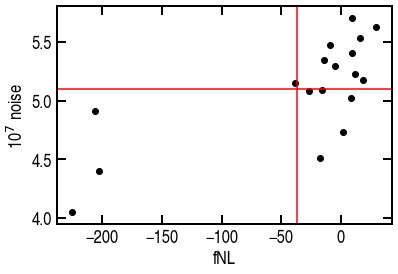

In [13]:
plt.scatter(params[:, 0], params[:, 2]*1.0e7)
plt.axhline(np.mean(params[:, 2]*1.0e7), ls='-', color='r')
plt.axvline(np.mean(params[:, 0]), ls='-', color='r')
plt.xlabel('fNL')
plt.ylabel(r'10$^7$ noise')

Text(0, 0.5, '10$^7$ noise')

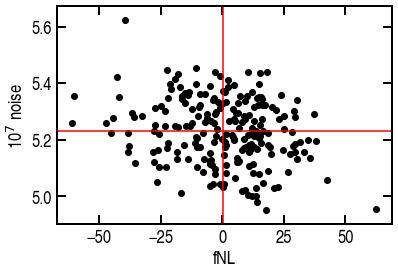

In [32]:
plt.scatter(params[:, 0], params[:, 1]*1.0e7)
plt.axhline(np.mean(params[:, 1]*1.0e7), ls='-', color='r')
plt.axvline(np.mean(params[:, 0]), ls='-', color='r')
plt.xlabel('fNL')
plt.ylabel(r'10$^7$ noise')

In [34]:
np.mean(params, axis=0), np.std(params, axis=0)

(array([4.36747946e-01, 5.22967446e-07]),
 array([1.95331925e+01, 1.14647751e-08]))

## Fisher

In [6]:
region = 'bmzls'
path_cl = '/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_bmzls_noweight_mean.npz'
path_cov = '/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_bmzls_noweight_cov.npz'  

el_edges, cl_obs, invcov_obs = read_inputs(path_cl, path_cov)
cov_obs = np.linalg.inv(invcov_obs)
weight, mask = read_mask(region)

z, b, dNdz = init_sample(kind='lrg')
model = SurveySpectrum()
model.add_tracer(z, b, dNdz, p=1.6)
model.add_kernels(model.el_model)
model.add_window(weight, mask, np.arange(2048), ngauss=2048)  

h         : 0.67556
T0_cmb    : 2.7255
Omega0_b  : 0.0482754208891869
Omega0_cdm: 0.26377065934278865
N_ur      : None
m_ncdm    : [0.06]
P_k_max   : 10.0
P_z_max   : 100.0
sigma8    : 0.8225
gauge     : synchronous
n_s       : 0.9667
nonlinear : False
p = 1.6


/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:263: RuntimeWarning: divide by zero encountered in true_divide
  fnl_f = self.alpha_fnl/(k2*self.Tlin(k))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:264: RuntimeWarning: invalid value encountered in multiply
  w_f1 = self.wfnlk1[i][1]*fnl_f
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:265: RuntimeWarning: invalid value encountered in multiply
  w_f2 = self.wfnlk2[i][1]*fnl_f
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:272: RuntimeWarning: invalid value encountered in multiply
  i_f1f1.append(self.simps(k3pk*w_f1*w_f1, lnk))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:273: RuntimeWarning: invalid value encountered in multiply
  i_f2f2.append(self.simps(k3pk*w_f2*w_f2, lnk))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:275: RuntimeWarning: invalid value encountered in multiply
  i_gf1.append(self.simps(k3pk*w_g*w_f1, lnk))
/use

In [7]:
cl_ = np.load(path_cl)
el_bin = cl_['el_bin']
el_edges = cl_['el_edges']
cl_cov = np.load(path_cov)
cov = cl_cov['clcov']
cl_cov.files

['el_edges', 'el_bin', 'clcov']

In [9]:
noise = 5.24256916e-07
fnl = 0.0
eps = 1.0e-8
el_ = np.arange(el_edges.max()+1)


mp_ = model(el_, fnl+eps, noise=noise)
mn_ = model(el_, fnl-eps, noise=noise)
el_b, mp = histogram_cell(el_, mp_, bins=el_edges)
mn = histogram_cell(el_, mn_, bins=el_edges)[1]
assert np.array_equal(el_b, el_bin)

dcl_f = (mp-mn)/(2*eps)

mp_ = model(el_, fnl=fnl, noise=noise+eps)
mn_ = model(el_, fnl=fnl, noise=noise-eps)
el_b, mp = histogram_cell(el_, mp_, bins=el_edges)
mn = histogram_cell(el_, mn_, bins=el_edges)[1]

dcl_n = (mp-mn)/(2*eps)

In [14]:
dcl_l = [dcl_f, dcl_n]

icov = np.linalg.inv(cov)
fisher = np.zeros((2, 2))
for i, dcl_i in enumerate(dcl_l):
    for j, dcl_j in enumerate(dcl_l):
        fisher[i, j] = dcl_i.dot(icov.dot(dcl_j))
fisher

array([[4.59408666e-04, 2.18673784e+05],
       [2.18673784e+05, 9.40142390e+14]])

In [15]:
ifisher = np.linalg.inv(fisher)
ifisher

array([[ 2.44770527e+03, -5.69327560e-07],
       [-5.69327560e-07,  1.19609223e-15]])

In [46]:
pdf = lambda x, mu, sig:np.exp(-0.5*(x-mu)**2/sig**2)/np.sqrt(2.*np.pi*sig**2)

In [47]:
from scipy.stats import norm

49.47428894820671


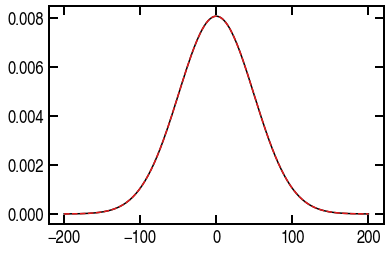

In [48]:
sig = np.sqrt(ifisher[0, 0])
print(sig)
fnl_g = np.linspace(-200, 200, 200)
plt.plot(fnl_g, pdf(fnl_g, 0.0, sig))

In [22]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

In [37]:
def confidence_ellipse(cov, ax, n_std=1.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    #if x.size != y.size:
    #    raise ValueError("x and y must be the same size")

    #cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = 0.0#np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = 0.0#np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [34]:
ifisher

array([[ 2.44770527e+03, -5.69327560e-07],
       [-5.69327560e-07,  1.19609223e-15]])

[(-1, 1), (-1, 1)]

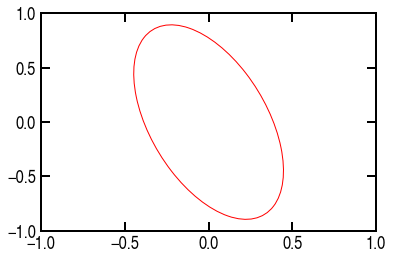

In [45]:
fig, ax = plt.subplots()
confidence_ellipse(np.array([[0.2, -0.2], 
                                 [-0.2, 0.8]]), ax, edgecolor='r')

ax.set(xlim=(-1, 1), ylim=(-1, 1))

In [13]:
fisher.dot(ifisher)

array([[1., 0.],
       [0., 1.]])

In [ ]:
dcl_f.dot(cov.)

0 6.375
1 15.05
2 24.83
3 34.73571428571429
4 44.68333333333333
5 54.65
6 64.62692307692308


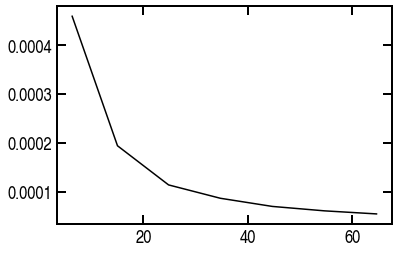

In [21]:
nmocks = 1000
nbins = 17
hf_b = (nmocks - 1.0)/(nmocks - nbins - 2.0)

fisher = []
for i, lmin in enumerate(el_bin[:7]):
    print(i, lmin)

    hf_a = (nmocks - 1.0)/(nmocks - (nbins-i) - 2.0)
    
    cov_i = cov[i:, i:]/(hf_b)*hf_a
    
    icov_i = np.linalg.inv(cov_i)
    
    fisher.append((lmin, dcl_f[i:].dot(icov_i.dot(dcl_f[i:]))))
    
fisher = np.array(fisher)
plt.plot(fisher[:, 0], fisher[:, 1])

In [20]:
el_bin[:-1]

array([  6.375     ,  15.05      ,  24.83      ,  34.73571429,
        44.68333333,  54.65      ,  64.62692308,  74.61      ,
        84.59705882,  94.58684211, 109.80227273, 129.75576923,
       149.72166667, 169.69558824, 189.675     , 225.42555556])

1e-08 -1e-08


Text(0.5, 1.0, '$10^{8}~\\partial C_{\\ell} / \\partial f_{\\rm NL}$')

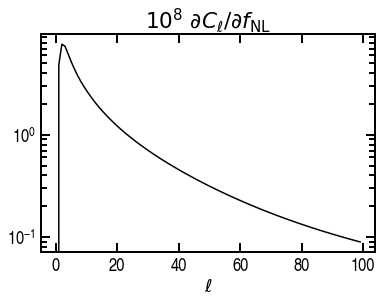

In [8]:
noise = 5.24256916e-07
el_ = np.arange(0, 100).astype('int')
fnl = 0.0
for eps in [1.0e-8, ]:
    print(fnl+eps, fnl-eps)
    m_p = model(el_, fnl=fnl+eps, noise=noise)
    m_n = model(el_, fnl=fnl-eps, noise=noise)
    plt.plot(el_, 1.0e8*(m_p-m_n)/(2*eps)), #label='eps = %3.e'%eps)
    
plt.xlabel(r'$\ell$')
plt.yscale('log')
plt.title(r'$10^{8}~\partial C_{\ell} / \partial f_{\rm NL}$')
# plt.legend(loc='upper right', fontsize=15)
# plt.savefig('dClfnl.png', dpi=300, bbox_inches='tight')

In [12]:
fnl = 0.0
eps = 1.0e-3
el_ = np.arange(el_edges.max()+1)
mp_ = model(el_, fnl+eps, noise=noise)
mn_ = model(el_, fnl-eps, noise=noise)

el_b, mp = histogram_cell(el_, mp_, bins=el_edges)
assert np.array_equal(el_b, el_bin)
mn = histogram_cell(el_, mn_, bins=el_edges)[1]

dcl = (mp-mn)/(2*eps)

['el_edges', 'el_bin', 'clcov']

In [17]:
assert np.array_equal(cl_cov['el_bin'], el_bin)

0 6.375


NameError: name 'cov' is not defined

In [41]:
fisher2 = []
for i, lmax in enumerate(el_bin[-3:]):
    ix = -3+i
    print(i, ix, lmax)
    cov_i = cov[:ix, :ix]*()*()
    icov_i = np.linalg.inv(cov_i)
    fisher2.append((lmax, dcl[:ix].dot(icov_i.dot(dcl[:ix]))))
    
fisher2 = np.array(fisher2)

0 -3 189.675
1 -2 225.42555555555555
2 -1 275.7864488808228


(0.0, 70.0)

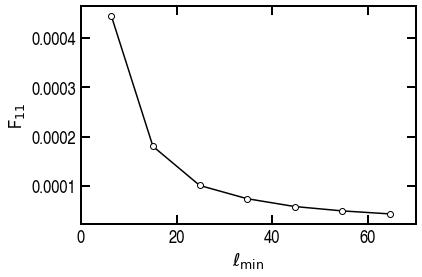

In [38]:
plt.plot(fisher[:, 0], fisher[:, 1], marker='o', mfc='w')
plt.xlabel(r'$\ell_{\rm min}$')
plt.ylabel(r'F$_{11}$')
plt.xlim(0., 70.)

Text(0, 0.5, 'F$_{11}$')

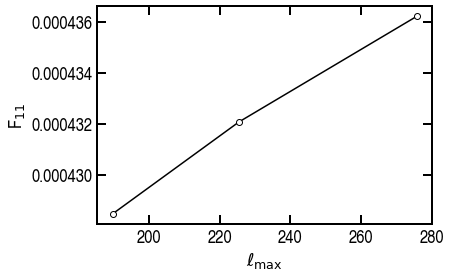

In [42]:
plt.plot(fisher2[:, 0], fisher2[:, 1], marker='o', mfc='w')
plt.xlabel(r'$\ell_{\rm max}$')
plt.ylabel(r'F$_{11}$')
# plt.xlim(0., 70.)

## Grid Search

## Test MCMC with Grid Search

In [69]:
region = 'fullsky'
#path_cl = '/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_bmzls_noweight_mean.npz'
#path_cov = '/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_bmzls_noweight_cov.npz'  
path_cl = '/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_fullsky_mean.npz'
path_cov = '/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_fullsky_cov.npz'  

el_edges, cl_obs, invcov_obs = read_inputs(path_cl, path_cov)
cov_obs = np.linalg.inv(invcov_obs)
weight, mask = read_mask(region)

z, b, dNdz = init_sample(kind='lrg')
model = SurveySpectrum()
model.add_tracer(z, b, dNdz, p=1.6)
model.add_kernels(model.el_model)
model.add_window(weight, mask, np.arange(2048), ngauss=2048)  

print('fsky', mask.mean())

lg = Posterior(model, cl_obs, invcov_obs, el_edges)
def logpost(foo):
    return -lg.logpost(foo)

t0 = time()
res = minimize(logpost, [1.0, 1.0e-7], method='Powell')
t1 = time()
print(f'best fit: {res.x}, -logprob: {res.fun:.3f} #data: {cl_obs.size} in {t1-t0:.2f} sec')

h         : 0.67556
T0_cmb    : 2.7255
Omega0_b  : 0.0482754208891869
Omega0_cdm: 0.26377065934278865
N_ur      : None
m_ncdm    : [0.06]
P_k_max   : 10.0
P_z_max   : 100.0
sigma8    : 0.8225
gauge     : synchronous
n_s       : 0.9667
nonlinear : False
p = 1.6


/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:263: RuntimeWarning: divide by zero encountered in true_divide
  fnl_f = self.alpha_fnl/(k2*self.Tlin(k))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:264: RuntimeWarning: invalid value encountered in multiply
  w_f1 = self.wfnlk1[i][1]*fnl_f
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:265: RuntimeWarning: invalid value encountered in multiply
  w_f2 = self.wfnlk2[i][1]*fnl_f
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:272: RuntimeWarning: invalid value encountered in multiply
  i_f1f1.append(self.simps(k3pk*w_f1*w_f1, lnk))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:273: RuntimeWarning: invalid value encountered in multiply
  i_f2f2.append(self.simps(k3pk*w_f2*w_f2, lnk))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:275: RuntimeWarning: invalid value encountered in multiply
  i_gf1.append(self.simps(k3pk*w_g*w_f1, lnk))
/use

fsky 1.0


/users/PHS0336/medirz90/miniconda3/envs/sysnet/lib/python3.8/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/users/PHS0336/medirz90/miniconda3/envs/sysnet/lib/python3.8/site-packages/scipy/optimize/optimize.py:2150: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


best fit: [3.88864677e-01 5.24211132e-07], -logprob: 0.006 #data: 17 in 5.66 sec


In [7]:
fnl = np.linspace(-100, 100, num=100)
noise = np.linspace(3.6, 6.6, num=100)*1.0e-7

FNL, NOISE = np.meshgrid(fnl, noise)

lpost = []
i = 0
for fi, nj in zip(FNL.flatten(), NOISE.flatten()):
    
    lpost.append(logpost((fi, nj)))
    i+=1    
    if i%1000==0:print(f'{i}/10000')
        
chi2 = np.array(lpost).reshape(100, 100)*2.0        

1000/10000
2000/10000
3000/10000
4000/10000
5000/10000
6000/10000
7000/10000
8000/10000
9000/10000
10000/10000


In [77]:

# basss/Mzls
print('fsky', mask.mean(), region)

lg = Posterior(model, cl_obs, invcov_obs, el_edges)
def logpost(foo):
    return -lg.logpost(foo)

t0 = time()
res = minimize(logpost, [1.0, 1.0e-7], method='Powell')
t1 = time()
print(f'best fit: {res.x}, -logprob: {res.fun:.3f} #data: {cl_obs.size} in {t1-t0:.2f} sec')

fsky 0.1246477762858073 bmzls


/users/PHS0336/medirz90/miniconda3/envs/sysnet/lib/python3.8/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/users/PHS0336/medirz90/miniconda3/envs/sysnet/lib/python3.8/site-packages/scipy/optimize/optimize.py:2150: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


best fit: [-1.45137962e+00  5.24256916e-07], -logprob: 0.008 #data: 17 in 7.86 sec


In [78]:
fnl = np.linspace(-100, 100, num=100)
noise = np.linspace(3.6, 6.6, num=100)*1.0e-7

FNL, NOISE = np.meshgrid(fnl, noise)

lpost = []
i = 0
for fi, nj in zip(FNL.flatten(), NOISE.flatten()):
    
    lpost.append(logpost((fi, nj)))
    i+=1    
    if i%1000==0:print(f'{i}/10000')
        
chi2b = np.array(lpost).reshape(100, 100)*2.0        

1000/10000
2000/10000
3000/10000
4000/10000
5000/10000
6000/10000
7000/10000
8000/10000
9000/10000
10000/10000


In [79]:
print(chi2.min(), chi2b.min())

0.015174659746842099 0.01715870047752751


Text(0.3, 0.65, 'BASS/MzLS')

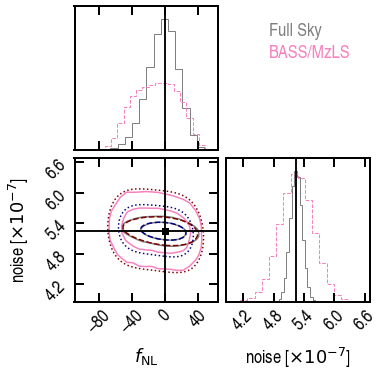

In [83]:
sample = read_chain('/fs/ess/PHS0336/data/lognormal/v0/mcmc/mcmc_lrg_fullsky_noweight_steps10000_walkers50.npz')[1]
sample1 = read_chain('/fs/ess/PHS0336/data/lognormal/v0/mcmc/mcmc_lrg_bmzls_noweight_steps10000_walkers50.npz')[1]

kw = dict(plot_datapoints=False, truths=[0.0, 5.24], truth_color='C0',
          labels=[r'$f_{\rm NL}$', r'noise [$\times 10^{-7}$]'], plot_density=False,
          fill_contours=False, levels=[0.68, 0.95])

fig = corner.corner(sample, color='grey', **kw)
corner.corner(sample1, fig=fig, color='C5', **kw)
fig.show()
ax = fig.get_axes()

# ax[2].scatter(res.x[0], res.x[1]*1.0e7, 300, 
#               marker='*', color='C1', zorder=10, alpha=0.5)

ax[2].contour(FNL, NOISE*1.0e7, chi2*1000., levels=(2300, 5990), 
              cmap='jet', linestyles='--')
ax[2].contour(FNL, NOISE*1.0e7, chi2b*1000., levels=(2300, 5990), 
              cmap='jet', linestyles=':')

plt.text(0.3, 0.8, 'Full Sky', color='grey', transform=ax[1].transAxes)
plt.text(0.3, 0.65, 'BASS/MzLS', color='C5', transform=ax[1].transAxes)

## Models vs Mocks

In [6]:
region = 'bmzls'
path_cl = '/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_bmzls_noweight_mean.npz'
path_cov = '/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_bmzls_noweight_cov.npz'  

cl_ = np.load(path_cl)
el = cl_['el_bin']

el_edges, cl_obs, invcov_obs = read_inputs(path_cl, path_cov)
cov_obs = np.linalg.inv(invcov_obs)
weight, mask = read_mask(region)

z, b, dNdz = init_sample(kind='lrg')
model = SurveySpectrum()
model.add_tracer(z, b, dNdz, p=1.6)
model.add_kernels(model.el_model)
model.add_window(weight, mask, np.arange(2048), ngauss=2048)  

h         : 0.67556
T0_cmb    : 2.7255
Omega0_b  : 0.0482754208891869
Omega0_cdm: 0.26377065934278865
N_ur      : None
m_ncdm    : [0.06]
P_k_max   : 10.0
P_z_max   : 100.0
sigma8    : 0.8225
gauge     : synchronous
n_s       : 0.9667
nonlinear : False
p = 1.6


/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:263: RuntimeWarning: divide by zero encountered in true_divide
  fnl_f = self.alpha_fnl/(k2*self.Tlin(k))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:264: RuntimeWarning: invalid value encountered in multiply
  w_f1 = self.wfnlk1[i][1]*fnl_f
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:265: RuntimeWarning: invalid value encountered in multiply
  w_f2 = self.wfnlk2[i][1]*fnl_f
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:272: RuntimeWarning: invalid value encountered in multiply
  i_f1f1.append(self.simps(k3pk*w_f1*w_f1, lnk))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:273: RuntimeWarning: invalid value encountered in multiply
  i_f2f2.append(self.simps(k3pk*w_f2*w_f2, lnk))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:275: RuntimeWarning: invalid value encountered in multiply
  i_gf1.append(self.simps(k3pk*w_g*w_f1, lnk))
/use

In [22]:
region = 'bmzls'
path_cl = '/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_bmzls_noweight_mean.npz'
path_cov = '/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_bmzls_noweight_cov.npz'  

cl_ = np.load(path_cl)
el = cl_['el_bin']
el_edges = cl_['el_edges']

In [23]:
el_ = np.arange(0, el_edges.max()+10).astype('int')

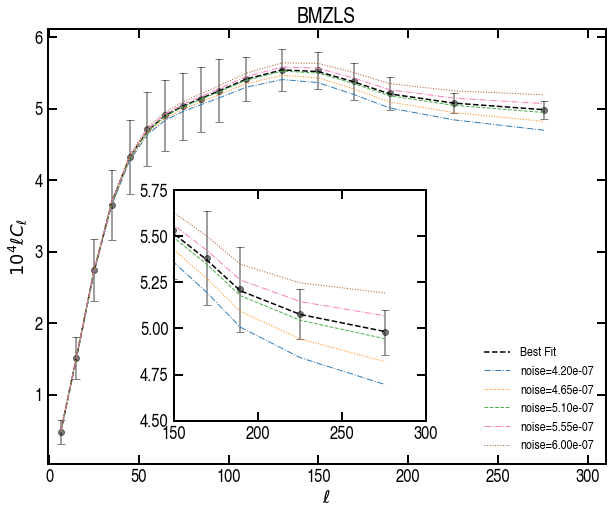

In [24]:
plt.figure(figsize=(10, 8))
plt.title(region.upper())

def plot():
    f = 1.0e4
    params = [-1.45137962e+00,  5.24256916e-07]
    
    plt.errorbar(el, f*el*cl_obs, yerr=f*el*np.diag(cov_obs)**0.5, 
                 marker='o', alpha=0.5, ls='none', capsize=4, zorder=-10)
    
    el_b, cl_b = histogram_cell(el_, model(el_, *params), bins=el_edges)
    
    plt.plot(el_b, f*el_b*cl_b, label='Best Fit', color='k')
    #for fnl in [100, 40., 20, 10, 0., -10., -20., -40., -100]:
    #    plt.plot(el_, model(el_, fnl, noise=res.x[1]), 
    #             lw=1, label=f'fnl=%.f'%fnl)
    
    for nois in np.linspace(4.2e-7, 6.0e-7, num=5):
        el_b, cl_b = histogram_cell(el_, model(el_, 0.0, nois), bins=el_edges)        
        plt.plot(el_b, f*el_b*cl_b, lw=1, label=f'noise=%.2e'%nois)
    

# plt.ylim(-1, 2.e2)        
plt.xlim(-1, 310)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$10^{4}\ell C_{\ell}$')
plot()
plt.legend()
plt.axes([0.3, 0.2, 0.35, 0.4])
plot()
plt.xlim(150, 300)
plt.ylim(4.5, 5.75)
# plt.yticks([0.0, 1.0e-5], labels=['0', '1.0e-5'])

plt.savefig('bmzls_model_meanmocks_noise.png', dpi=300, bbox_inches='tight')

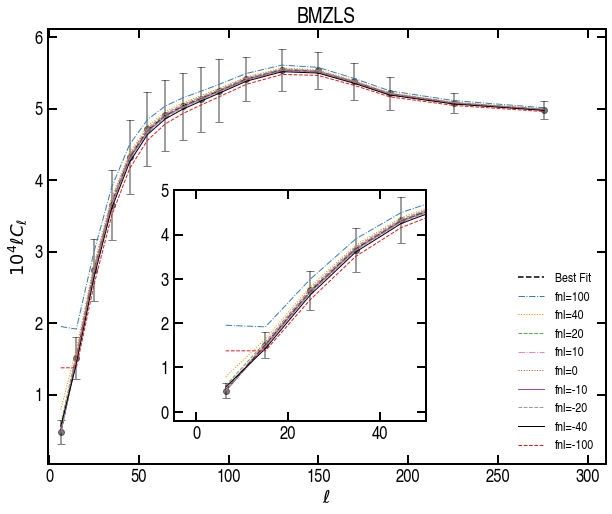

In [28]:
plt.figure(figsize=(10, 8))
plt.title(region.upper())

def plot():
    f = 1.0e4
    params = [-1.45137962e+00,  5.24256916e-07]
    
    plt.errorbar(el, f*el*cl_obs, yerr=f*el*np.diag(cov_obs)**0.5, 
                 marker='o', alpha=0.5, ls='none', capsize=4, zorder=-10)
    
    el_b, cl_b = histogram_cell(el_, model(el_, *params), bins=el_edges)    
    plt.plot(el_b, f*el_b*cl_b, label='Best Fit', color='k')
    
    for fnl in [100, 40., 20, 10, 0., -10., -20., -40., -100]:
        el_b, cl_b = histogram_cell(el_, model(el_, fnl, noise=params[1]), bins=el_edges)
        
        plt.plot(el_b, f*el_b*cl_b, 
                 lw=1, label=f'fnl=%.f'%fnl)
    #for nois in np.linspace(4.2e-7, 6.0e-7, num=5):
    #       plt.plot(el_, f*el_*model(el_, 0.0, nois), lw=1, label=f'noise=%.2e'%nois)
    

# plt.ylim(-1, 2.e2)        
plt.xlim(-1, 310)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$10^{4}\ell C_{\ell}$')
plot()
plt.legend()
plt.axes([0.3, 0.2, 0.35, 0.4])
plot()
plt.xlim(-5, 50)
plt.ylim(-0.2, 5.)
# plt.yticks([0.0, 1.0e-5], labels=['0', '1.0e-5'])

plt.savefig('bmzls_model_meanmocks_fnl.png', dpi=300, bbox_inches='tight')

## MCMC Comparison
### Full Sky vs BASS/MzLS

In [9]:
st = {}
st['BMzLS'], sbmzls = read_chain('/fs/ess/PHS0336/data/lognormal/v0/mcmc/mcmc_lrg_bmzls_noweight_steps10000_walkers50.npz')
st['FullSky'], sfullsky = read_chain('/fs/ess/PHS0336/data/lognormal/v0/mcmc/mcmc_lrg_fullsky_noweight_steps10000_walkers50.npz')

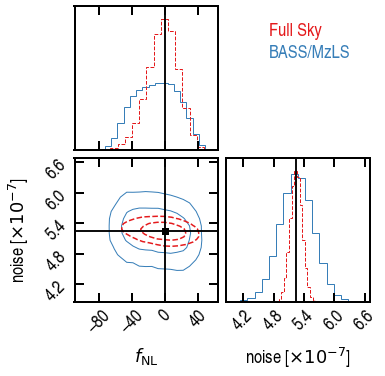

In [19]:
kw = dict(plot_datapoints=False, truths=[0.0, 5.24], truth_color='C0',
          labels=[r'$f_{\rm NL}$', r'noise [$\times 10^{-7}$]'], plot_density=False,
          fill_contours=False, levels=[0.68, 0.95])

fig = corner.corner(sbmzls, color='C2', contour_kwargs={'linewidths':1.}, hist_kwargs={'lw':1.}, **kw)
corner.corner(sfullsky, fig=fig, color='C1', contour_kwargs={'linestyles':'--'}, **kw)

plt.text(0.3, 0.8, 'Full Sky', color='C1', transform=fig.get_axes()[1].transAxes)
plt.text(0.3, 0.65, 'BASS/MzLS', color='C2', transform=fig.get_axes()[1].transAxes)
plt.show()

In [53]:
pstats = pd.DataFrame(stats,
                      index=['MAP [scipy]', 'MAP [chain]', 'Mean [chain]',
                             'Median [chain]', '16th', '84th']).T
pstats

MAP [scipy]  MAP [chain]  Mean [chain]  Median [chain]       16th  \
BMzLS      -1.451380    -1.436837    -10.756423      -10.277699 -39.104397   
FullSky     0.388865     0.410934     -2.757701       -1.741715 -21.032992   

              84th  
BMzLS    17.304460  
FullSky  15.569709

In [74]:
## ratio of 68% region vs sqrt(fsky)
(17.30+39.10)/(15.57+21.03), 1/np.sqrt(0.1246477762858073)

(1.5409836065573772, 2.8324205225759966)

In [6]:
st = {}
st['BMzLS'], sbmzls = read_chain('/fs/ess/PHS0336/data/lognormal/v0/mcmc/mcmc_lrg_bmzls_noweight_steps10000_walkers50_fine.npz')
st['FullSky'], sfullsky = read_chain('/fs/ess/PHS0336/data/lognormal/v0/mcmc/mcmc_lrg_fullsky_noweight_steps10000_walkers50_fine.npz')

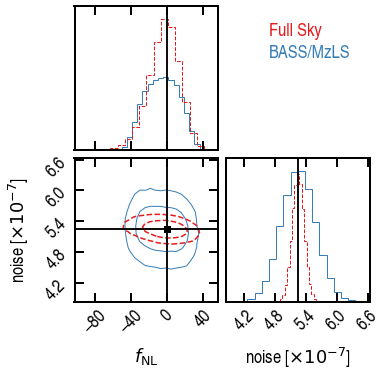

In [7]:
kw = dict(plot_datapoints=False, truths=[0.0, 5.24], truth_color='C0',
          labels=[r'$f_{\rm NL}$', r'noise [$\times 10^{-7}$]'], plot_density=False,
          fill_contours=False, levels=[0.68, 0.95])

fig = corner.corner(sbmzls, color='C2', contour_kwargs={'linewidths':1.}, hist_kwargs={'lw':1.}, **kw)
corner.corner(sfullsky, fig=fig, color='C1', contour_kwargs={'linestyles':'--'}, **kw)

plt.text(0.3, 0.8, 'Full Sky', color='C1', transform=fig.get_axes()[1].transAxes)
plt.text(0.3, 0.65, 'BASS/MzLS', color='C2', transform=fig.get_axes()[1].transAxes)
plt.show()

In [10]:
pst = pd.DataFrame(st,
                      index=['MAP [scipy]', 'MAP [chain]', 'Mean [chain]',
                             'Median [chain]', '16th', '84th']).T
pst

MAP [scipy]  MAP [chain]  Mean [chain]  Median [chain]       16th  \
BMzLS      -2.324382    -2.294943     -5.377511       -5.198558 -24.956219   
FullSky     0.017285     0.020031     -3.224534       -2.086524 -19.751264   

              84th  
BMzLS    14.052735  
FullSky  13.441798

In [11]:
## ratio of 68% region vs sqrt(fsky)
(14.05+24.96)/(13.44+19.75), 1/np.sqrt(0.1246477762858073)

(1.1753540222958725, 2.8324205225759966)

In [29]:
def read_cl(path_cl, path_cov):
    cl_ = np.load(path_cl)
    ccl_ = np.load(path_cov)

    return (cl_['el_bin'], cl_['cl'], np.diag(ccl_['clcov'])**0.5)

path_cl = '/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_bmzls_noweight_mean.npz'
path_cov = '/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_bmzls_noweight_cov.npz'    

cl_list = {}
cl_list['fiducial binning'] = read_cl(path_cl, path_cov)    
cl_list['fine binning'] = read_cl(path_cl.replace('.npz', '_fine.npz'),
                                path_cov.replace('.npz', '_fine.npz'))

Text(0, 0.5, '$10^{5} C_\\ell$')

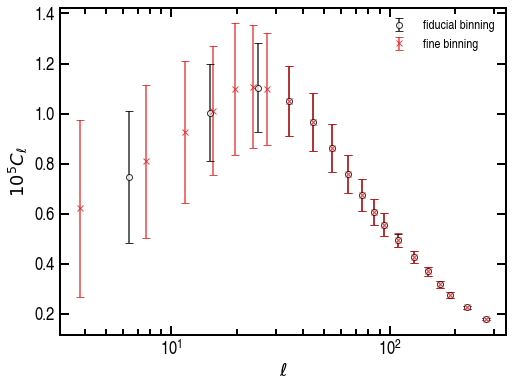

In [30]:
plt.figure(figsize=(8, 6))
mk = ['o', 'x']
for i, (n,v) in enumerate(cl_list.items()):
    plt.errorbar(v[0], v[1]*1.0e5, yerr=v[2]*1.0e5, 
                 capsize=4, ls='None', marker=mk[i], mfc='w', alpha=0.8, label=n)
    
plt.xscale('log')
plt.legend()
plt.xlabel(r'$\ell$')
plt.ylabel(r'$10^{5} C_\ell$')

# Best Fit Finder
Here we setup the best fit finder code

In [5]:
def read_inputs(path_cl, path_cov):
    
    dcl_obs = np.load(path_cl)
    dclcov_obs = np.load(path_cov)
    assert np.array_equal(dcl_obs['el_edges'], dclcov_obs['el_edges'])
    
    el_edges = dcl_obs['el_edges']
    cl_obs = dcl_obs['cl']
    invcov_obs = np.linalg.inv(dclcov_obs['clcov'])

    return el_edges, cl_obs, invcov_obs

def read_mask(region):

    import fitsio as ft
    import healpy as hp
    from lssutils.utils import make_hp

    if region in ['bmzls', 'ndecals', 'sdecals']:
        # read survey geometry
        data_path = '/fs/ess/PHS0336/data/'    
        dt = ft.read(f'{data_path}/rongpu/imaging_sys/tables/v3/nlrg_features_{region}_256.fits')
        mask_  = make_hp(256, dt['hpix'], 1.0) > 0.5
        mask   = hp.ud_grade(mask_, 1024)
    else:
        # full sky
        mask = np.ones(12*1024*1024, '?')

    return mask*1.0, mask

In [7]:
def run_bestfit(path_cl, path_cov, region):
    el_edges, cl_obs, invcov_obs = read_inputs(path_cl, path_cov)
    cov_obs = np.linalg.inv(invcov_obs)
    weight, mask = read_mask(region)

    z, b, dNdz = init_sample(kind='lrg')
    model = SurveySpectrum()
    model.add_tracer(z, b, dNdz, p=1.6)
    model.add_kernels(model.el_model)
    model.add_window(weight, mask, np.arange(2048), ngauss=2048)  
    
    lg = Posterior(model, cl_obs, invcov_obs, el_edges)
    def logpost(foo):
        return -lg.logpost(foo)
    
    t0 = time()
    res = minimize(logpost, [1.0, 1.0e-7], method='Powell')
    t1 = time()
    print(f'best fit: {res.x}, -logprob: {res.fun:.3f} #data: {cl_obs.size} in {t1-t0:.2f} sec')
    
    el_ = np.arange(el_edges.min(), el_edges.max()+1)
    cl_m_ = model(el_, *res.x)
    el, cl_m = histogram_cell(el_, cl_m_, bins=el_edges)
    
    plt.figure(figsize=(8, 6))
    plt.title(region.upper())
    plt.errorbar(el, cl_obs, yerr=np.diag(cov_obs)**0.5, 
                 marker='o', alpha=0.2, ls='none', capsize=4, zorder=-10)
    plt.plot(el_, cl_m_, label='Best Fit', color='k')
    for fnl in [10, 0., -10.]:
        plt.plot(el_, model(el_, fnl, noise=res.x[1]), 
                 lw=1, label=f'fnl=%.f'%fnl)
    plt.xscale('log')
    plt.legend()
    plt.xlabel(r'$\ell$')
    plt.ylabel(r'$C_{\ell}$')
    plt.ylim(0.0, 1.4e-5)

h         : 0.67556
T0_cmb    : 2.7255
Omega0_b  : 0.0482754208891869
Omega0_cdm: 0.26377065934278865
N_ur      : None
m_ncdm    : [0.06]
P_k_max   : 10.0
P_z_max   : 100.0
sigma8    : 0.8225
gauge     : synchronous
n_s       : 0.9667
nonlinear : False
p = 1.6


/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:263: RuntimeWarning: divide by zero encountered in true_divide
  fnl_f = self.alpha_fnl/(k2*self.Tlin(k))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:264: RuntimeWarning: invalid value encountered in multiply
  w_f1 = self.wfnlk1[i][1]*fnl_f
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:265: RuntimeWarning: invalid value encountered in multiply
  w_f2 = self.wfnlk2[i][1]*fnl_f
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:272: RuntimeWarning: invalid value encountered in multiply
  i_f1f1.append(self.simps(k3pk*w_f1*w_f1, lnk))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:273: RuntimeWarning: invalid value encountered in multiply
  i_f2f2.append(self.simps(k3pk*w_f2*w_f2, lnk))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:275: RuntimeWarning: invalid value encountered in multiply
  i_gf1.append(self.simps(k3pk*w_g*w_f1, lnk))
/use

best fit: [-1.45137962e+00  5.24256916e-07], -logprob: 0.008 #data: 17 in 9.07 sec


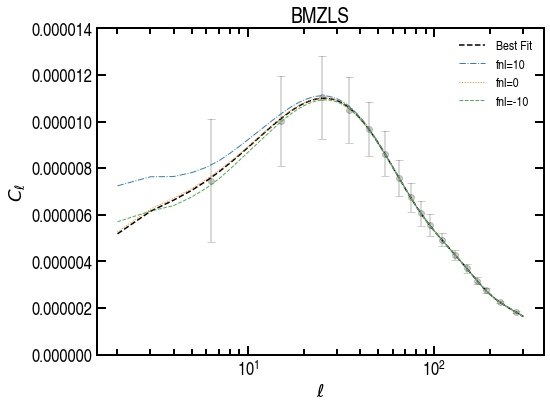

In [8]:
path_cl = '/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_bmzls_noweight_mean.npz'
path_cov = '/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_bmzls_noweight_cov.npz'
region = 'bmzls'
run_bestfit(path_cl, path_cov, region)

h         : 0.67556
T0_cmb    : 2.7255
Omega0_b  : 0.0482754208891869
Omega0_cdm: 0.26377065934278865
N_ur      : None
m_ncdm    : [0.06]
P_k_max   : 10.0
P_z_max   : 100.0
sigma8    : 0.8225
gauge     : synchronous
n_s       : 0.9667
nonlinear : False
p = 1.6


/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:263: RuntimeWarning: divide by zero encountered in true_divide
  fnl_f = self.alpha_fnl/(k2*self.Tlin(k))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:264: RuntimeWarning: invalid value encountered in multiply
  w_f1 = self.wfnlk1[i][1]*fnl_f
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:265: RuntimeWarning: invalid value encountered in multiply
  w_f2 = self.wfnlk2[i][1]*fnl_f
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:272: RuntimeWarning: invalid value encountered in multiply
  i_f1f1.append(self.simps(k3pk*w_f1*w_f1, lnk))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:273: RuntimeWarning: invalid value encountered in multiply
  i_f2f2.append(self.simps(k3pk*w_f2*w_f2, lnk))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:275: RuntimeWarning: invalid value encountered in multiply
  i_gf1.append(self.simps(k3pk*w_g*w_f1, lnk))
/use

best fit: [3.88864677e-01 5.24211132e-07], -logprob: 0.006 #data: 17 in 6.60 sec


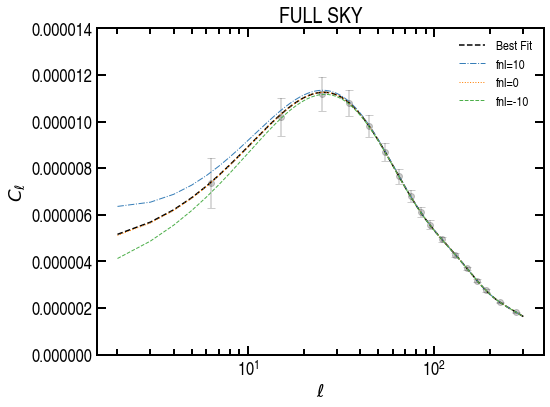

In [9]:
path_cl = '/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_fullsky_mean.npz'
path_cov = '/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_fullsky_cov.npz'
region = 'Full Sky'
run_bestfit(path_cl, path_cov, region)

## Model vs Data

In [5]:
def make_cl4partialsky(r, m):
    
    #ell_edges = np.array([2] + [10*i for i in range(1,10)] + [100+i*20 for i in range(5)] + [200+i*50 for i in range(3)])
    ell_edges = np.array([2, 6, 10, 14, 18, 22, 26] + [10*i for i in range(3,10)] + [100+i*20 for i in range(5)] + [200+i*50 for i in range(3)])

    mocks = glob(f'/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_*_lrg_{r}_256_{m}.npy')
    print(len(mocks))
    print(ell_edges)

    cl_mocks = []
    for mock in mocks:
        d = np.load(mock, allow_pickle=True).item()['cl_gg']
        el = d['l']
        cl = d['cl']
        el_bin, cl_bin = histogram_cell(el, cl, bins=ell_edges)
        cl_mocks.append(cl_bin)
        print('.', end='')

    cl_mocks = np.array(cl_mocks)

    nmocks, nbins = cl_mocks.shape
    hf = (nmocks - 1.0)/(nmocks - nbins - 2.0)
    cl_cov = np.cov(cl_mocks, rowvar=False)*hf #/ nmocks
    #inv_cov = np.linalg.inv(cl_cov)
    print(f'Hartlap with #mocks ({nmocks}) and #bins ({nbins}): {hf:.2f}' )

    #np.savez(f'/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_{r}_{m}_mean.npz',
    np.savez(f'/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_{r}_{m}_mean_fine.npz',
        **{'el_edges':ell_edges, 'el_bin':el_bin, 'cl':cl_mocks.mean(axis=0)})

    #np.savez(f'/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_{r}_{m}_cov.npz',
    np.savez(f'/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_{r}_{m}_cov_fine.npz',
        **{'el_edges':ell_edges, 'el_bin':el_bin, 'clcov':cl_cov})

In [6]:
for r in ['bmzls']:
    for m in ['noweight']: #, 'lin', 'nn']:
        make_cl4partialsky(r, m)

1000
[  2   6  10  14  18  22  26  30  40  50  60  70  80  90 100 120 140 160
 180 200 250 300]
........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [6]:
#ell_edges = np.arange(2, 312, 10)
#ell_edges = np.array([2] + [10*i for i in range(1,10)] + [100+i*20 for i in range(5)] + [200+i*50 for i in range(3)])
ell_edges = np.array([2, 6, 10, 14, 18, 22, 26] \
                     + [10*i for i in range(3,10)] \
                     + [100+i*20 for i in range(5)] \
                     + [200+i*50 for i in range(3)])
    
cl_mocks = np.load('/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_fullsky.npy')
ell = np.arange(cl_mocks.shape[1])
cl_mocks_binned = []
for cl_i in cl_mocks:
    ell_bin, cl_bin = histogram_cell(ell, cl_i, bins=ell_edges)
    cl_mocks_binned.append(cl_bin)
    print('.', end='')
cl_mocks_binned = np.array(cl_mocks_binned)

nmocks, nbins = cl_mocks_binned.shape
hf = (nmocks - 1.0)/(nmocks - nbins - 2.0)
cl_cov = np.cov(cl_mocks_binned, rowvar=False)*hf #/ nmocks
inv_cov = np.linalg.inv(cl_cov)
print(f'Hartlap with #mocks ({nmocks}) and #bins ({nbins}): {hf:.2f}' )


#np.savez('/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_fullsky_mean.npz',
np.savez('/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_fullsky_mean_fine.npz',
     **{'el_edges':ell_edges, 'el_bin':ell_bin, 'cl':cl_mocks_binned.mean(axis=0)})

np.savez('/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_fullsky_cov_fine.npz',
     **{'el_edges':ell_edges, 'el_bin':ell_bin, 'clcov':cl_cov})

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [9]:
np.percentile(cl_cov, [1, 99])

array([-7.60773266e-14,  1.42958963e-12])

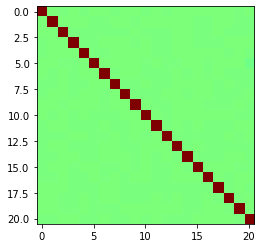

In [15]:
plt.imshow(cl_cov.dot(inv_cov), cmap='jet', vmin=-1.0e-13, vmax=1.0e-13)

h         : 0.67556
T0_cmb    : 2.7255
Omega0_b  : 0.0482754208891869
Omega0_cdm: 0.26377065934278865
N_ur      : None
m_ncdm    : [0.06]
P_k_max   : 10.0
P_z_max   : 100.0
sigma8    : 0.8225
gauge     : synchronous
n_s       : 0.9667
nonlinear : False
p = 1.6


/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:263: RuntimeWarning: divide by zero encountered in true_divide
  fnl_f = self.alpha_fnl/(k2*self.Tlin(k))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:264: RuntimeWarning: invalid value encountered in multiply
  w_f1 = self.wfnlk1[i][1]*fnl_f
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:265: RuntimeWarning: invalid value encountered in multiply
  w_f2 = self.wfnlk2[i][1]*fnl_f
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:272: RuntimeWarning: invalid value encountered in multiply
  i_f1f1.append(self.simps(k3pk*w_f1*w_f1, lnk))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:273: RuntimeWarning: invalid value encountered in multiply
  i_f2f2.append(self.simps(k3pk*w_f2*w_f2, lnk))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:275: RuntimeWarning: invalid value encountered in multiply
  i_gf1.append(self.simps(k3pk*w_g*w_f1, lnk))
/use

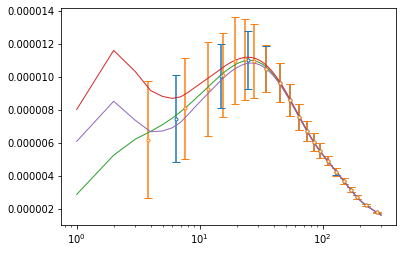

In [17]:
clmocks = {}
clmocks['mean'] = np.load('/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_bmzls_noweight_mean.npz')
clmocks['cov'] = np.load('/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_bmzls_noweight_cov.npz')
clmocks['mean_fine'] = np.load('/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_bmzls_noweight_mean_fine.npz')
clmocks['cov_fine'] = np.load('/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_bmzls_noweight_cov_fine.npz')

d_ = ft.read('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/v3/nlrg_features_bmzls_256.fits')
w_ = make_hp(256, d_['hpix'], 1.0) > 0.5
ww = hp.ud_grade(w_, 1024)

z, b, dNdz = init_sample(kind='lrg')
model = SurveySpectrum()
model.add_tracer(z, b, dNdz, p=1.6)
model.add_kernels(model.el_model)
model.add_window(ww*1.0, ww, np.arange(2048), ngauss=2048)  

el_g = np.arange(1, 300)

for m in ['', '_fine']:
    cl_ = clmocks['mean'+m]['cl']
    el_ = clmocks['mean'+m]['el_bin']
    clcov_ = clmocks['cov'+m]['clcov']

    plt.errorbar(el_, cl_, yerr=np.diag(clcov_)**0.5, capsize=4, marker='.', mfc='w', ls='none')

plt.plot(el_g, model(el_g, fnl=0.0, noise=5.24e-7), lw=1)
plt.plot(el_g, model(el_g, fnl=20.0, noise=5.24e-7), lw=1)
plt.plot(el_g, model(el_g, fnl=-20.0, noise=5.24e-7), lw=1)
plt.xscale('log')
# plt.yscale('log')

## Fiducial Binning

In [9]:
for r in ['bmzls', 'ndecals', 'sdecals']:
    for m in ['noweight', 'lin', 'nn']:
        make_cl4partialsky(r, m)

1000
...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [5]:
dcl_obs = np.load('/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_bmzls_lin_mean.npz')
dclcov_obs = np.load('/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_bmzls_noweight_cov.npz')

cl_obs2 = dcl_obs['cl']
el_obs2 = dcl_obs['el_bin']
cl_cov2 = dclcov_obs['clcov']

In [7]:
d_ = ft.read('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/v3/nlrg_features_bmzls_256.fits')
w_ = make_hp(256, d_['hpix'], 1.0) > 0.5
ww = hp.ud_grade(w_, 1024)

In [9]:
z, b, dNdz = init_sample(kind='lrg')

model = SurveySpectrum()
model.add_tracer(z, b, dNdz, p=1.6)
model.add_kernels(model.el_model)
model.add_window(ww*1.0, ww, np.arange(2048), ngauss=2048)  

h         : 0.67556
T0_cmb    : 2.7255
Omega0_b  : 0.0482754208891869
Omega0_cdm: 0.26377065934278865
N_ur      : None
m_ncdm    : [0.06]
P_k_max   : 10.0
P_z_max   : 100.0
sigma8    : 0.8225
gauge     : synchronous
n_s       : 0.9667
nonlinear : False
p = 1.6


/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:263: RuntimeWarning: divide by zero encountered in true_divide
  fnl_f = self.alpha_fnl/(k2*self.Tlin(k))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:264: RuntimeWarning: invalid value encountered in multiply
  w_f1 = self.wfnlk1[i][1]*fnl_f
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:265: RuntimeWarning: invalid value encountered in multiply
  w_f2 = self.wfnlk2[i][1]*fnl_f
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:272: RuntimeWarning: invalid value encountered in multiply
  i_f1f1.append(self.simps(k3pk*w_f1*w_f1, lnk))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:273: RuntimeWarning: invalid value encountered in multiply
  i_f2f2.append(self.simps(k3pk*w_f2*w_f2, lnk))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:275: RuntimeWarning: invalid value encountered in multiply
  i_gf1.append(self.simps(k3pk*w_g*w_f1, lnk))
/use

In [11]:
ell_edges = np.array([2] + [10*i for i in range(1,10)] + [100+i*20 for i in range(5)] + [200+i*50 for i in range(3)])
cl_model = model(np.arange(768), 0.0, noise=5.24e-7)
cl_model_binned = histogram_cell(np.arange(cl_model.size), cl_model, bins=ell_edges)[1]

fnl, b 0.0 1.0


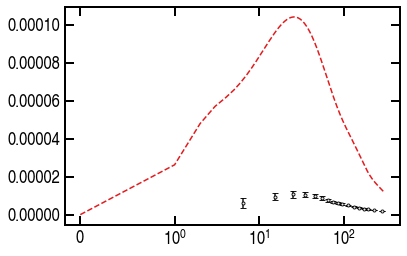

In [18]:
plt.errorbar(el_obs2, cl_obs2, yerr=np.diagonal(cl_cov2)**0.5,
             marker='.', mfc='w', ls='none', capsize=3, alpha=0.9)

# plt.errorbar(el_bin, cl_mocks.mean(axis=0), yerr=np.diagonal(cl_cov)**0.5,
#              marker='.', mfc='w', ls='none', capsize=3, alpha=0.9)

plt.plot(cl_model[:300])
# plt.plot(el_bin, cl_model_binned)
plt.xscale('symlog', linthreshx=1)

In [15]:
# cl_obs = cl_mocks.mean(axis=0)

inv_cov = np.linalg.inv(cl_cov2)

res = cl_obs2 - cl_model_binned
print(0.5*res.dot(inv_cov.dot(res)), res.shape)

133220.22817101126 (17,)


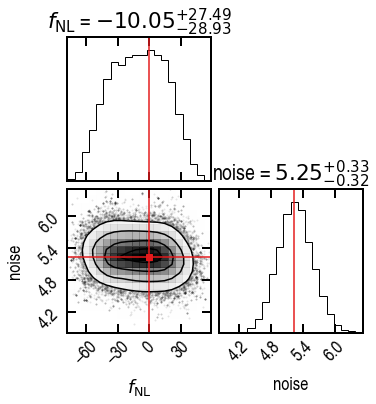

In [12]:
# sample = chains[5000:, :, :].flatten().reshape(-1, 2)
# sample[:, 1] *= 1.0e7
chains = np.load('/fs/ess/PHS0336/data/lognormal/v0/mcmc/mcmc_lrg_bmzls_noweight_10000.npy')
print(chains.shape)

fg, ax = plt.subplots(nrows=2, figsize=(10, 10), sharex=True)
fg.subplots_adjust(hspace=0.0)

for i in range(10):
    ax[0].plot(chains[:, i, 0], ls='-', lw=0.2)
    ax[1].plot(chains[:, i, 1], ls='-', lw=0.2)
        
ax[0].set(ylabel=r'$f_{\rm NL}$')
ax[1].set(xlabel='step', ylabel='noise')
plt.show()

sample = chains[5000:, :, :].flatten().reshape(-1, 2)
sample[:, 1] *= 1.0e7
corner.corner(sample, smooth=True, show_titles=True, #quantiles=(0.16, 0.84), levels=(0.393, 0.68, 0.95), 
              labels=[r'$f_{\rm NL}$', r'noise'], truths=[0.0, 5.24], truth_color='C1',)
plt.show()

In [13]:
dt = ft.read('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/v3/nlrg_features_bmzls_256.fits')

In [24]:
dt['label'].size / (12*256*256)

0.1246477762858073

In [32]:
58.15/36.24, 1./np.sqrt(0.1246477762858)

(1.6045805739514347, 2.8324205225760797)

In [13]:
chains2 = np.load('/fs/ess/PHS0336/data/lognormal/v0/mcmc/mcmc_lrg_fullsky_noweight_10000.npy')
print(chains2.shape)

sample2 = chains2[5000:, :, :].flatten().reshape(-1, 2)
sample2[:, 1] *= 1.0e7

(10000, 10, 2)


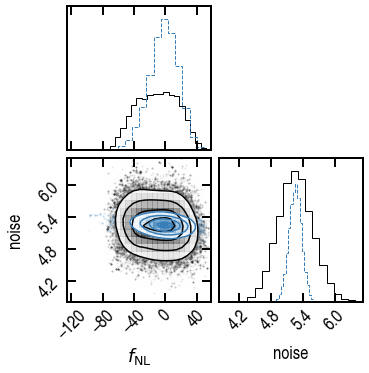

In [14]:
fig = corner.corner(sample, smooth=True, )
corner.corner(sample2, smooth=True, fig=fig, color='C2', 
              labels=[r'$f_{\rm NL}$', r'noise'])
plt.show()

dict_keys(['bmzls_nn', 'bmzls_lin', 'bmzls_noweight', 'ndecals_nn', 'ndecals_lin', 'ndecals_noweight', 'sdecals_nn', 'sdecals_lin', 'sdecals_noweight'])


[Text(0, 0.5, '$f_{\\rm NL}$')]

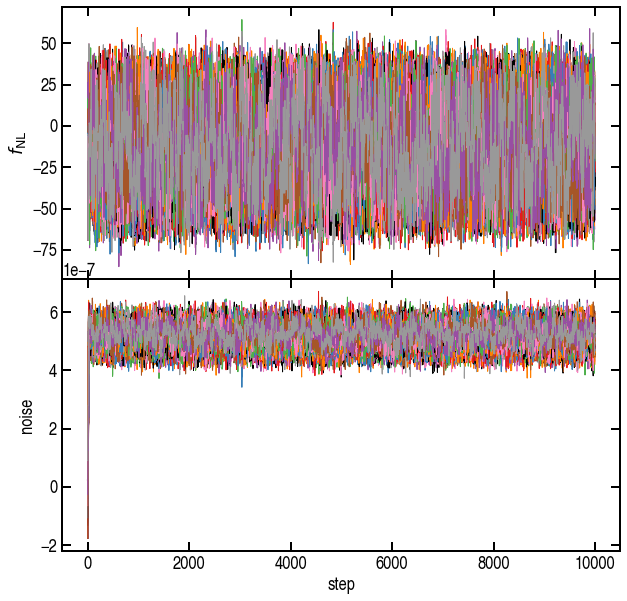

In [5]:
regions = ['bmzls', 'ndecals', 'sdecals']
methods = ['nn', 'lin', 'noweight']

chains = {}
for r in regions:
    for m in methods:
        #chains[f'{r}_{m}_1k'] = np.load(f'/fs/ess/PHS0336/data/lognormal/v0/mcmc/mcmc_lrg_{r}_{m}_steps1k.npy')
        chains[f'{r}_{m}'] = np.load(f'/fs/ess/PHS0336/data/lognormal/v0/mcmc/mcmc_lrg_{r}_{m}_10000.npy')
        
print(chains.keys())


fg, ax = plt.subplots(nrows=2, figsize=(10, 10), sharex=True)
fg.subplots_adjust(hspace=0.0)
for m in chains:
    for i in range(10):
        ln = ax[0].plot(chains[m][:, i, 0], ls='-', lw=1)
        ax[1].plot(chains[m][:, i, 1], ls='-', lw=1)
        
ax[1].set(xlabel='step', ylabel='noise')
ax[0].set(ylabel=r'$f_{\rm NL}$')

bmzls_nn 39.37
bmzls_lin 49.82
bmzls_noweight 58.40
ndecals_nn 34.38
ndecals_lin 46.13
ndecals_noweight 54.58
sdecals_nn 35.43
sdecals_lin 47.19
sdecals_noweight 55.34


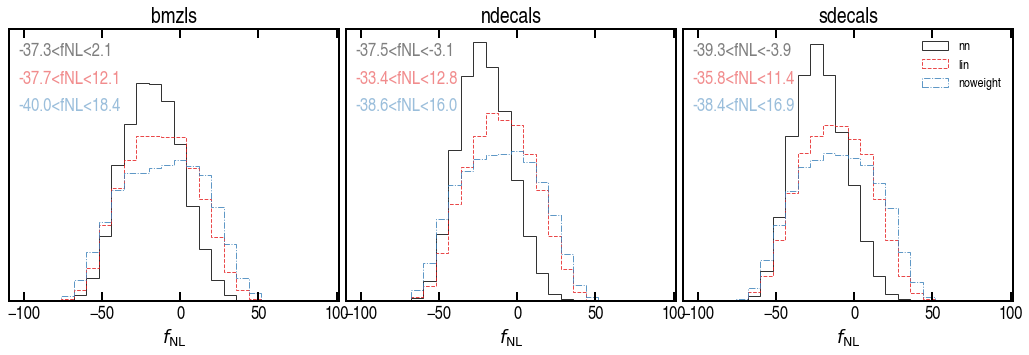

In [6]:
skip = 5000

colors = ['C0', 'C1', 'C2']

fg, ax = plt.subplots(ncols=3, figsize=(18, 5), sharey=True, sharex=True)
fg.subplots_adjust(wspace=0.02) 

for i, r in enumerate(regions):
    
    
    for j, m in enumerate(methods):
        
        k = f'{r}_{m}'
        v = chains[k][skip:, :, 0].flatten()
        vmin, vmax = np.percentile(v, [15, 85])
        print(k, '%.2f'%(vmax - vmin))
        h = ax[i].hist(v, alpha=0.8, histtype='step', 
                       label=m, zorder=-10, color=colors[j], bins=np.arange(-100, 100., 8.))
        
        ax[i].text(0.03, 0.9-0.1*j, '{0:.1f}<fNL<{1:.1f}'.format(*np.percentile(v, [15, 85])),
                   alpha=0.5, color=colors[j], transform=ax[i].transAxes)
        
    ax[i].set(title=r, xlabel=r'$f_{\rm NL}$', yticks=[])

ax[2].legend(loc='upper right')

In [5]:
import seaborn as sns

Text(0.5, 0, '$f_{\\rm NL}$')

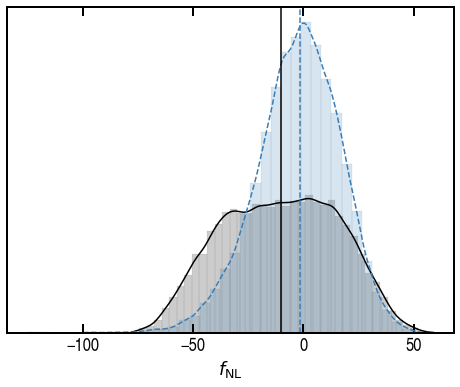

In [16]:
fg, ax = plt.subplots(figsize=(8, 6))

sns.histplot(sample[:, 0], bins=40, kde=True, color='C0', ax=ax, alpha=0.2, lw=0.05)
sns.histplot(sample2[:, 0], bins=40, kde=True, ax=ax, color='C2', alpha=0.2, lw=0.05)

ax.axvline(np.median(sample2[:, 0]), color='C2', ls='--')
ax.axvline(np.median(sample[:, 0]), color='C0', ls='-')
ax.set_yticks([])
ax.set_ylabel('')
ax.set_xlabel(r'$f_{\rm NL}$')
# plt.axvline(0.0)

In [6]:
chains = np.load('/fs/ess/PHS0336/data/lognormal/v0/mcmc/mcmc_lrg_bmzls_nn_10000_50walkers.npy')
print(chains.shape)

sample = chains[5000:, :, :].flatten().reshape(-1, 2)
sample[:, 1] *= 1.0e7


chains2 = np.load('/fs/ess/PHS0336/data/lognormal/v0/mcmc/mcmc_lrg_bmzls_nn_10000.npy')
print(chains2.shape)

sample2 = chains2[5000:, :, :].flatten().reshape(-1, 2)
sample2[:, 1] *= 1.0e7

(10000, 50, 2)
(10000, 10, 2)


Text(0.5, 0, '$f_{\\rm NL}$')

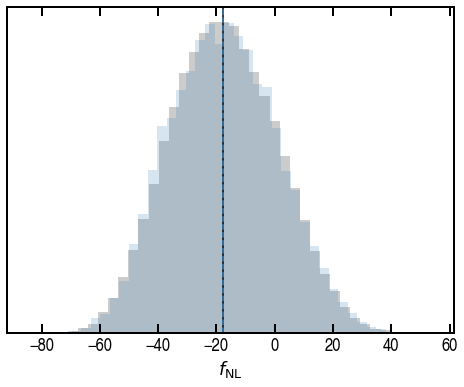

In [11]:
fg, ax = plt.subplots(figsize=(8, 6))

ax.hist(sample[:, 0], bins=40, color='C0', alpha=0.2, density=True)
ax.hist(sample2[:, 0], bins=40,color='C2', alpha=0.2, density=True)

ax.axvline(np.median(sample[:, 0]), color='C0', ls='-')
ax.axvline(np.median(sample2[:, 0]), color='C2', ls='--')
ax.set_yticks([])
ax.set_ylabel('')
ax.set_xlabel(r'$f_{\rm NL}$')
# plt.axvline(0.0)

### Full Sky Lognormal

In [5]:
chains = np.load('/fs/ess/PHS0336/data/lognormal/v0/mcmc/mcmc_lrg_fullsky_noweight_1000.npy')
chains.shape

(1000, 10, 2)

[Text(0, 0.5, 'noise'), Text(0.5, 0, 'step')]

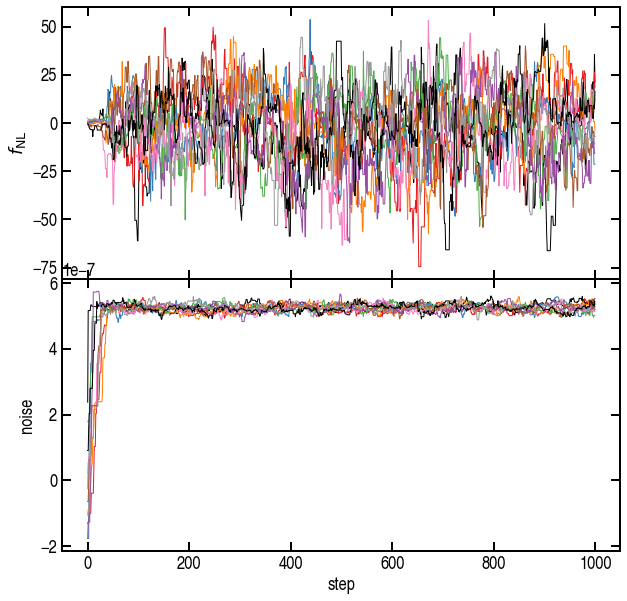

In [6]:
fg, ax = plt.subplots(nrows=2, figsize=(10, 10), sharex=True)
fg.subplots_adjust(hspace=0.0)

for i in range(10):
    ax[0].plot(chains[:, i, 0], ls='-', lw=1)
    ax[1].plot(chains[:, i, 1], ls='-', lw=1)
        
ax[0].set(ylabel=r'$f_{\rm NL}$')
ax[1].set(xlabel='step', ylabel='noise')


In [11]:
sample = chains[200:, :, :].flatten().reshape(-1, 2)
sample[:, 1] *= 1.0e7

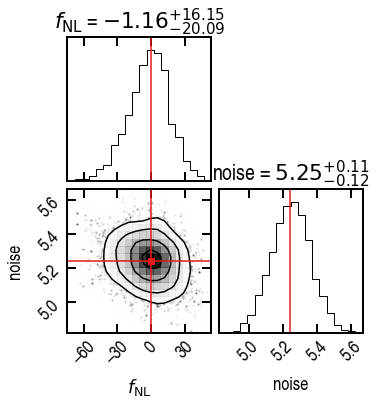

In [44]:
corner.corner(sample, smooth=True, show_titles=True, #quantiles=(0.16, 0.84), levels=(0.393, 0.68, 0.95), 
              labels=[r'$f_{\rm NL}$', r'noise'], truths=[0.0, 5.24], truth_color='C1',)
plt.show()

In [19]:
# maps = glob('/fs/ess/PHS0336/data/lognormal/v0/*.fits')
# print(len(maps))
#
# shotnoise = []
# for map_i in maps:
#     d_i = hp.read_map(map_i, verbose=False, dtype=np.float32)
#     shotnoise.append(1./np.mean(d_i)*hp.nside2pixarea(256))
#     print('.', end='')
#noise = np.mean(shotnoise)
noise = 5.247052878037432e-07 # this is what I got after running above
noise 

5.247052878037432e-07

In [5]:
#ell_edges = np.arange(2, 312, 10)
#ell_edges = np.array([2] + [10*i for i in range(1,10)] + [100+i*20 for i in range(5)] + [200+i*50 for i in range(3)])
ell_edges = np.array([i for i in range(2, 10)] + [10*i for i in range(1, 10)] +[100+i*20 for i in range(5)] + [200+i*50 for i in range(3)])

cl_mocks = np.load('/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_fullsky.npy')
ell = np.arange(cl_mocks.shape[1])
cl_mocks_binned = []
for cl_i in cl_mocks:
    ell_bin, cl_bin = histogram_cell(ell, cl_i, bins=ell_edges)
    cl_mocks_binned.append(cl_bin)
    print('.', end='')
cl_mocks_binned = np.array(cl_mocks_binned)

nmocks, nbins = cl_mocks_binned.shape
hf = (nmocks - 1.0)/(nmocks - nbins - 2.0)
cl_cov = np.cov(cl_mocks_binned, rowvar=False)*hf #/ nmocks
inv_cov = np.linalg.inv(cl_cov)
print(f'Hartlap with #mocks ({nmocks}) and #bins ({nbins}): {hf:.2f}' )


#np.savez('/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_fullsky_mean.npz',
np.savez('/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_fullsky_mean_fine.npz',
     **{'el_edges':ell_edges, 'el_bin':ell_bin, 'cl':cl_mocks_binned.mean(axis=0)})

np.savez('/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_fullsky_cov_fine.npz',
     **{'el_edges':ell_edges, 'el_bin':ell_bin, 'clcov':cl_cov})

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

h         : 0.67556
T0_cmb    : 2.7255
Omega0_b  : 0.0482754208891869
Omega0_cdm: 0.26377065934278865
N_ur      : None
m_ncdm    : [0.06]
P_k_max   : 10.0
P_z_max   : 100.0
sigma8    : 0.8225
gauge     : synchronous
n_s       : 0.9667
nonlinear : False
p = 1.6


/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:263: RuntimeWarning: divide by zero encountered in true_divide
  fnl_f = self.alpha_fnl/(k2*self.Tlin(k))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:264: RuntimeWarning: invalid value encountered in multiply
  w_f1 = self.wfnlk1[i][1]*fnl_f
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:265: RuntimeWarning: invalid value encountered in multiply
  w_f2 = self.wfnlk2[i][1]*fnl_f
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:272: RuntimeWarning: invalid value encountered in multiply
  i_f1f1.append(self.simps(k3pk*w_f1*w_f1, lnk))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:273: RuntimeWarning: invalid value encountered in multiply
  i_f2f2.append(self.simps(k3pk*w_f2*w_f2, lnk))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:275: RuntimeWarning: invalid value encountered in multiply
  i_gf1.append(self.simps(k3pk*w_g*w_f1, lnk))
/use

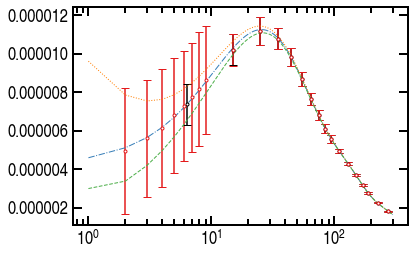

In [6]:
clmocks = {}
clmocks['mean'] = np.load('/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_fullsky_mean.npz')
clmocks['cov'] = np.load('/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_fullsky_cov.npz')
clmocks['mean_fine'] = np.load('/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_fullsky_mean_fine.npz')
clmocks['cov_fine'] = np.load('/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_fullsky_cov_fine.npz')

ww = np.ones(12*1024*1024, '?')
z, b, dNdz = init_sample(kind='lrg')
model = SurveySpectrum()
model.add_tracer(z, b, dNdz, p=1.6)
model.add_kernels(model.el_model)
model.add_window(ww*1.0, ww, np.arange(2048), ngauss=2048)  

el_g = np.arange(1, 300)

for m in ['', '_fine']:
    cl_ = clmocks['mean'+m]['cl']
    el_ = clmocks['mean'+m]['el_bin']
    clcov_ = clmocks['cov'+m]['clcov']

    plt.errorbar(el_, cl_, yerr=np.diag(clcov_)**0.5, capsize=4, marker='.', mfc='w', ls='none')

plt.plot(el_g, model(el_g, fnl=0.0, noise=5.24e-7), lw=1)
plt.plot(el_g, model(el_g, fnl=20.0, noise=5.24e-7), lw=1)
plt.plot(el_g, model(el_g, fnl=-20.0, noise=5.24e-7), lw=1)
plt.xscale('log')
# plt.yscale('log')

In [10]:
res = cl_obs - cl_model_binned
print(res.dot(invcov.dot(res)), res.shape)

0.014071431928347158 (17,)


Text(0, 0.5, 'chi2')

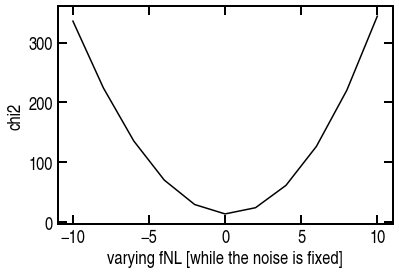

In [14]:
fnl = np.linspace(-10, 10, num=11)
noi = noise+ np.linspace(-1.0e-7, 1.0e-7, num=11)
print(noi, fnl)

chi1d = []
ell = np.arange(768)
for fi in fnl:
    cl_model_ = model(ell, fi, noise=noise)
    cl_modelb_ = histogram_cell(ell, cl_model_, bins=el_edges)[1]
    res = cl_obs - cl_modelb_
    chi1d.append(res.dot(invcov.dot(res)))
    print('.', end='')

plt.plot(fnl, np.array(chi1d)*1000)
plt.xlabel('varying fNL [while the noise is fixed]')
plt.ylabel('chi2')
# plt.ylim(ymax=50.)

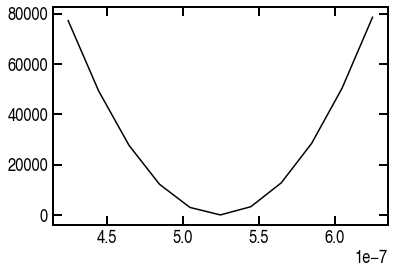

In [19]:
chi1d_n = []

for ni in noi:
    cl_model_ = model(ell, 0.0, noise=ni)
    cl_modelb_ = histogram_cell(ell, cl_model_, bins=el_edges)[1]
    res = cl_obs - cl_modelb_
    chi1d_n.append(res.dot(invcov.dot(res)))
    print('.', end='')
    
plt.plot(noi, np.array(chi1d_n)*1000.)

In [21]:
FNL, NOISE = np.meshgrid(fnl, noi)

ell = np.arange(768)
cost = []
for fi, nj in zip(FNL.flatten(), NOISE.flatten()):
    #print(i, j)
    
    cl_model_ = model(ell, fi, noise=nj)
    cl_modelb_ = histogram_cell(ell, cl_model_, bins=el_edges)[1]
    res = cl_obs - cl_modelb_
    cost.append(res.dot(invcov.dot(res)))

    print('.', end='')

/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:237: RuntimeWarning: divide by zero encountered in true_divide
  wk_t = wk_gg - wk_rsd + fnl*self.alpha_fnl*wk_fnl/(k*k*self.Tlin(k))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:237: RuntimeWarning: invalid value encountered in true_divide
  wk_t = wk_gg - wk_rsd + fnl*self.alpha_fnl*wk_fnl/(k*k*self.Tlin(k))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:240: RuntimeWarning: invalid value encountered in multiply
  intg = k*k*k*self.Plin(k)*wk_t*wk_t


.........................................................................................................................

In [22]:
cost = np.array(cost).reshape(11, 11)

In [43]:
levels = np.percentile(cost.flatten()*1000, np.arange(0., 9., 1.))
levels

array([ 14.07143193,  25.49290012,  42.52488651,  67.03083334,
       115.5239529 , 135.75417504, 221.29917875, 268.94297817,
       340.63812688])

Text(0, 0.5, 'noise')

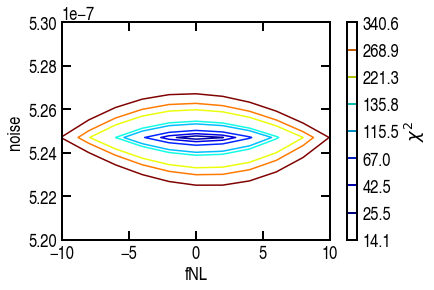

In [44]:
plt.contour(FNL, NOISE, cost*1000, levels,  
            origin='lower', cmap='jet')
plt.colorbar(label=r'$\chi^{2}$')
plt.ylim(5.2e-7, 5.3e-7)
plt.xlabel('fNL')
plt.ylabel('noise')

In [11]:
from scipy.optimize import minimize

In [15]:
#--- optimization
lg = Posterior(model, cl_obs, invcov, el_edges)
def logpost(foo):
    return -1*lg.logpost(foo)  

In [18]:
from time import time

In [19]:
t0 = time()
res = minimize(logpost, [1.0, 5.6e-7], method='Nelder-Mead')
t1 = time()

In [20]:
t1-t0

227.4358949661255

In [21]:
227/60.

3.783333333333333

In [22]:
res

 final_simplex: (array([[3.88914971e-01, 5.24213930e-07],
       [3.88837485e-01, 5.24214009e-07],
       [3.88882454e-01, 5.24214031e-07]]), array([0.00607039, 0.00607039, 0.00607039]))
           fun: 0.006070393828318754
       message: 'Optimization terminated successfully.'
          nfev: 97
           nit: 52
        status: 0
       success: True
             x: array([3.88914971e-01, 5.24213930e-07])

(-10.0, 10.0)

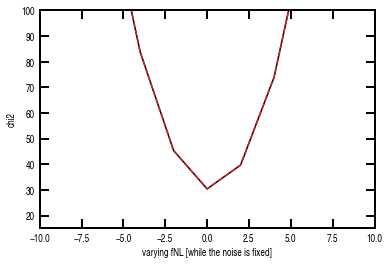

In [31]:
plt.plot(fnl, np.array(chi1d)*1000.)
plt.plot(fnl, np.array(chi1d2)*1000.)

plt.xlabel('varying fNL [while the noise is fixed]')
plt.ylabel('chi2')
plt.ylim(ymax=100.)
plt.xlim(-10., 10.)

### BMZLS

In [ ]:
r = 'bmzls'
#chains = np.load(f'/fs/ess/PHS0336/data/lognormal/v0/mcmc/mcmc_lrg_{r}_{m}.npy')
noise = 5.318313611128018e-07# nowei. np.mean(chains[200:, :, 1])
#noise = 5.325521208000955e-07 # lin.
print(noise)

weight, mask = read_window(r)

z, b, dNdz = init_sample(kind='lrg')

model = SurveySpectrum()
model.add_tracer(z, b, dNdz, p=1.6)
model.make_kernels(model.el_model)
model.prep_window(weight, mask, np.arange(2*1024), ngauss=2*1024)

5.318313611128018e-07
read window
h         : 0.67556
T0_cmb    : 2.7255
Omega0_b  : 0.0482754208891869
Omega0_cdm: 0.26377065934278865
N_ur      : None
m_ncdm    : [0.06]
P_k_max   : 10.0
P_z_max   : 100.0
sigma8    : 0.8225
gauge     : synchronous
n_s       : 0.9667
nonlinear : False
p = 1.6


In [34]:
data_path = '/fs/ess/PHS0336/data/'
bins = np.array([2*(i+1) for i in range(4, 10)]+[30+i*50 for i in range(7)])

# compute covariance
cl_list = []
for i in range(1, 1001):    
    cl_i = f'{data_path}lognormal/v0/clustering/clmock_{i}_lrg_{r}_256_noweight.npy'        
    cl_ = np.load(cl_i, allow_pickle=True).item()['cl_gg']['cl']
    lb_, clb_ = histogram_cell(np.arange(cl_.size), cl_, bins=bins)
    cl_list.append(clb_)
    print('.', end='')

nmocks, nbins = np.array(cl_list).shape
hf = (nmocks - 1.0)/(nmocks - nbins - 2.0)
cl_cov = np.cov(cl_list, rowvar=False)*hf / nmocks
inv_cov = np.linalg.inv(cl_cov)
print(f'Hartlap with #mocks ({nmocks}) and #bins ({nbins}): {hf:.2f}' )

el = lb_
cl = np.mean(cl_list, axis=0)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [57]:
el_ = np.arange(1, 400)
cl_zero_ = model(el_, 0.0, noise=0.0)
cl_zero = histogram_cell(el_, cl_zero_, bins=bins)[1]

/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:237: RuntimeWarning: invalid value encountered in true_divide
  wk_t = wk_gg - wk_rsd + fnl*self.alpha_fnl*wk_fnl/(k*k*self.Tlin(k))


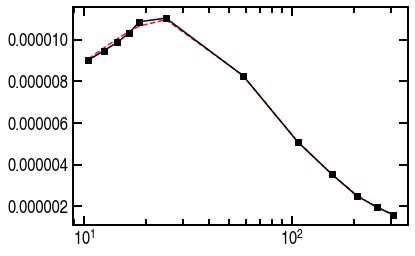

In [59]:
plt.errorbar(el, cl, yerr=np.diagonal(cl_cov)**0.5, marker='s')
plt.plot(el, cl_zero+noise)
plt.xscale('log')

In [60]:
res = (cl_zero+noise - cl)
print(res.dot(inv_cov.dot(res)))

55.74327063917241


In [61]:
res.shape

(12,)

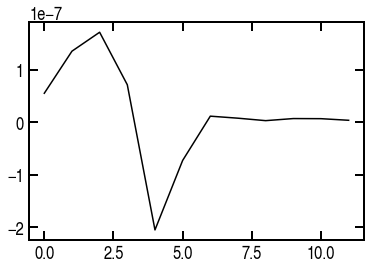

In [62]:
plt.plot(res)

In [64]:
for dres in np.linspace(-6.3e-9, -4.5e-9, 10):
    res = (cl_zero+noise - cl)+dres
    print(dres, res.dot(inv_cov.dot(res)))

-6.3e-09 18.85786130873246
-6.1e-09 18.308644026307462
-5.9e-09 17.872225606701768
-5.7e-09 17.548606049915385
-5.5e-09 17.33778535594832
-5.2999999999999995e-09 17.239763524800566
-5.1e-09 17.25454055647213
-4.9e-09 17.382116450963004
-4.7e-09 17.622491208273193
-4.5e-09 17.975664828402692


In [9]:
def make_resplot(r, m, fnl_list=[-20., -10, -4]):

    #chains = np.load(f'/fs/ess/PHS0336/data/lognormal/v0/mcmc/mcmc_lrg_{r}_{m}.npy')
    # noise = 5.318313611128018e-07# nowei. np.mean(chains[200:, :, 1])
    noise = 5.325521208000955e-07 # lin.
    print(noise)

    bins = np.array([2*(i+1) for i in range(10)]+[30+i*50 for i in range(7)])
    el, cl, __, cl_cov = read_clmocks(r, m, bins=bins, return_cov=True)

    weight, mask = read_window(r)

    z, b, dNdz = init_sample(kind='lrg')

    model = SurveySpectrum()
    model.add_tracer(z, b, dNdz, p=1.6)
    model.make_kernels(model.el_model)
    model.prep_window(weight, mask, np.arange(2*1024), ngauss=2*1024)

    el_ = np.arange(1, 400)
    cl_zero_ = model(el_, 0.0, noise=noise)
    cl_zero = histogram_cell(el_, cl_zero_, bins=bins)[1]

    fg, ax = plt.subplots(figsize=(15, 8))
    ax.errorbar(el, cl/cl_zero, 
                yerr=np.diag(cl_cov)**0.5/cl_zero, capsize=3, marker='.', mfc='w', ls='',
                label=f'{r.upper()} {m}')
    if len(fnl_list)!=0:        
        for fnl in fnl_list:
            ax.plot(el_, model(el_, fnl, noise=noise)/cl_zero_, 
                    label=r'f$_{\rm NL}$=%.1f'%fnl)

    ax.legend(fontsize=20, ncol=2, loc='lower right')
    ax.axvline(20., ls='--', alpha=0.2)
    ax.set(xlabel=r'$\ell$', ylabel=r'C$_{\ell}$/C$_{\ell}^{fNL=0}$',
          xlim=(-1., 400.), ylim=(0.0, 2.0), xscale='log')

5.318313611128018e-07
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................Hartlap with #mocks (900) and #bins (16): 1.02
bins: [  2.58333333   4.55     

/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:237: RuntimeWarning: invalid value encountered in true_divide
  wk_t = wk_gg - wk_rsd + fnl*self.alpha_fnl*wk_fnl/(k*k*self.Tlin(k))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:237: RuntimeWarning: divide by zero encountered in true_divide
  wk_t = wk_gg - wk_rsd + fnl*self.alpha_fnl*wk_fnl/(k*k*self.Tlin(k))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:240: RuntimeWarning: invalid value encountered in multiply
  intg = k*k*k*self.Plin(k)*wk_t*wk_t
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:237: RuntimeWarning: divide by zero encountered in true_divide
  wk_t = wk_gg - wk_rsd + fnl*self.alpha_fnl*wk_fnl/(k*k*self.Tlin(k))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:237: RuntimeWarning: invalid value encountered in true_divide
  wk_t = wk_gg - wk_rsd + fnl*self.alpha_fnl*wk_fnl/(k*k*self.Tlin(k))
/users/PHS0336/medirz90/github/LSSutils/lssutils/

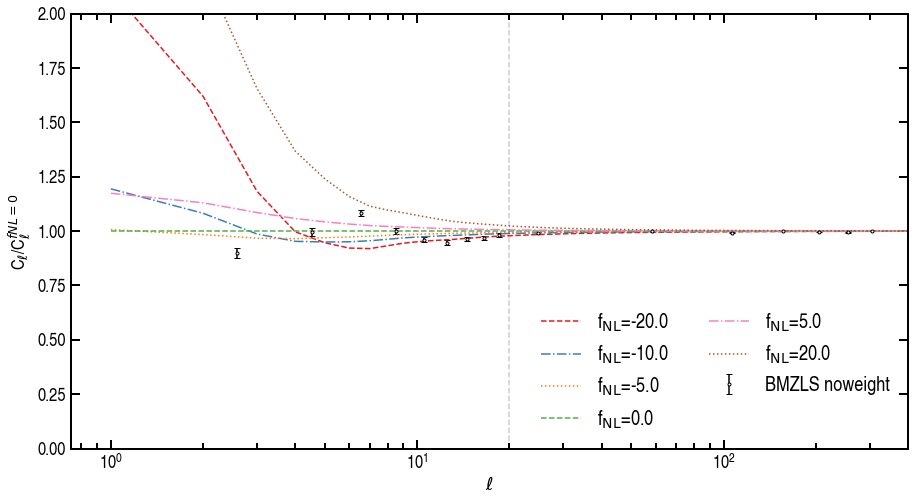

In [8]:
make_resplot('bmzls', 'noweight', fnl_list=[-20., -10., -5., 0., 5., 20.])

5.325521208000955e-07
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................Hartlap with #mocks (900) and #bins (16): 1.02
bins: [  2.58333333   4.55     

/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:237: RuntimeWarning: invalid value encountered in true_divide
  wk_t = wk_gg - wk_rsd + fnl*self.alpha_fnl*wk_fnl/(k*k*self.Tlin(k))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:237: RuntimeWarning: divide by zero encountered in true_divide
  wk_t = wk_gg - wk_rsd + fnl*self.alpha_fnl*wk_fnl/(k*k*self.Tlin(k))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:240: RuntimeWarning: invalid value encountered in multiply
  intg = k*k*k*self.Plin(k)*wk_t*wk_t
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:237: RuntimeWarning: divide by zero encountered in true_divide
  wk_t = wk_gg - wk_rsd + fnl*self.alpha_fnl*wk_fnl/(k*k*self.Tlin(k))
/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:237: RuntimeWarning: invalid value encountered in true_divide
  wk_t = wk_gg - wk_rsd + fnl*self.alpha_fnl*wk_fnl/(k*k*self.Tlin(k))
/users/PHS0336/medirz90/github/LSSutils/lssutils/

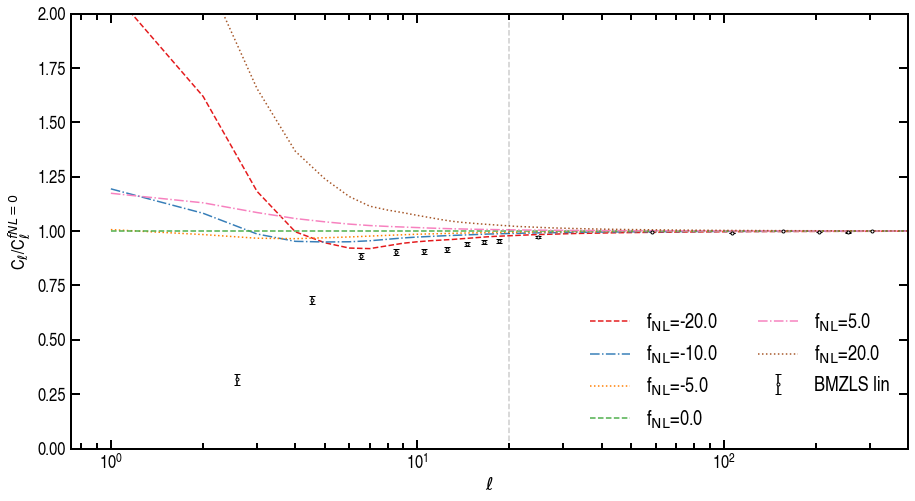

In [10]:
make_resplot('bmzls', 'lin', fnl_list=[-20., -10., -5., 0., 5., 20.])

## MCMC Fit

In [5]:
ls /fs/ess/PHS0336/data/lognormal/v0/mcmc/ -altr

total 1985
drwxr-xr-x+ 6 medirz90 PHS0336  65536 Nov 12 11:44 ../
-rw-rw-r--+ 1 medirz90 PHS0336 160128 Nov 15 06:22 mcmc_lrg_ndecals_lin_1000.npy
-rw-rw-r--+ 1 medirz90 PHS0336 160128 Nov 15 06:23 mcmc_lrg_bmzls_lin_1000.npy
-rw-rw-r--+ 1 medirz90 PHS0336 160128 Nov 15 06:23 mcmc_lrg_bmzls_nn_1000.npy
-rw-rw-r--+ 1 medirz90 PHS0336 160128 Nov 15 06:23 mcmc_lrg_ndecals_noweight_1000.npy
-rw-rw-r--+ 1 medirz90 PHS0336 160128 Nov 15 06:23 mcmc_lrg_sdecals_noweight_1000.npy
-rw-rw-r--+ 1 medirz90 PHS0336 160128 Nov 15 06:23 mcmc_lrg_ndecals_nn_1000.npy
-rw-rw-r--+ 1 medirz90 PHS0336 160128 Nov 15 06:24 mcmc_lrg_sdecals_nn_1000.npy
-rw-rw-r--+ 1 medirz90 PHS0336 160128 Nov 15 06:25 mcmc_lrg_sdecals_lin_1000.npy
-rw-rw-r--+ 1 medirz90 PHS0336 160128 Nov 15 06:29 mcmc_lrg_bmzls_noweight_1000_gt100.npy
-rw-rw-r--+ 1 medirz90 PHS0336 160128 Nov 15 06:39 mcmc_lrg_bmzls_noweight_1000.npy
drwxrwxr-x+ 2 medirz90 PHS0336   4096 Nov 15 08:12 ./
-rw-rw-r--+ 1 medirz90 PHS0336 320128 Nov 15 08:12 mcmc

[Text(0, 0.5, '$f_{\\rm NL}$')]

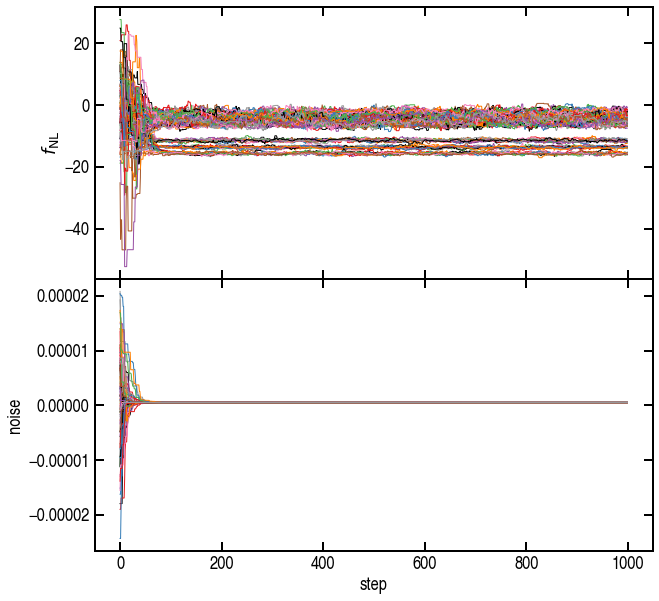

In [8]:
regions = ['bmzls', 'ndecals', 'sdecals']
methods = ['nn', 'lin', 'noweight']

chains = {}
for r in regions:
    for m in methods:
        #chains[f'{r}_{m}_1k'] = np.load(f'/fs/ess/PHS0336/data/lognormal/v0/mcmc/mcmc_lrg_{r}_{m}_steps1k.npy')
        chains[f'{r}_{m}'] = np.load(f'/fs/ess/PHS0336/data/lognormal/v0/mcmc/mcmc_lrg_{r}_{m}_1000.npy')
        
print(chains.keys())


fg, ax = plt.subplots(nrows=2, figsize=(10, 10), sharex=True)
fg.subplots_adjust(hspace=0.0)
for m in chains:
    for i in range(10):
        ln = ax[0].plot(chains[m][:, i, 0], ls='-', lw=1)
        ax[1].plot(chains[m][:, i, 1], ls='-', lw=1)
        
ax[1].set(xlabel='step', ylabel='noise')
ax[0].set(ylabel=r'$f_{\rm NL}$')

bmzls_nn 0.90
bmzls_lin 1.02
bmzls_noweight 2.37
ndecals_nn 0.78
ndecals_lin 1.10
ndecals_noweight 1.86
sdecals_nn 0.70
sdecals_lin 1.21
sdecals_noweight 2.62


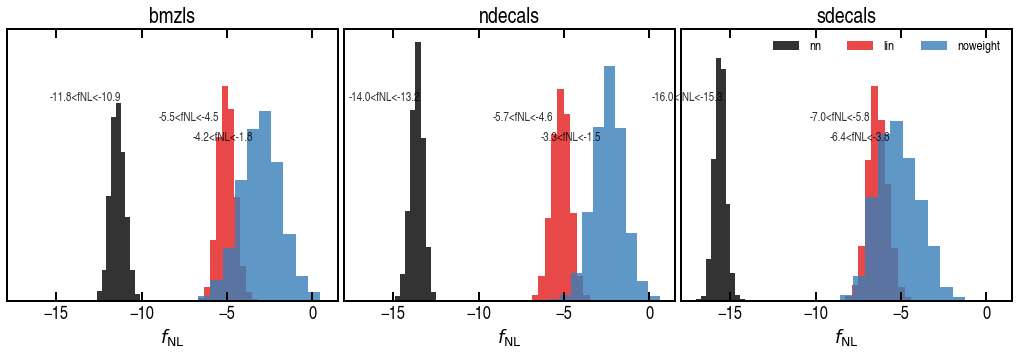

In [9]:
skip = 200

fg, ax = plt.subplots(ncols=3, figsize=(18, 5), sharey=True, sharex=True)
fg.subplots_adjust(wspace=0.02) 

for i, r in enumerate(regions):
    for j, m in enumerate(methods):
        k = f'{r}_{m}'
        v = chains[k][skip:, :, 0].flatten()
        vmin, vmax = np.percentile(v, [15, 85])
        print(k, '%.2f'%(vmax - vmin))
        h = ax[i].hist(v, alpha=0.8, label=m, zorder=-10)
        
        ax[i].text(v.mean()-4, 2000-j*200, '{0:.1f}<fNL<{1:.1f}'.format(*np.percentile(v, [15, 85])),
                   alpha=0.8, fontsize=12)
        
    ax[i].set(title=r, xlabel=r'$f_{\rm NL}$', yticks=[])

ax[2].legend(ncol=3)

In [10]:
chains[f'bmzls_2000'] = np.load(f'/fs/ess/PHS0336/data/lognormal/v0/mcmc/mcmc_lrg_bmzls_noweight_2000.npy')

In [20]:
chains[f'bmzls_2000'].shape

(2000, 10, 2)

2.3704716817370937 -3.0315451805100855
2.361655976638698 -2.907575896004893


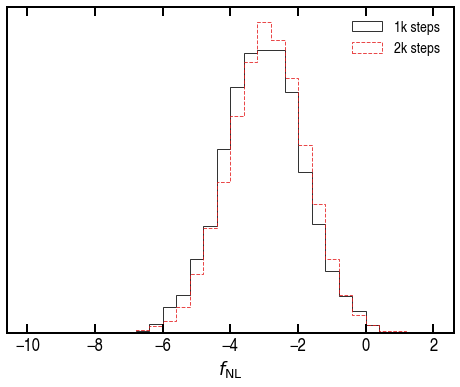

In [23]:
fg, ax = plt.subplots(figsize=(8, 6))
fg.subplots_adjust(wspace=0.02) 

i = 0
for k in ['bmzls_noweight', 'bmzls_2000']:
    skip = 200 if i==0 else 500
    v = chains[k][skip:, :, 0].flatten()
    vmin, vmax = np.percentile(v, [15, 85])
    print(vmax-vmin, v.mean())

    h = ax.hist(v, histtype='step', alpha=0.8, range=(-10., 2.), bins=30, zorder=-10, density=True)

    #ax.text(v.mean()-2, 10000-j*200, '{0:.1f}<fNL<{1:.1f}'.format(*np.percentile(v, [15, 85])),
    #          alpha=0.8, fontsize=12)
    #ax.text(v.mean(), 1800-j*200, m, )
        
    ax.set(xlabel=r'$f_{\rm NL}$', yticks=[])

ax.legend(['1k steps', '2k steps'], fontsize=15)

In [24]:
chains[f'bmzls_gt100'] = np.load(f'/fs/ess/PHS0336/data/lognormal/v0/mcmc/mcmc_lrg_bmzls_noweight_1000_gt100.npy')

2.3704716817370937 -3.0315451805100855
20.87798365307267 -2.076578692236748


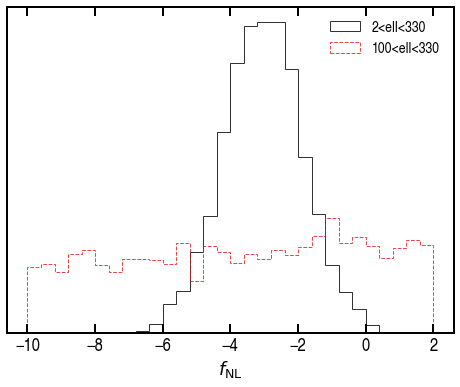

In [25]:
fg, ax = plt.subplots(figsize=(8, 6))
fg.subplots_adjust(wspace=0.02) 

i = 0
for k in ['bmzls_noweight', 'bmzls_gt100']:
    skip = 200
    v = chains[k][skip:, :, 0].flatten()
    vmin, vmax = np.percentile(v, [15, 85])
    print(vmax-vmin, v.mean())

    h = ax.hist(v, histtype='step', alpha=0.8, range=(-10., 2.), bins=30, zorder=-10, density=True)

    #ax.text(v.mean()-2, 10000-j*200, '{0:.1f}<fNL<{1:.1f}'.format(*np.percentile(v, [15, 85])),
    #          alpha=0.8, fontsize=12)
    #ax.text(v.mean(), 1800-j*200, m, )
        
    ax.set(xlabel=r'$f_{\rm NL}$', yticks=[])

ax.legend([r'2<ell<330', '100<ell<330'], fontsize=15)

bmzls nn  0.7826065633047197
bmzls nn _1k 0.778046832518049
bmzls lin  0.9434261574770364
bmzls lin _1k 0.9554897645912521
bmzls noweight  1.8096153480272865
bmzls noweight _1k 2.0199716456396137


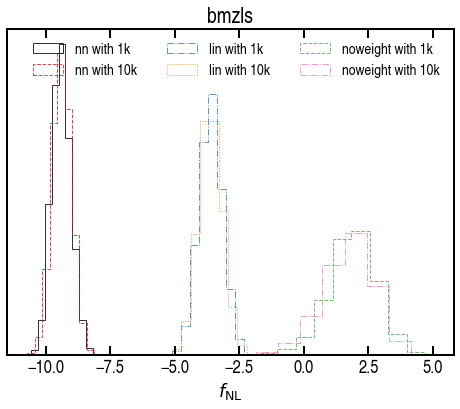

In [33]:

fg, ax = plt.subplots(figsize=(8, 6))
fg.subplots_adjust(wspace=0.02) 

for i, r in enumerate(regions):
    for j, m in enumerate(methods):
        for nstep in ['', '_1k']:
            
            k = f'{r}_{m}{nstep}'
            skip = 200 if nstep=='' else 5000
            
            v = chains[k][skip:, :, 0].flatten()
            vmin, vmax = np.percentile(v, [15, 85])
            
            print(r, m, nstep, vmax-vmin)
            if '1k' in k:
                lb = f'{m} with 10k'
            else:
                lb = f'{m} with 1k'

            h = ax.hist(v, histtype='step', alpha=0.8, zorder=-10, density=True, label=lb)

            #ax.text(v.mean()-2, 10000-j*200, '{0:.1f}<fNL<{1:.1f}'.format(*np.percentile(v, [15, 85])),
            #          alpha=0.8, fontsize=12)
            #ax.text(v.mean(), 1800-j*200, m, )
        
    ax.set(title=r, xlabel=r'$f_{\rm NL}$', yticks=[])

ax.legend(ncol=3, fontsize=15)

In [26]:
regions = ['bmzls']
methods = ['nn', 'lin', 'noweight']

chains = {}
for r in regions:
    for m in methods:
        chains[f'{r}_{m}'] = np.load(f'/fs/ess/PHS0336/data/lognormal/v0/mcmc/mcmc_lrg_{r}_{m}.npy')

[Text(0, 0.5, 'f$_{\\rm NL}$')]

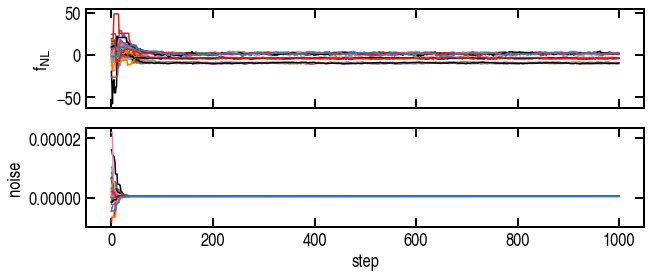

In [27]:
fg, ax = plt.subplots(nrows=2, figsize=(10, 4), sharex=True)


for m in chains:
    for i in range(10):
        ln = ax[0].plot(chains[m][:, i, 0], ls='-')
        ax[1].plot(chains[m][:, i, 1], ls='-')
        
ax[1].set(xlabel='step', ylabel='noise')
ax[0].set(ylabel=r'f$_{\rm NL}$')

[Text(0, 0.5, 'f$_{\\rm NL}$'), Text(0.5, 0, 'step')]

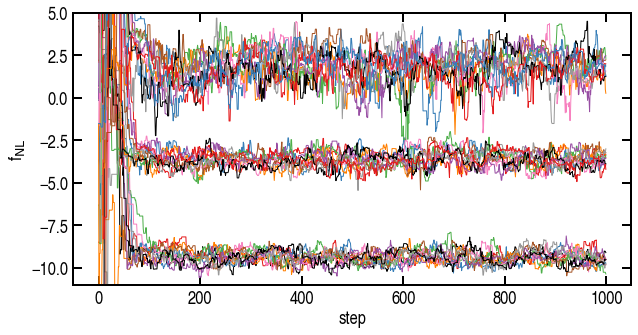

In [24]:
fg, ax = plt.subplots(nrows=1, figsize=(10, 5), sharex=True)


for m in chains:
    for i in range(10):
        ln = ax.plot(chains[m][:, i, 0], ls='-', lw=1)
        #ax[1].plot(chains[m][:, i, 1], ls='-')
        
ax.set_ylim(-11., 5.)
ax.set(xlabel='step', ylabel=r'f$_{\rm NL}$')

No handles with labels found to put in legend.


bmzls nn 0.7826065633047197
bmzls lin 0.9434261574770364
bmzls noweight 1.8096153480272865


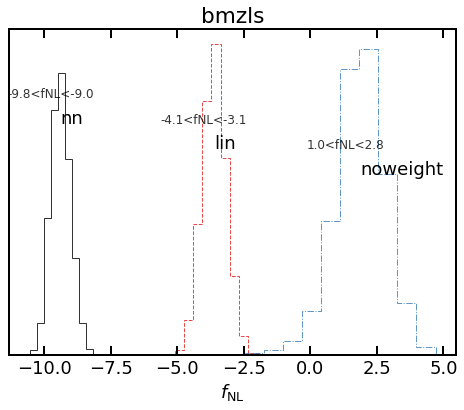

In [11]:
skip = 200

fg, ax = plt.subplots(figsize=(8, 6))
fg.subplots_adjust(wspace=0.02) 

for i, r in enumerate(regions):
    for j, m in enumerate(methods):
        k = f'{r}_{m}'
        v = chains[k][skip:, :, 0].flatten()
        vmin, vmax = np.percentile(v, [15, 85])
        print(r, m, vmax-vmin)
        #if '2to330' in m:
        #    lb = m.split('_')[0] + r' (2$\leq\ell$<330)'
        #else:
        #    lb = m + r' (4$\leq\ell$<330)'
            
        h = ax.hist(v, histtype='step', alpha=0.8, zorder=-10)
        
        ax.text(v.mean()-2, 2000-j*200, '{0:.1f}<fNL<{1:.1f}'.format(*np.percentile(v, [15, 85])),
                  alpha=0.8, fontsize=12)
        ax.text(v.mean(), 1800-j*200, m, )
        
    ax.set(title=r, xlabel=r'$f_{\rm NL}$', yticks=[])

ax.legend(ncol=3, fontsize=10)

In [6]:
regions = ['bmzls']
methods = ['nn', 'nn_2to330', 'lin', 'lin_2to330', 'noweight', 'noweight_2to330']

chains = {}
for r in regions:
    for m in methods:
        chains[f'{r}_{m}'] = np.load(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/v3/mcmc_lrg_{r}_{m}.npy')

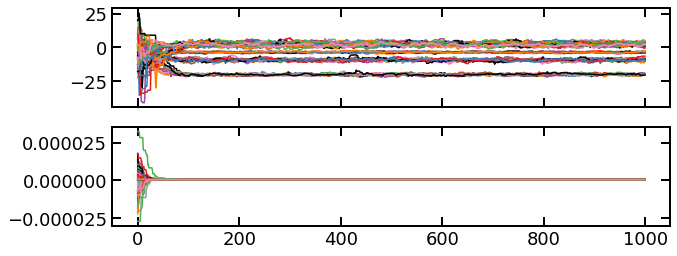

In [7]:
fg, ax = plt.subplots(nrows=2, figsize=(10, 4), sharex=True)


for m in chains:
    for i in range(10):
        ln = ax[0].plot(chains[m][:, i, 0], ls='-')
        ax[1].plot(chains[m][:, i, 1], ls='-')

[-22.05934331 -16.89253722]
[-10.52552556  -8.02334732]
[-12.60079017  -5.59494853]
[-5.10226389 -2.23866569]
[-0.99000876  7.09182586]
[-2.44399427  4.50169884]


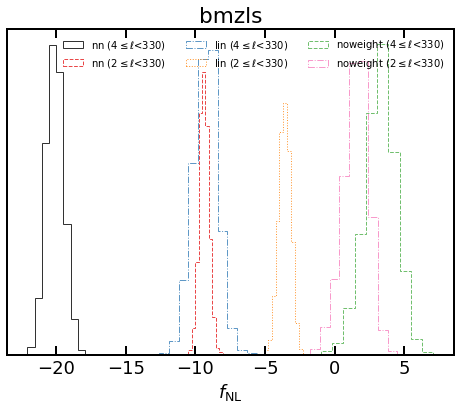

In [8]:
skip = 200

fg, ax = plt.subplots(figsize=(8, 6))
fg.subplots_adjust(wspace=0.02) 

for i, r in enumerate(regions):
    for j, m in enumerate(methods):
        k = f'{r}_{m}'
        v = chains[k][skip:, :, 0].flatten()
        print(np.percentile(v, [0, 100]))
        if '2to330' in m:
            lb = m.split('_')[0] + r' (2$\leq\ell$<330)'
        else:
            lb = m + r' (4$\leq\ell$<330)'
            
        h = ax.hist(v, histtype='step', alpha=0.8, label=lb, zorder=-10)
        
        #ax[i].text(v.mean()-2, 2000-j*200, '{0:.1f}<fNL<{1:.1f}'.format(*np.percentile(v, [15, 85])),
        #           alpha=0.8, fontsize=12)
        
    ax.set(title=r, xlabel=r'$f_{\rm NL}$', yticks=[])

ax.legend(ncol=3, fontsize=10)

In [6]:
regions = ['bmzls', 'ndecals', 'sdecals']
methods = ['noweight', 'lin', 'nn']

chains = {}
for r in regions:
    for m in methods:
        chains[f'{r}_{m}'] = np.load(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/v3/mcmc_lrg_{r}_{m}.npy')

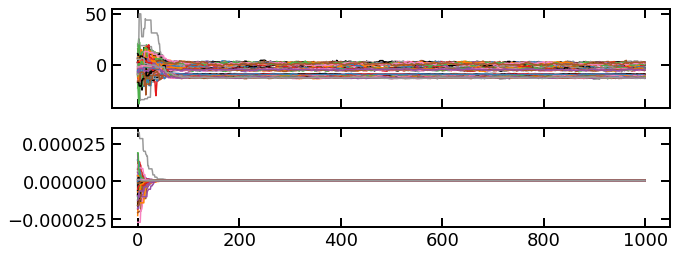

In [8]:
fg, ax = plt.subplots(nrows=2, figsize=(10, 4), sharex=True)


for m in chains:
    for i in range(10):
        ln = ax[0].plot(chains[m][:, i, 0], ls='-')
        ax[1].plot(chains[m][:, i, 1], ls='-')

[-2.44399427  4.50169884]
[-5.10226389 -2.23866569]
[-10.52552556  -8.02334732]
[-2.90114677  2.57131949]
[-5.60794769 -2.13322925]
[-12.58666191 -10.45396244]
[-1.85157506  3.72255526]
[-6.40935059 -2.79586642]
[-13.69994155 -11.35780601]


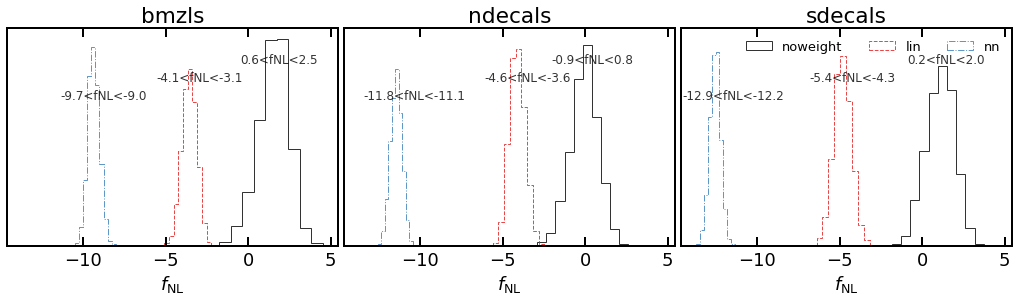

In [51]:
skip = 200

fg, ax = plt.subplots(ncols=3, figsize=(18, 4), sharey=True, sharex=True)
fg.subplots_adjust(wspace=0.02) 

for i, r in enumerate(regions):
    for j, m in enumerate(methods):
        k = f'{r}_{m}'
        v = chains[k][skip:, :, 0].flatten()
        print(np.percentile(v, [0, 100]))
        h = ax[i].hist(v, histtype='step', alpha=0.8, label=m, zorder=-10)
        
        ax[i].text(v.mean()-2, 2000-j*200, '{0:.1f}<fNL<{1:.1f}'.format(*np.percentile(v, [15, 85])),
                   alpha=0.8, fontsize=12)
        
    ax[i].set(title=r, xlabel=r'$f_{\rm NL}$', yticks=[])

ax[2].legend(ncol=3)

## Mode-Counting vs Mock Error

In [4]:
region = 'bmzls'
data_path = '/fs/ess/PHS0336/data/'
list_clmocks = glob(f'{data_path}lognormal/v0/clustering/clmock_*_lrg_{region}_256_noweight.npy')
print(len(list_clmocks))


1000


In [9]:
df = ft.read('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/v3/nlrg_features_bmzls_256.fits')
fsky = df.size / (12*256*256)
print(fsky)

0.1246477762858073


In [5]:
cl_mocks = []
for fl in list_clmocks:
    cl_i = np.load(fl, allow_pickle=True).item()
    cl_mocks.append(cl_i['cl_gg']['cl'])
    print('.', end='')

cl_mean = np.mean(cl_mocks, axis=0)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [6]:
cl_err = np.std(cl_mocks, axis=0)

In [10]:
el = np.arange(cl_mean.size)
cl_mode = cl_mean / (0.5*(2.*el+1.)*fsky)

Text(0, 0.5, '$\\sigma(C_{\\ell})$')

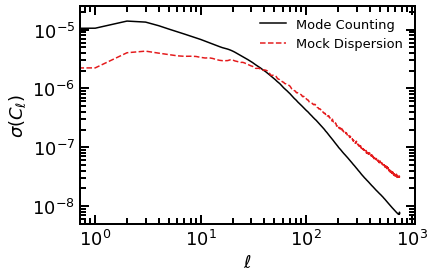

In [37]:
plt.plot(cl_mode, '-',
         cl_err, '--')
plt.legend(['Mode Counting', 'Mock Dispersion'])
plt.yscale('log')
plt.ylim(5.0e-9, 2.5e-5)
# plt.xscale('symlog', linthreshx=100)
# plt.xlim(xmax=1100)
plt.xscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\sigma(C_{\ell})$')

In [39]:
np.savetxt("cellerr_mc_mock.txt", np.column_stack([el, cl_mode, cl_err]), header='ell mode-counting mock-dispersion')

## Window and Integral  Constraint

In [12]:
def test_ic(region):
    # read mocks
    data_path = '/fs/ess/PHS0336/data/'


    list_clmocks = glob(f'{data_path}lognormal/v0/clustering/clmock_*_lrg_{region}_256_noweight.npy')
    print(len(list_clmocks))

    cl_mocks = []
    for fl in list_clmocks:
        cl_i = np.load(fl, allow_pickle=True).item()
        cl_mocks.append(cl_i['cl_gg']['cl'])
        print('.', end='')

    cl_mean = np.mean(cl_mocks, axis=0)


    # mask
    dt = ft.read(f'{data_path}rongpu/imaging_sys/tables/nlrg_features_{region}_256.fits')
    mask_ = make_hp(256, dt['hpix'], 1.0) > 0.5
    mask = hp.ud_grade(mask_, 1024)
    weight = mask * 1.0

    noise = 5.247718593589074e-07
    el_m = np.arange(2*1024)
    wd = WindowSHT(weight, mask, el_m, ngauss=2*1024)

    # model
    z, b, dNdz = init_sample(kind='lrg')

    model = Spectrum()

    ell = np.arange(3000)
    model.add_tracer(z, b, dNdz, p=1.6)
    model.make_kernels(ell)
    cl_ = model(ell)

    cl_model = wd.convolve(np.arange(cl_.size), cl_)+noise

    cl_modelic = cl_model[:800] - cl_model[0]*(wd.cl_mask[:800]/wd.cl_mask[0])**2
    cl_modelic_ = cl_model[:800] - cl_model[0]*(wd.cl_mask[:800])**2


    # plot
    def plot():
        plt.plot(cl_+noise, label='Model', alpha=0.2)
        plt.plot(cl_model,  label='Model+Window')
        plt.plot(cl_modelic, label='Model+Window+IC', ls='-')
        #plt.plot(cl_modelic_, label='Model+Window+IC II')

        plt.plot(cl_mean,  label='Simulation Mean', color='C0', marker='o', markersize=4, mfc='w')

    plt.figure(figsize=(14, 10))


    plot()
    plt.grid(ls=':', lw=1, alpha=0.8)
    #plt.xlim(-0.4, 51)
    plt.xlim(-1., 701)
    plt.xlabel(r'$\ell$')
    plt.ylabel(r'C$_{\ell}$')
    plt.xscale('symlog', linthreshx=100)

    #plt.axes([0.4, 0.25, 0.45, 0.45])
    #plot()
    #plt.xlim(-0.4, 9)
    plt.legend()

    # plt.xscale('log')
    #plt.show()
    plt.savefig('cl_model_mocks_scaled.png', dpi=300, bbox_inches='tight')

1000
...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:235: RuntimeWarning: invalid value encountered in true_divide
  wk_t = wk_gg - wk_rsd + fnl*self.alpha_fnl*wk_fnl/(k*k*self.Tlin(k))


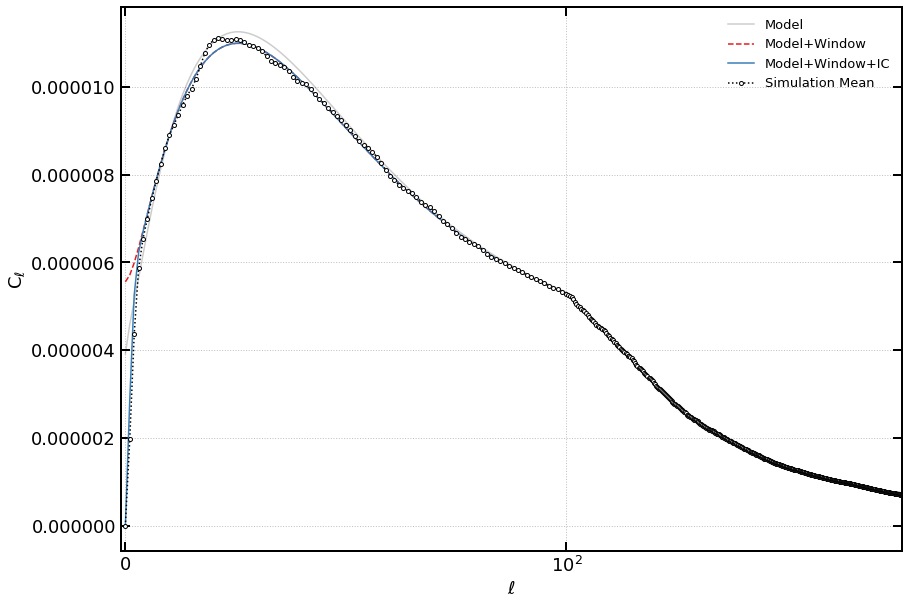

In [13]:
test_ic('bmzls')

1000
...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:243: RuntimeWarning: invalid value encountered in true_divide
  wk_t = wk_gg - wk_rsd + fnl*self.alpha_fnl*wk_fnl/(k*k*self.Tlin(k))


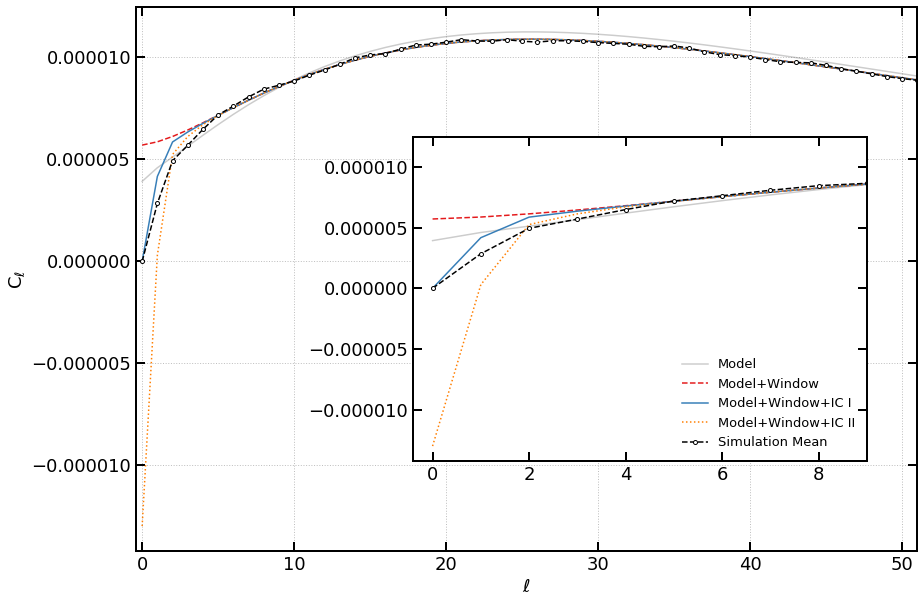

In [6]:
test_ic('ndecals')

1000
...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

/users/PHS0336/medirz90/github/LSSutils/lssutils/theory/cell.py:243: RuntimeWarning: invalid value encountered in true_divide
  wk_t = wk_gg - wk_rsd + fnl*self.alpha_fnl*wk_fnl/(k*k*self.Tlin(k))


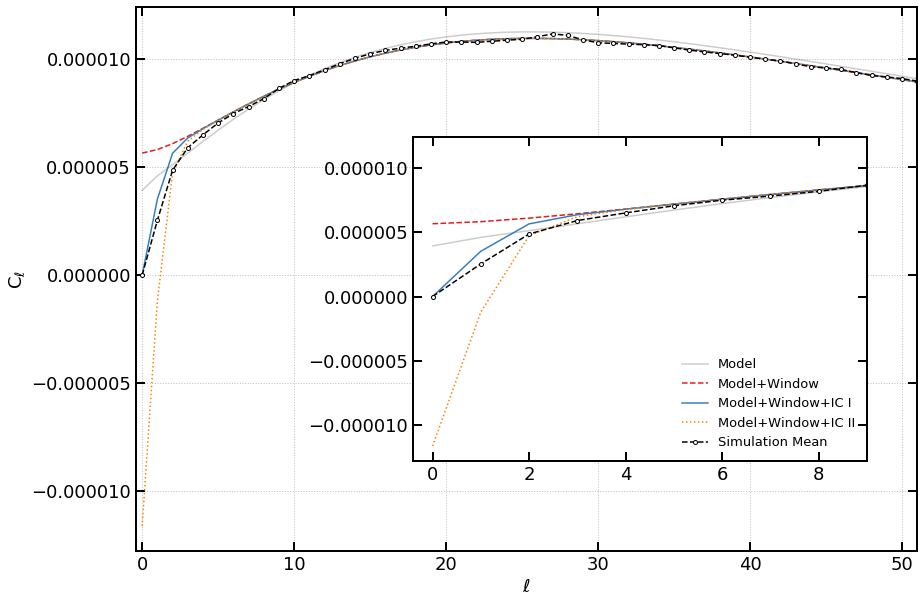

In [7]:
test_ic('sdecals')

## Power Spectra

In [5]:
nmocks = 100


cl_All = {}

for region in ['bmzls', 'ndecals', 'sdecals']:
    
    cl_all = {'noweight':[],
             'nn':[],
             'lin':[]}
    p = '/fs/ess/PHS0336/data/lognormal/v0/clustering/'

    for i in range(1, nmocks+1):

        for n in ['nn', 'lin', 'noweight']:
            cl_ = np.load(f'{p}clmock_{i}_lrg_{region}_256_{n}.npy', allow_pickle=True).item()
            cl_all[n].append(cl_['cl_gg']['cl'])
    print(f'{region} done')
    
    cl_All[region] = cl_all

bmzls done
ndecals done
sdecals done


[Text(0, 0.5, 'C$_{Null,X}$/C$_{Null}$')]

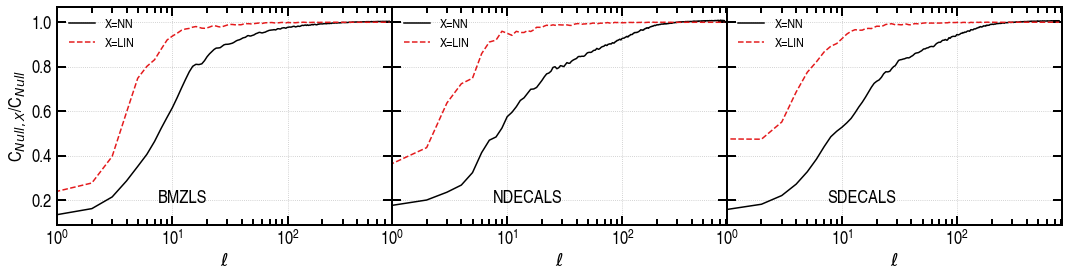

In [6]:
fg, ax_list = plt.subplots(ncols=3, figsize=(18, 4), sharey=True)
fg.subplots_adjust(wspace=0.0)



for i, (region, cl_all) in enumerate(cl_All.items()):
    
    ax = ax_list[i]
    null_mean = np.mean(cl_all['noweight'], axis=0)

    for n in ['nn', 'lin']:

        ax.plot(np.mean(cl_all[n], axis=0)/null_mean, label=f'X={n.upper()}')

    ax.text(0.3, 0.1, region.upper(), transform=ax.transAxes)
    #ax.set(xscale='log', yscale='log', 
    #       ylabel=r'C$_{\ell}$', xlabel='$\ell$', ylim=(1.0e-7, 1.0e-4))
    ax.set(xlim=(1, 805), xscale='log', xlabel=r'$\ell$')
    ax.legend()
    ax.grid(ls=':', color='grey', alpha=0.5)
    
ax_list[0].set(ylabel='C$_{Null,X}$/C$_{Null}$')
# ax.set_title('Mean of 100 Mocks')

[Text(0, 0.5, '$\\sigma(C_{Null,X})/\\sigma(C_{Null})$')]

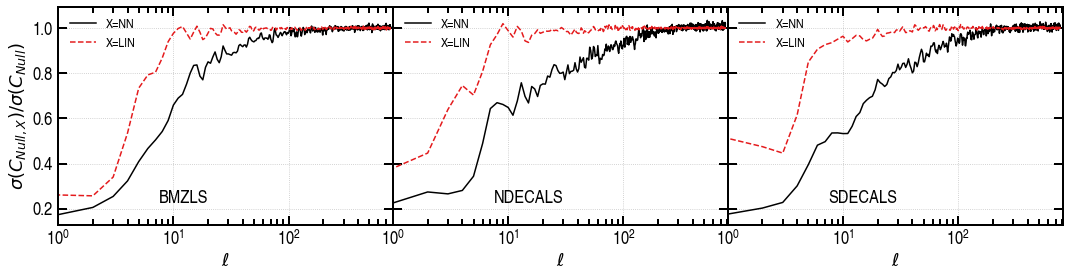

In [8]:
fg, ax_list = plt.subplots(ncols=3, figsize=(18, 4), sharey=True)
fg.subplots_adjust(wspace=0.0)



for i, (region, cl_all) in enumerate(cl_All.items()):
    
    ax = ax_list[i]
    null_mean = np.std(cl_all['noweight'], axis=0)
    

    for n in ['nn', 'lin']:

        ax.plot(np.std(cl_all[n], axis=0)/null_mean, label=f'X={n.upper()}')

    ax.text(0.3, 0.1, region.upper(), transform=ax.transAxes)
    #ax.set(xscale='log', yscale='log', 
    #       ylabel=r'C$_{\ell}$', xlabel='$\ell$', ylim=(1.0e-7, 1.0e-4))
    ax.set(xlim=(1, 805), xscale='log', xlabel=r'$\ell$')
    ax.legend()
    ax.grid(ls=':', color='grey', alpha=0.5)
    
ax_list[0].set(ylabel='$\sigma(C_{Null,X})/\sigma(C_{Null})$')
# ax.set_title('Mean of 100 Mocks')

[Text(0, 0.5, '$\\sigma(C_{Null,X})/C_{Null}$')]

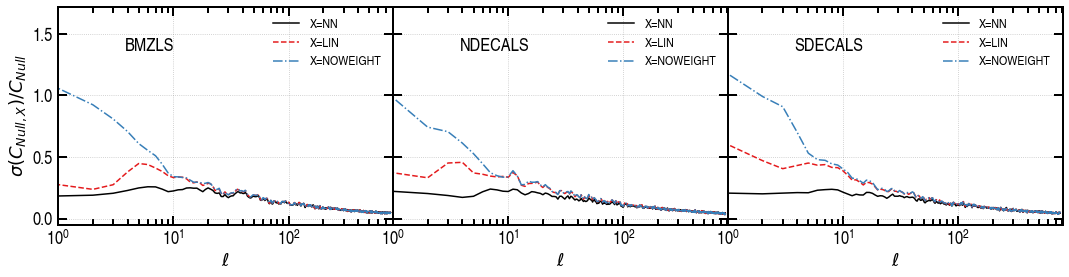

In [9]:
fg, ax_list = plt.subplots(ncols=3, figsize=(18, 4), sharey=True)
fg.subplots_adjust(wspace=0.0)

def get_sn(cl):
    return np.mean(cl, axis=0) / np.std(cl, axis=0)

for i, (region, cl_all) in enumerate(cl_All.items()):
    
    ax = ax_list[i]
    null_mean = np.mean(cl_all['noweight'], axis=0)
    

    for n in ['nn', 'lin', 'noweight']:

        ax.plot(np.std(cl_all[n], axis=0)/null_mean, label=f'X={n.upper()}')

    ax.text(0.2, 0.8, region.upper(), transform=ax.transAxes)
    #ax.set(xscale='log', yscale='log', 
    #       ylabel=r'C$_{\ell}$', xlabel='$\ell$', ylim=(1.0e-7, 1.0e-4))
    ax.set(xlim=(1, 805), xscale='log', xlabel=r'$\ell$')
    ax.legend()
    ax.grid(ls=':', color='grey', alpha=0.5)
    
ax_list[0].set(ylabel='$\sigma(C_{Null,X})/C_{Null}$')
# ax.set_title('Mean of 100 Mocks')

[Text(0, 0.5, '$\\sigma(C_{Null,X})/C_{Null,X}$')]

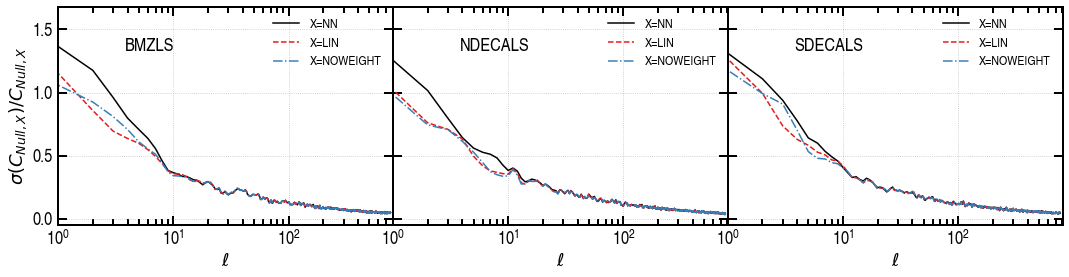

In [11]:
fg, ax_list = plt.subplots(ncols=3, figsize=(18, 4), sharey=True)
fg.subplots_adjust(wspace=0.0)

def get_sn(cl):
    return np.mean(cl, axis=0) / np.std(cl, axis=0)

for i, (region, cl_all) in enumerate(cl_All.items()):
    
    ax = ax_list[i]

    for n in ['nn', 'lin', 'noweight']:
        null_mean = np.mean(cl_all[n], axis=0)
        ax.plot(np.std(cl_all[n], axis=0)/null_mean, label=f'X={n.upper()}')

    ax.text(0.2, 0.8, region.upper(), transform=ax.transAxes)
    #ax.set(xscale='log', yscale='log', 
    #       ylabel=r'C$_{\ell}$', xlabel='$\ell$', ylim=(1.0e-7, 1.0e-4))
    ax.set(xlim=(1, 805), xscale='log', xlabel=r'$\ell$')
    ax.legend()
    ax.grid(ls=':', color='grey', alpha=0.5)
    
ax_list[0].set(ylabel='$\sigma(C_{Null,X})/C_{Null,X}$')
# ax.set_title('Mean of 100 Mocks')

[Text(0, 0.5, '$\\sigma(C_{Null})/C_{Null,X}$')]

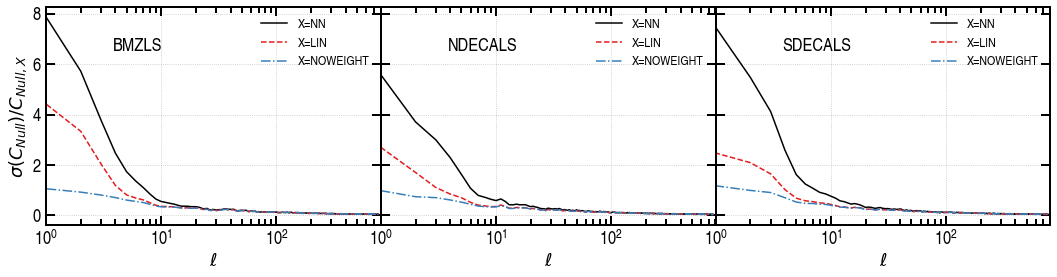

In [12]:
fg, ax_list = plt.subplots(ncols=3, figsize=(18, 4), sharey=True)
fg.subplots_adjust(wspace=0.0)

def get_sn(cl):
    return np.mean(cl, axis=0) / np.std(cl, axis=0)

for i, (region, cl_all) in enumerate(cl_All.items()):
    
    ax = ax_list[i]
    null_std = np.std(cl_all['noweight'], axis=0)
    for n in ['nn', 'lin', 'noweight']:
        
        ax.plot(null_std/np.mean(cl_all[n], axis=0), label=f'X={n.upper()}')

    ax.text(0.2, 0.8, region.upper(), transform=ax.transAxes)
    #ax.set(xscale='log', yscale='log', 
    #       ylabel=r'C$_{\ell}$', xlabel='$\ell$', ylim=(1.0e-7, 1.0e-4))
    ax.set(xlim=(1, 805), xscale='log', xlabel=r'$\ell$')
    ax.legend()
    ax.grid(ls=':', color='grey', alpha=0.5)
    
ax_list[0].set(ylabel='$\sigma(C_{Null})/C_{Null,X}$')
# ax.set_title('Mean of 100 Mocks')

## Cross Power of Mocks

In [14]:
def make_cellchi2(region):      
    # region = 'bmzls'
    nmocks = 100
    _, err_nn, cl_ss = read_clx(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/v2/cl_lrg_{region}_256_nn.npy')
    _, err_lin, _ = read_clx(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/v2/cl_lrg_{region}_256_lin.npy', cl_ss)
    
    cell_list = [f'/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_{i}_lrg_{region}_256_noweight.npy'\
                for i in range(nmocks+1, 1001)]
    print(len(cell_list))
    
    cell_mocks = read_clxmocks(cell_list, cl_ss)  
    invcov, covmax = get_inv(cell_mocks, True)
    
    # read chi2 of mocks
    chi2s = {'noweight':[], 'nn':[], 'lin':[]}
    for i in range(1, nmocks+1):
        for n in ['nn', 'lin', 'noweight']:
            _,d_,_ = read_clx(f'/fs/ess/PHS0336/data/lognormal/v0/clustering/clmock_{i}_lrg_{region}_256_{n}.npy', cl_ss)
            chi_ = chi2_fn(d_, invcov)
            chi2s[n].append(chi_)
        
    chi2d = {}
    chi2d['nn'] = chi2_fn(err_nn, invcov)
    chi2d['lin'] = chi2_fn(err_lin, invcov)
    
    fg, ax = plt.subplots() # https://stackoverflow.com/a/25497638/9746916
    ax.scatter(chi2s['noweight'], chi2s['nn'], marker='.', color='r', alpha=0.5)
    ax.scatter(chi2s['noweight'], chi2s['lin'], marker='.', color='b', facecolor='w', alpha=0.5)
    ax.scatter(np.mean(chi2s['noweight']), chi2d['nn'], 300, color='r', marker='*')
    ax.scatter(np.mean(chi2s['noweight']), chi2d['lin'], 300, color='b', marker='o')    
    lims = [np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
            np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
           ]

    # now plot both limits against eachother
    ax.set_title(region.upper())
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    # ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_xlabel(r'$\chi^{2}$ of Null Mocks')
    ax.set_ylabel(r'$\chi^{2}$ of Mitigated Null Mocks')
    fg.show()    

900
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................Hartlap factor: 1.151088348271447
with nmocks: 900 and nbins: 117


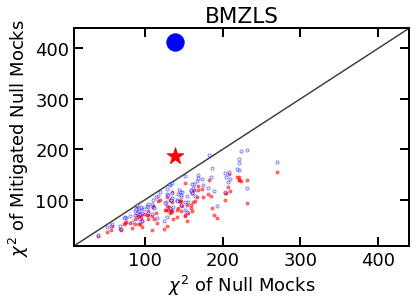

In [15]:
make_cellchi2('bmzls')

900
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................Hartlap factor: 1.151088348271447
with nmocks: 900 and nbins: 117


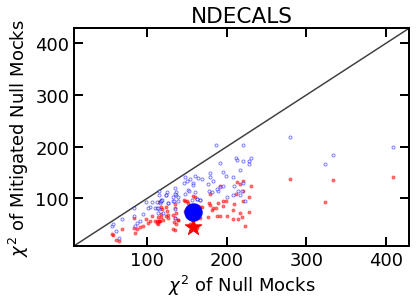

In [16]:
make_cellchi2('ndecals')

900
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................Hartlap factor: 1.151088348271447
with nmocks: 900 and nbins: 117


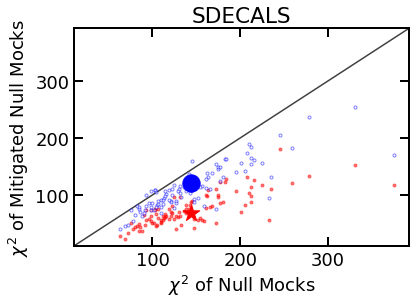

In [17]:
make_cellchi2('sdecals')

## Mean Density of Mocks

In [4]:
def make_nbarchi2(region):    
    # region = 'bmzls'
    nmocks = 100
    nbar_list = [f'/fs/ess/PHS0336/data/lognormal/v0/clustering/nbarmock_{i}_lrg_{region}_256_noweight.npy'\
                for i in range(nmocks+1, 1001)]
    print(len(nbar_list))
    nbar_mocks = read_nbmocks(nbar_list)

    invcov, covmax = get_inv(nbar_mocks, True)

    # fg, ax = plt.subplots(ncols=3, figsize=(12, 6), sharey=True)
    # fg.subplots_adjust(wspace=0.05, hspace=0.0)

    # map0 = ax[0].imshow(covmax, origin='lower', cmap=plt.cm.bwr)#, vmin=-2.0e-5, vmax=2.0e-5)
    # fg.colorbar(map0, ax=ax[0], orientation='horizontal',)# ticks=[-1.0e-5, 0, 1.0e-5], shrink=0.5)

    # map1 = ax[1].imshow(invcov, origin='lower', cmap=plt.cm.bwr)#, vmin=-2.0e6, vmax=2.0e6,)
    # fg.colorbar(map1, ax=ax[1], orientation='horizontal')#, shrink=0.5, ticks=[-1.0e6, 0, 1.0e6])


    # map2 = ax[2].imshow(covmax.dot(invcov), origin='lower', cmap=plt.cm.viridis)#, vmin=0, vmax=2.0)
    # fg.colorbar(map2, ax=ax[2], orientation='horizontal',)# ticks=[0., 1, 2.0], shrink=0.5)
    # plt.show()

    # read chi2 of mocks
    chi2s = {'noweight':[], 'nn':[], 'lin':[]}
    for i in range(1, nmocks+1):
        for n in ['noweight', 'nn', 'lin']:
            d_ = read_nnbar(f'/fs/ess/PHS0336/data/lognormal/v0/clustering/nbarmock_{i}_lrg_{region}_256_{n}.npy')
            chi_ = chi2_fn(d_, invcov)
            chi2s[n].append(chi_)

    nb_data = read_nnbar(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/v2/nbar_lrg_{region}_256_nn.npy')
    chi2_data = chi2_fn(nb_data, invcov)

    nb_data_ = read_nnbar(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/v2/nbar_lrg_{region}_256_lin.npy')
    chi2_data_ = chi2_fn(nb_data_, invcov)
    
    
    fg, ax = plt.subplots() # https://stackoverflow.com/a/25497638/9746916

    ax.scatter(chi2s['noweight'], chi2s['nn'], marker='.', color='r', alpha=0.5)
    ax.scatter(chi2s['noweight'], chi2s['lin'], marker='.', color='b', facecolor='w', alpha=0.5)
    ax.scatter(np.mean(chi2s['noweight']), chi2_data, 
               300, color='r', marker='*')
    #ax.axhline(chi2_data, ls='-', color='r', alpha=0.5)
    ax.scatter(np.mean(chi2s['noweight']), chi2_data_, 
              300, color='b', marker='o')
    #ax.axhline(chi2_data_, ls='--', color='b', alpha=0.5)
    
    lims = [np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
            np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
           ]

    # now plot both limits against eachother
    ax.set_title(region.upper())
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    # ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_xlabel(r'$\chi^{2}$ of Null Mocks')
    ax.set_ylabel(r'$\chi^{2}$ of Mitigated Null Mocks')
    fg.show()
    
    fg, ax = plt.subplots() # https://stackoverflow.com/a/25497638/9746916

    ax.scatter(chi2s['noweight'], chi2s['nn'], marker='.', color='r', alpha=0.5)
    #ax.scatter(chi2s['noweight'], chi2s['lin'], marker='.', color='b', facecolor='w', alpha=0.5)
    ax.scatter(np.mean(chi2s['noweight']), chi2_data, 
               300, color='r', marker='*')
    #ax.axhline(chi2_data, ls='-', color='r', alpha=0.5)
    #ax.scatter(np.mean(chi2s['noweight']), chi2_data_, 
    #          300, color='b', marker='o')
    #ax.axhline(chi2_data_, ls='--', color='b', alpha=0.5)
    
    #lims = [np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    #        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    #       ]

    # now plot both limits against eachother
    ax.set_title(region.upper())
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    # ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_xlabel(r'$\chi^{2}$ of Null Mocks')
    ax.set_ylabel(r'$\chi^{2}$ of Mitigated Null Mocks')    
    fg.show()
    
    
    fg, ax = plt.subplots() # https://stackoverflow.com/a/25497638/9746916

    ax.scatter(chi2s['noweight'], chi2s['nn'], marker='.', color='r', alpha=0.5)
    #ax.scatter(chi2s['noweight'], chi2s['lin'], marker='.', color='b', facecolor='w', alpha=0.5)
    #ax.scatter(np.mean(chi2s['noweight']), chi2_data, 
    #           300, color='r', marker='*')
    #ax.axhline(chi2_data, ls='-', color='r', alpha=0.5)
    #ax.scatter(np.mean(chi2s['noweight']), chi2_data_, 
    #          300, color='b', marker='o')
    #ax.axhline(chi2_data_, ls='--', color='b', alpha=0.5)
    
    #lims = [np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    #        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    #       ]

    # now plot both limits against eachother
    ax.set_title(region.upper())
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    # ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_xlabel(r'$\chi^{2}$ of Null Mocks')
    ax.set_ylabel(r'$\chi^{2}$ of Mitigated Null Mocks')    
    fg.show()

900
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................(900, 104)
Hartlap factor: 1.1322418136020151
with nmocks: 900 and nbins: 104


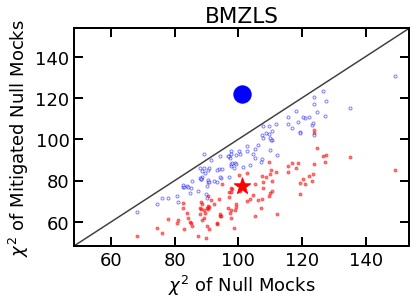

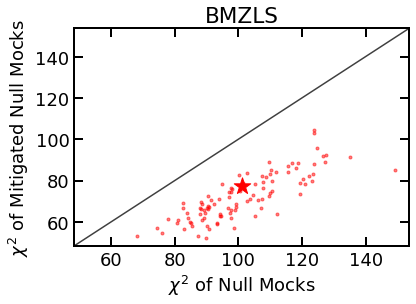

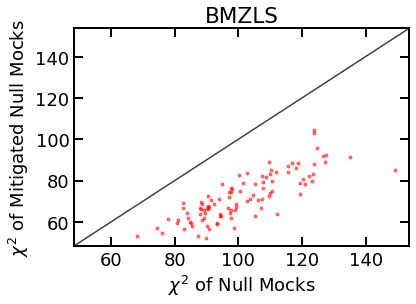

In [7]:
make_nbarchi2('bmzls')

900
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................(900, 104)
Hartlap factor: 1.1322418136020151
with nmocks: 900 and nbins: 104


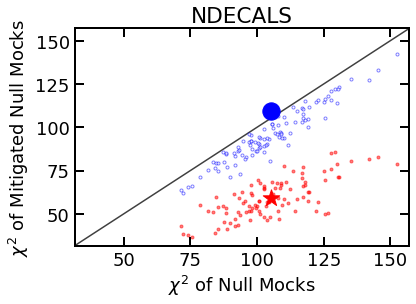

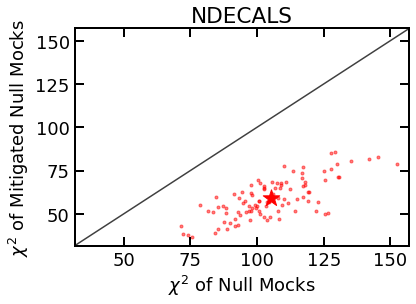

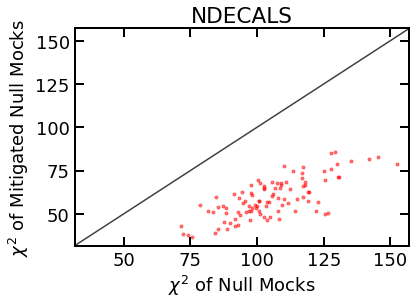

In [8]:
make_nbarchi2('ndecals')

900
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................(900, 104)
Hartlap factor: 1.1322418136020151
with nmocks: 900 and nbins: 104


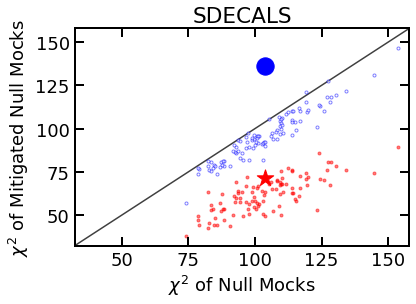

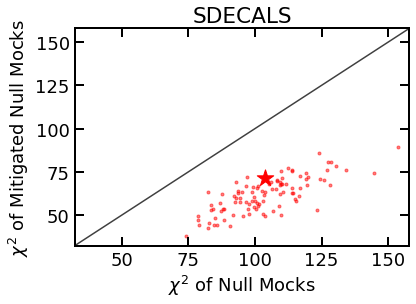

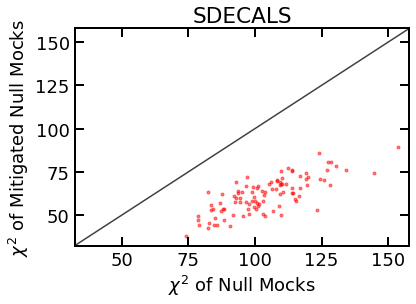

In [9]:
make_nbarchi2('sdecals')

In [4]:
region = 'bmzls'
nmocks = 100
nbar_list = [f'/fs/ess/PHS0336/data/lognormal/v0/clustering/nbarmock_{i}_lrg_{region}_256_noweight.npy'\
            for i in range(nmocks+1, 1001)]
print(len(nbar_list))
nbar_mocks = read_nbmocks(nbar_list)

invcov, covmax = get_inv(nbar_mocks, True)
err = np.sqrt(np.diag(covmax))

900
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................(900, 104)
Hartlap factor: 1.1322418136020151
with nmocks: 900 and nbins: 104


In [5]:
nbars = {}
nbars['No Weight'] = np.load('/fs/ess/PHS0336/data/lognormal/v0/clustering/nbarmock_1_lrg_bmzls_256_noweight.npy', allow_pickle=True)
nbars['NN'] = np.load('/fs/ess/PHS0336/data/lognormal/v0/clustering/nbarmock_1_lrg_bmzls_256_nn.npy', allow_pickle=True)
nbars['Linear'] = np.load('/fs/ess/PHS0336/data/lognormal/v0/clustering/nbarmock_1_lrg_bmzls_256_lin.npy', allow_pickle=True)

(0.004, 0.16)

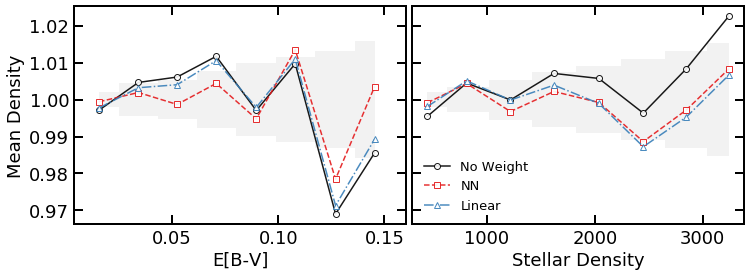

In [9]:
fg, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)
fg.subplots_adjust(wspace=0.02)

mk = ['o', 's', '^']
j = 0
for n_i, d_i in nbars.items():
    for i in [0, 1]:
        ax[i].plot(d_i[i]['bin_avg'], d_i[i]['nnbar'],
                    mfc='w', alpha=0.9, label=n_i, marker=mk[j])
        if j==0:
            ax[i].fill_between(d_i[i]['bin_avg'], 1-err[i*8:(i+1)*8], 1+err[i*8:(i+1)*8],
                               alpha=0.1, step='mid', fc='grey')#, ec='k', lw=2)     
            
    j += 1
    
ax[1].legend(loc='lower left')

for i, sys in enumerate(['E[B-V]', 'Stellar Density']):
    ax[i].set_xlabel(sys)
    
ax[0].set_ylabel('Mean Density')
ax[0].set_xlim(0.004, 0.16)

## The effect of the fNL and systematics

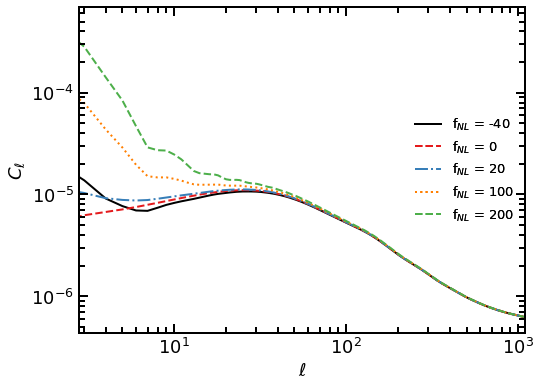

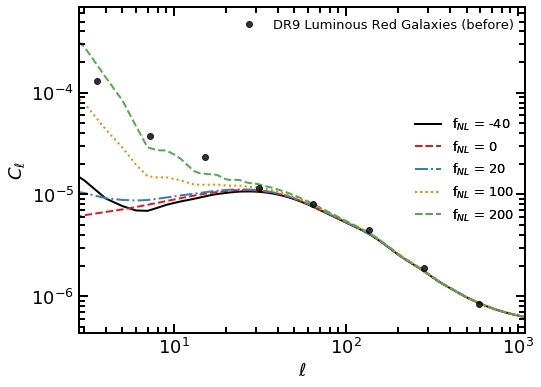

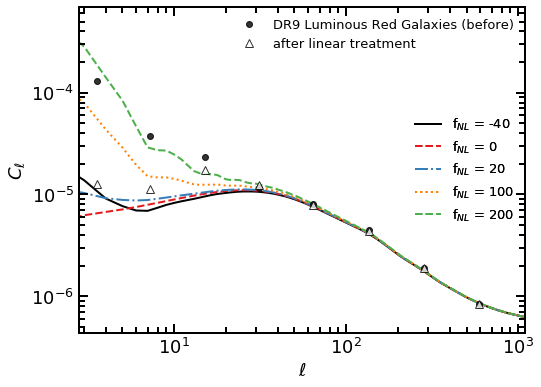

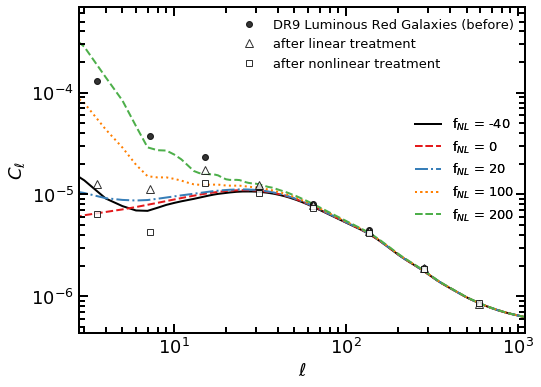

In [13]:
z, b, dNdz = init_sample(kind='lrg')
model = Spectrum()
ell = np.arange(3000)
model.add_tracer(z, b, dNdz, p=1.6)
model.make_kernels(ell)

# mask
dt = ft.read('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/v3/nlrg_features_bmzls_256.fits')
mask_ = make_hp(256, dt['hpix'], 1.0) > 0.5
mask = hp.ud_grade(mask_, 1024)
weight = mask * 1.0
noise = 1.25*1/np.mean(dt['label'])*hp.nside2pixarea(256)
print(noise)

el_m = np.arange(2*1024)
wd = WindowSHT(weight, mask, el_m, ngauss=2*1024)

cl_true = {}
for fnl in [-40, 0, 20, 100, 200]:
    cl_ = model(ell, fnl=fnl)
    cl_model = wd.convolve(np.arange(cl_.size), cl_)+noise
    cl_true[fnl] = wd.apply_ic(cl_model[:1100])
    
    

cl_dr9 = np.load('/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/v3/cl_lrg_bmzls_256_nn.npy', 
                allow_pickle=True).item()
cl_dr9n = np.load('/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/v3/cl_lrg_bmzls_256_noweight.npy', 
                allow_pickle=True).item()
cl_dr9l = np.load('/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/v3/cl_lrg_bmzls_256_lin.npy', 
                allow_pickle=True).item()



lbins = np.logspace(0, np.log10(769), 10)

for plot_type in [-1, 0, 1, 2]:
    
    fg, ax = plt.subplots(figsize=(8, 6))

    lab1 = []
    if plot_type>=0:
        lab1 = ['DR9 Luminous Red Galaxies (before)']
        ax.plot(*histogram_cell(cl_dr9n['cl_gg']['cl'], bins=lbins),
                    marker='o', color='k', alpha=0.8, ls='None')

    if plot_type>=1:    
        lab1.append('after linear treatment')
        ax.plot(*histogram_cell(cl_dr9l['cl_gg']['cl'], bins=lbins),
                    marker='^', markersize=8, mfc='w', color='k', ls='None', alpha=0.8)

    if plot_type==2:
        lab1.append('after nonlinear treatment')
        ax.plot(*histogram_cell(cl_dr9['cl_gg']['cl'], bins=lbins),
                    marker='s', mfc='w', color='k', ls='None', alpha=0.8)

    ndat = len(lab1)


    lab2 = []
    for fnl_, cl_ in cl_true.items():
        ax.plot(cl_, lw=2, zorder=-10)
        lab2.append(r'f$_{NL}$ = %.0f'%fnl_)


    lines = ax.get_lines()
    lgn1 = plt.legend(lines[:ndat], lab1, loc='upper right')
    lgn2 = plt.legend(lines[ndat:], lab2, loc='center right')
    ax.add_artist(lgn1)  
    ax.add_artist(lgn2)

    ax.set(xlim=(2.8, 1101), yscale='log', ylabel=r'$C_{\ell}$',
           xlabel=r'$\ell$', xscale='log')
    plt.savefig(f'fnl_cl_{plot_type}.png', dpi=300, bbox_inches='tight')

## Cell Systematic Test

In [9]:
def make_chi2plot(region):
    #region = 'bmzls'
    print(f'region: {region}')

    l, err_0, cl_ss = read_clx(f'/home/mehdi/data/rongpu/imaging_sys/clustering/v2/cl_lrg_{region}_256_noweight.npy')
    _, err_1, __ = read_clx(f'/home/mehdi/data/rongpu/imaging_sys/clustering/v2/cl_lrg_{region}_256_nn.npy')

    list_cls = glob(f'/home/mehdi/data/lognormal/v0/clustering/clmock_*_lrg_{region}_256_noweight.npy')
    err_tot = read_clxmocks(list_cls, cl_ss)

    print('ell', l)
    print('# mocks', len(list_cls))
    invcov, covmax = get_inv(err_tot, True)

    chi2_mocks = get_chi2pdf(err_tot)
    chi2_before = chi2_fn(err_0, invcov)
    chi2_after = chi2_fn(err_1, invcov)

    print(chi2_before, chi2_after)
    plt.hist(chi2_mocks, alpha=0.2, label='Mocks (leave-one-out)')
    plt.axvline(chi2_before, alpha=0.5, ls='--', label='Data')
    plt.axvline(chi2_after, label='Data (cleaned)')
    plt.legend(title=region.upper())
    plt.xscale('symlog', linscalex=3, linthreshx=1000.)
    plt.xlabel(r'Cross Power $\chi^{2}$')
    plt.show()
    
#     fg, ax = plt.subplots(ncols=3, figsize=(12, 6), sharey=True)
#     fg.subplots_adjust(wspace=0.05, hspace=0.0)

#     map0 = ax[0].imshow(covmax, origin='lower', cmap=plt.cm.bwr)#, vmin=-2.0e-5, vmax=2.0e-5)
#     fg.colorbar(map0, ax=ax[0], orientation='horizontal',)# ticks=[-1.0e-5, 0, 1.0e-5], shrink=0.5)

#     map1 = ax[1].imshow(invcov, origin='lower', cmap=plt.cm.bwr)#, vmin=-2.0e6, vmax=2.0e6,)
#     fg.colorbar(map1, ax=ax[1], orientation='horizontal')#, shrink=0.5, ticks=[-1.0e6, 0, 1.0e6])


#     map2 = ax[2].imshow(covmax.dot(invcov), origin='lower', cmap=plt.cm.viridis)#, vmin=0, vmax=2.0)
#     fg.colorbar(map2, ax=ax[2], orientation='horizontal',)# ticks=[0., 1, 2.0], shrink=0.5)
#     plt.show()

region: bmzls
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

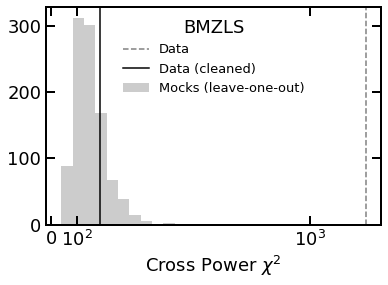

region: ndecals
........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

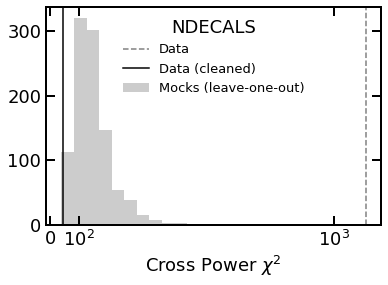

region: sdecals
........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

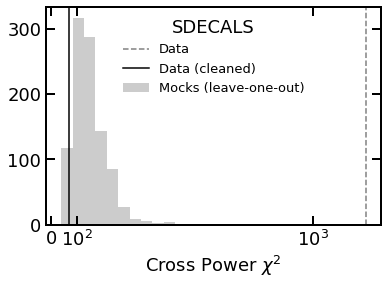

In [10]:
for reg in ['bmzls', 'ndecals', 'sdecals']:
    make_chi2plot(reg)

In [104]:
from matplotlib.ticker import Locator, SymmetricalLogLocator


class MajorSymLogLocator(SymmetricalLogLocator):

    def __init__(self, base=10., linthresh=1.0):
        super().__init__(base=base, linthresh=linthresh)

    @staticmethod
    def orders_magnitude(vmin, vmax):

        max_size = np.log10(max(abs(vmax), 1))
        min_size = np.log10(max(abs(vmin), 1))

        if vmax > 1 and vmin > 1:
            return max_size - min_size
        elif vmax < -1 and vmin < -1:
            return min_size - max_size
        else:
            return max(min_size, max_size)

    def tick_values(self, vmin, vmax):

        if vmax < vmin:
            vmin, vmax = vmax, vmin

        orders_magnitude = self.orders_magnitude(vmin, vmax)

        if orders_magnitude <= 1:
            spread = vmax - vmin
            exp = np.floor(np.log10(spread))
            rest = spread * 10 ** (-exp)

            stride = 10 ** exp * (0.25 if rest < 2. else
                                  0.5 if rest < 4 else
                                  1. if rest < 6 else
                                  2.)

            vmin = np.floor(vmin / stride) * stride
            return np.arange(vmin, vmax, stride)

        if orders_magnitude <= 2:
            pos_a, pos_b = np.floor(np.log10(max(vmin, 1))), np.ceil(np.log10(max(vmax, 1)))
            positive_powers = 10 ** np.linspace(pos_a, pos_b, int(pos_b - pos_a) + 1)
            positive = np.ravel(np.outer(positive_powers, [1., 5.]))

            linear = np.array([0.]) if vmin < 1 and vmax > -1 else np.array([])

            neg_a, neg_b = np.floor(np.log10(-min(vmin, -1))), np.ceil(np.log10(-min(vmax, -1)))
            negative_powers = - 10 ** np.linspace(neg_b, neg_a, int(neg_a - neg_b) + 1)[::-1]
            negative = np.ravel(np.outer(negative_powers, [1., 5.]))

            return np.concatenate([negative, linear, positive])

        else:

            pos_a, pos_b = np.floor(np.log10(max(vmin, 1))), np.ceil(np.log10(max(vmax, 1)))
            positive = 10 ** np.linspace(pos_a, pos_b, int(pos_b - pos_a) + 1)

            linear = np.array([0.]) if vmin < 1 and vmax > -1 else np.array([])

            neg_a, neg_b = np.floor(np.log10(-min(vmin, -1))), np.ceil(np.log10(-min(vmax, -1)))
            negative = - 10 ** np.linspace(neg_b, neg_a, int(neg_a - neg_b) + 1)[::-1]

            return np.concatenate([negative, linear, positive])

def symlogfmt(x, pos):
    return f'{x:.6f}'.rstrip('0')


class MinorSymLogLocator(Locator):
    """
    Dynamically find minor tick positions based on the positions of
    major ticks for a symlog scaling.
    """
    def __init__(self, linthresh, nints=10):
        """
        Ticks will be placed between the major ticks.
        The placement is linear for x between -linthresh and linthresh,
        otherwise its logarithmically. nints gives the number of
        intervals that will be bounded by the minor ticks.
        """
        self.linthresh = linthresh
        self.nintervals = nints

    def __call__(self):
        # Return the locations of the ticks
        majorlocs = self.axis.get_majorticklocs()

        if len(majorlocs) == 1:
            return self.raise_if_exceeds(np.array([]))

        # add temporary major tick locs at either end of the current range
        # to fill in minor tick gaps
        dmlower = majorlocs[1] - majorlocs[0]    # major tick difference at lower end
        dmupper = majorlocs[-1] - majorlocs[-2]  # major tick difference at upper end

        # add temporary major tick location at the lower end
        if majorlocs[0] != 0. and ((majorlocs[0] != self.linthresh and dmlower > self.linthresh) or (dmlower == self.linthresh and majorlocs[0] < 0)):
            majorlocs = np.insert(majorlocs, 0, majorlocs[0]*10.)
        else:
            majorlocs = np.insert(majorlocs, 0, majorlocs[0]-self.linthresh)

        # add temporary major tick location at the upper end
        if majorlocs[-1] != 0. and ((np.abs(majorlocs[-1]) != self.linthresh and dmupper > self.linthresh) or (dmupper == self.linthresh and majorlocs[-1] > 0)):
            majorlocs = np.append(majorlocs, majorlocs[-1]*10.)
        else:
            majorlocs = np.append(majorlocs, majorlocs[-1]+self.linthresh)

        # iterate through minor locs
        minorlocs = []

        # handle the lowest part
        for i in np.arange(1, len(majorlocs)):
            majorstep = majorlocs[i] - majorlocs[i-1]
            if abs(majorlocs[i-1] + majorstep/2) < self.linthresh:
                ndivs = self.nintervals
            else:
                ndivs = self.nintervals - 1.

            minorstep = majorstep / ndivs
            locs = np.arange(majorlocs[i-1], majorlocs[i], minorstep)[1:]
            minorlocs.extend(locs)

        return self.raise_if_exceeds(np.array(minorlocs))

    def tick_values(self, vmin, vmax):
        raise NotImplementedError('Cannot get tick locations for a '
                          '%s type.' % type(self))

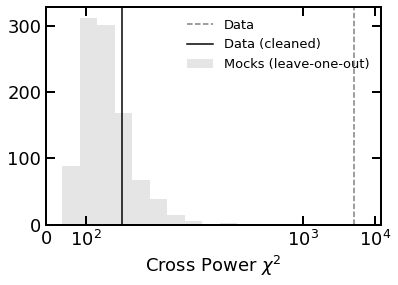

In [139]:
plt.hist(chi2_mocks, alpha=0.1, label='Mocks (leave-one-out)')
plt.axvline(chi2_before, alpha=0.5, ls='--', label='Data')
plt.axvline(chi2_after, label='Data (cleaned)')
plt.legend()
plt.xlabel(r'Cross Power $\chi^{2}$')
plt.xscale('symlog', linscalex=3, linthreshx=600.)
plt.xlim(0, 1.2e4)
# xaxis = plt.gca().xaSxis

# xaxis.set_ticks([i*200 for i in range(0, 4)]+[10**p for p in range(3, 5)])
# xaxis.set_major_locator(MajorSymLogLocator(linthresh=500.0, base=100.))
# xaxis.set_minor_locator(MinorSymLogLocator(600, nints=10))


# plt.xlim(xmax=1.1e4)
# plt.xticks([0, 100, 200, 300, 400, 500, 1000, 2000, 3000])
# plt.gca().xaxis.set_major_formatter(FormatStrFormatter("%e"))



In [4]:
err_min, err_max = np.percentile(err_tot, [15, 85], axis=0)

In [5]:
print(np.percentile(covmax, [1, 99]))

[-4.10708846e-15  3.13802444e-14]


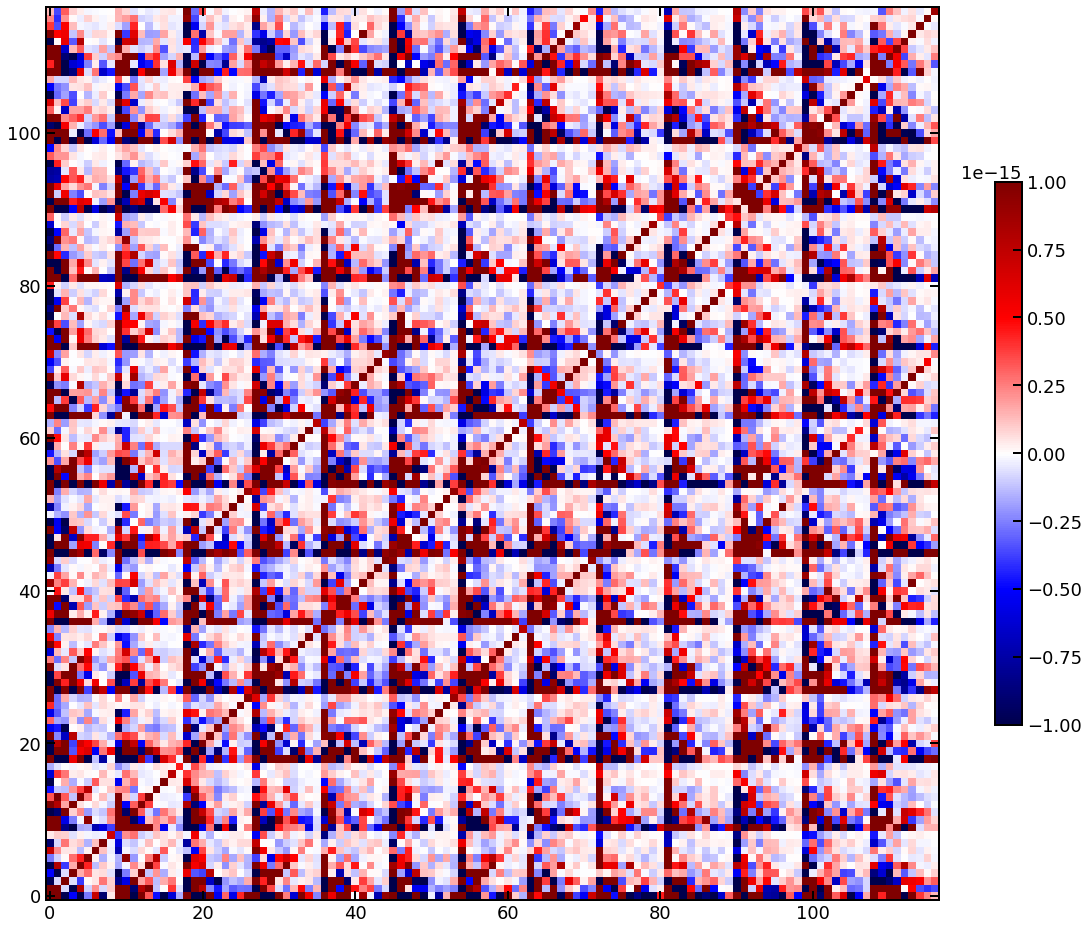

In [9]:
plt.figure(figsize=(20, 20))
plt.imshow(covmax, origin='lower', cmap=plt.cm.seismic, vmin=-1.0e-15, vmax=1.0e-15)
plt.colorbar(shrink=0.5)

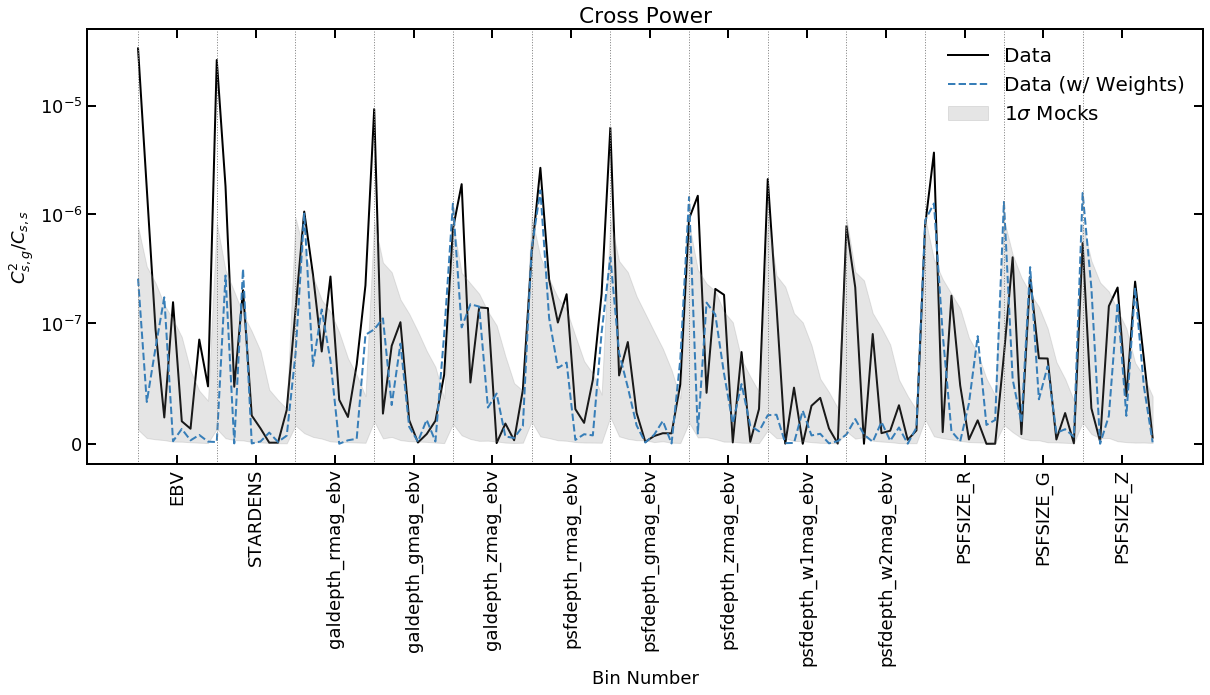

In [140]:
plt.figure(figsize=(20, 8))

plt.plot(err_0, color='C0', label='Data', lw=2, zorder=-1)
plt.plot(err_1, color='C1', ls='--', label='Data (w/ Weights)', lw=2)#, marker='o', mfc='w')
plt.fill_between(np.arange(err_min.size), err_min, err_max, color='grey', alpha=0.2, 
                label=r'$1\sigma$ Mocks')

plt.xlabel('Bin Number')
plt.ylabel(r'$C^2_{s,g}/C_{s,s}$')
plt.title('Cross Power')
plt.legend(fontsize=20)

binw = err_0.size / 13
_=plt.xticks([(i+0.5)*binw for i in range(13)], labels=maps_dr9, rotation=90)
for i in range(13):
    plt.axvline(i*binw, ls=':', color='grey', lw=1)
# plt.ylim(-0.02, 0.02)
plt.yscale('symlog', linthreshy=1.0e-7)
# plt.yscale('log')#, linthreshy=1.0e-6)

region: bmzls
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

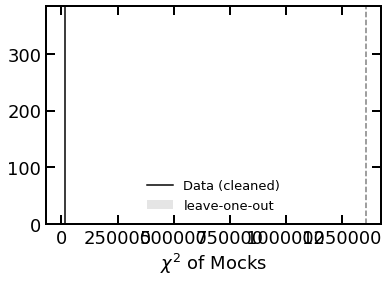

In [4]:
make_chi2plot('bmzls')

## Redshift Distribution

Text(0.5, 0, 'redshift')

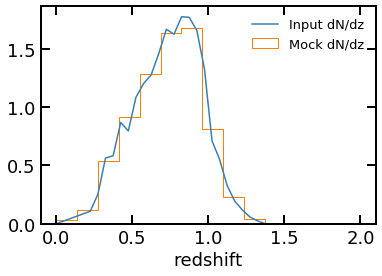

In [5]:
input_nz = np.loadtxt('/home/mehdi/github/flask/data/desi-z-selection-f1.dat')
catalog = ft.read('/home/mehdi/data/lognormal/lrg-cat-100.fits')
np.diff(input_nz[:, 0])

plt.plot(input_nz[:, 0], input_nz[:, 1]/(input_nz[:, 1].sum()*0.05), label='Input dN/dz')
plt.hist(catalog['z'], histtype='step', density=True, label='Mock dN/dz')

plt.legend()
plt.xlabel('redshift')

In [3]:
den_field = hp.read_map('/home/mehdi/data/lognormal/v0/lrg-88-f1z1.fits', verbose=False)

nside = 256


# nbar_sqdeg = 800. # per sq. deg
# nbar_sr = nbar_sqdeg * (180./np.pi)**(2)
# noise = 1./nbar_sr
# noise

den_contrast = den_field/den_field.mean() - 1.0
cl_obs = hp.anafast(den_contrast)
noise = hp.nside2pixarea(nside)/den_field.mean()
noise

5.247718593589074e-07

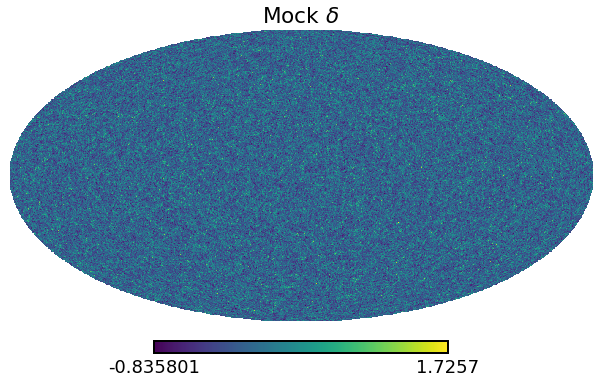

In [5]:
hp.mollview(den_contrast, title=r'Mock $\delta$')

Text(0.5, 0, 'Mock $\\delta$')

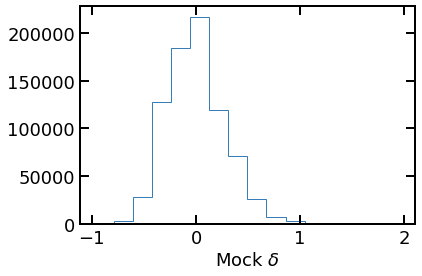

In [4]:
_ = plt.hist(den_contrast, histtype='step', bins=16)
plt.xlabel(r'Mock $\delta$')

## Power Spectra

In [3]:
cl_dr9 = np.load('/home/mehdi/data/rongpu/imaging_sys/clustering/v2/cl_lrg_bmzls_256_nn.npy', 
                allow_pickle=True).item()
cl_dr9n = np.load('/home/mehdi/data/rongpu/imaging_sys/clustering/v2/cl_lrg_bmzls_256_noweight.npy', 
                allow_pickle=True).item()
cl_model = np.loadtxt('/home/mehdi/github/flask/data/desiCl-f1z1f1z1.dat')

list_clmocks = glob('/home/mehdi/data/lognormal/v0/clustering/clmock_*_lrg_bmzls_256_noweight.npy')
print(len(list_clmocks))

cl_mocks = []

for fl in list_clmocks:
    cl_i = np.load(fl, allow_pickle=True).item()
    cl_mocks.append(cl_i['cl_gg']['cl'])
    print('.', end='')
    
cl_min, cl_max = np.percentile(cl_mocks, [15, 85], axis=0)
cl_mocks_mean = np.mean(cl_mocks, axis=0)

1000
...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [4]:
# mask

dt = ft.read('/home/mehdi/data/rongpu/imaging_sys/tables/nlrg_features_bmzls_256.fits')
mask_ = make_hp(256, dt['hpix'], 1.0) > 0.5
mask = hp.ud_grade(mask_, 1024)
weight = mask * 1.0

noise = 5.247718593589074e-07
el_m = np.arange(2*1024)
wd = WindowSHT(weight, mask, el_m, ngauss=2*1024)
cl_model_noise = cl_model[:, 1]+noise
cl_model_wind_noise = wd.convolve(cl_model[:, 0], cl_model[:, 1])+noise

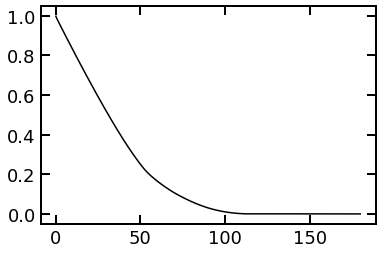

In [5]:
plt.plot(np.arccos(wd.x)*180./np.pi, wd.xi_mask)
# plt.xscale('log')
# plt.yscale('log')

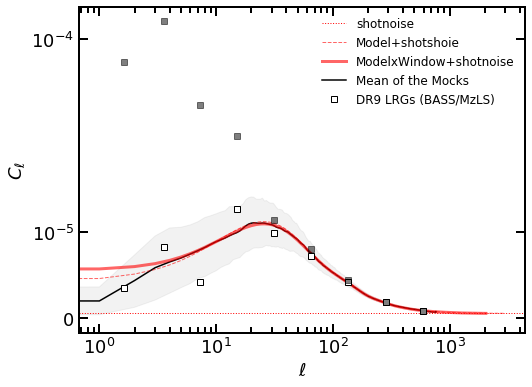

In [22]:
plt.figure(figsize=(8, 6))

# model
plt.axhline(noise, color='r', ls=':', lw=1, label='shotnoise')
plt.plot(cl_model_noise, 'r--', lw=1, alpha=0.6, label='Model+shotshoie')
plt.plot(cl_model_wind_noise, 'r-', lw=3, alpha=0.6, label='ModelxWindow+shotnoise')

# mocks
plt.plot(cl_mocks_mean, color='k', label='Mean of the Mocks', zorder=-1)
# for cl_mock_i in cl_mocks:
#     plt.plot(cl_mock_i, color='grey', lw=1, ls='-', alpha=0.02, zorder=-10)
plt.fill_between(np.arange(cl_min.size), cl_min, cl_max, alpha=0.1, color='grey', zorder=-10)


# data
plt.plot(*histogram_cell(cl_dr9['cl_gg']['cl'], bins=np.logspace(0, np.log10(769), 10)),
            marker='s', mfc='w', ls='None',
            color='k', label='DR9 LRGs (BASS/MzLS)')
plt.plot(*histogram_cell(cl_dr9n['cl_gg']['cl'], bins=np.logspace(0, np.log10(769), 10)),
            marker='s', color='k', alpha=0.5, ls='None')


plt.legend(fontsize=12) #, bbox_to_anchor=(1., 1.2))
# plt.ylim(1.0e-8, 1.0e-4)
plt.yscale('symlog', linthreshy=2.0e-5)
# plt.yticks([i*2.0e-6 for i in range(8)], labels=[f'{2*i}' for i in range(8)])
plt.ylabel(r'$C_{\ell}$')
plt.xlabel(r'$\ell$')
plt.xscale('log')

In [6]:
lbins = np.arange(1, 769, 50)
l_obs, cl_obs = histogram_cell(cl_dr9['cl_gg']['cl'], bins=lbins)


cl_mb = []

for cl_i in cl_mocks:
    cl_ib = histogram_cell(cl_i, bins=lbins)[1] 
    cl_mb.append(cl_ib)

clb_min, clb_max = np.percentile(cl_mb, [15, 85], axis=0)
clb_mean = np.mean(cl_mb, axis=0)

clb_model = histogram_cell(cl_model_wind_noise, bins=lbins)[1]

(0.5, 1.5)

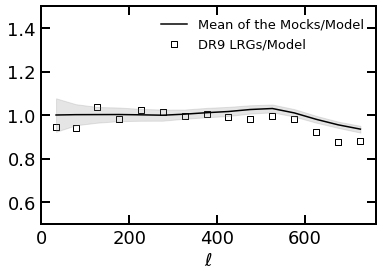

In [8]:
plt.scatter(l_obs, cl_obs/clb_model, marker='s', facecolor='w', 
            color='k', label='DR9 LRGs/Model')
plt.plot(l_obs, clb_mean/clb_model, color='k', label='Mean of the Mocks/Model')

plt.fill_between(l_obs, clb_min/clb_model, clb_max/clb_model, alpha=0.2, color='grey')

plt.legend()
plt.xlabel(r'$\ell$')
plt.ylim(0.5, 1.5)

In [58]:
lbins = np.arange(200, 601, 50)
l_obs, cl_obs = histogram_cell(cl_dr9['cl_gg']['cl'], bins=lbins)


cl_mb = []

for cl_i in cl_mocks:
    cl_ib = histogram_cell(cl_i, bins=lbins)[1] 
    cl_mb.append(cl_ib)

clb_mean = np.mean(cl_mb, axis=0)
clb_model = histogram_cell(cl_model_wind_noise, bins=lbins)[1]

clcov = np.cov(cl_mb, rowvar=False)
invcov = np.linalg.inv(clcov)

In [59]:
chi2_fn(cl_obs-clb_mean, invcov)

14.923096395131921

In [66]:
alphas = []
chi2_list = []
for beta in np.linspace(-0.06, 0.025):
    alpha = 1.0+beta
    alphas.append(alpha)
    chi2_list.append(chi2_fn(cl_obs-alpha*clb_mean, invcov))

In [68]:
invcov.shape

(8, 8)

Text(0, 0.5, '$\\chi^{2}$')

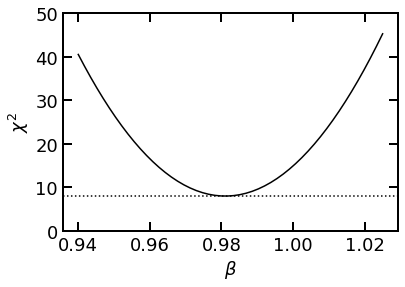

In [70]:
plt.plot(alphas, chi2_list)
plt.axhline(8.0, ls=':')
plt.ylim(0, 50)
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\chi^{2}$')

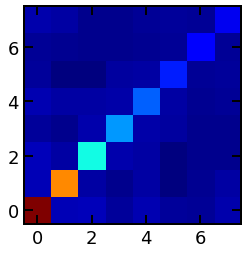

In [42]:
# chi-2
vmin, vmax = np.percentile(clcov, [1, 99])
plt.imshow(clcov, origin='lower', cmap=plt.cm.jet, vmin=vmin, vmax=vmax)

## Mean Density

In [3]:
def make_chi2plot(region):
    
    print(f'region: {region}')

    list_nbars = glob(f'/home/mehdi/data/lognormal/v0/clustering/nbarmock_*_lrg_{region}_256_noweight.npy')
    
    err_mat = read_nbmocks(list_nbars)
    err_0 = read_nnbar(f'/home/mehdi/data/rongpu/imaging_sys/clustering/v2/nbar_lrg_{region}_256_noweight.npy')
    err_1 = read_nnbar(f'/home/mehdi/data/rongpu/imaging_sys/clustering/v2/nbar_lrg_{region}_256_nn.npy')
    err_2 = read_nnbar(f'/home/mehdi/data/rongpu/imaging_sys/clustering/v2/nbar_lrg_{region}_256_nn.npy')

    
    print('# mocks', len(list_nbars))
    invcov, covmax = get_inv(err_mat, True)
    
    chi2_mocks = get_chi2pdf(err_mat)
    chi2_before = chi2_fn(err_0, invcov)
    chi2_after = chi2_fn(err_1, invcov)
    
    print(chi2_before, chi2_after)
    plt.hist(chi2_mocks, alpha=0.1, label='leave-one-out')
    plt.axvline(chi2_before, alpha=0.5, ls='--')
    plt.axvline(chi2_after, label='Data (cleaned)')
    plt.legend()
    plt.xlabel(r'$\chi^{2}$ of Mocks')
    plt.show()
    

#     fg, ax = plt.subplots(ncols=3, figsize=(12, 6), sharey=True)
#     fg.subplots_adjust(wspace=0.05, hspace=0.0)

#     map0 = ax[0].imshow(covmax, origin='lower', cmap=plt.cm.bwr, vmin=-2.0e-5, vmax=2.0e-5)
#     fg.colorbar(map0, ax=ax[0], orientation='horizontal', ticks=[-1.0e-5, 0, 1.0e-5], shrink=0.5)

#     map1 = ax[1].imshow(invcov, origin='lower', cmap=plt.cm.bwr, vmin=-2.0e6, vmax=2.0e6,)
#     fg.colorbar(map1, ax=ax[1], orientation='horizontal', shrink=0.5, ticks=[-1.0e6, 0, 1.0e6])


#     map2 = ax[2].imshow(covmax.dot(invcov), origin='lower', cmap=plt.cm.viridis, vmin=0, vmax=2.0)
#     fg.colorbar(map2, ax=ax[2], orientation='horizontal', ticks=[0., 1, 2.0], shrink=0.5)
#     plt.show()

region: bmzls
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

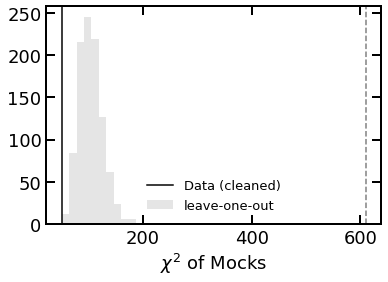

In [4]:
make_chi2plot('bmzls')

region: bmzls
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

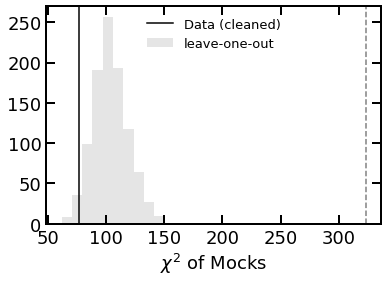

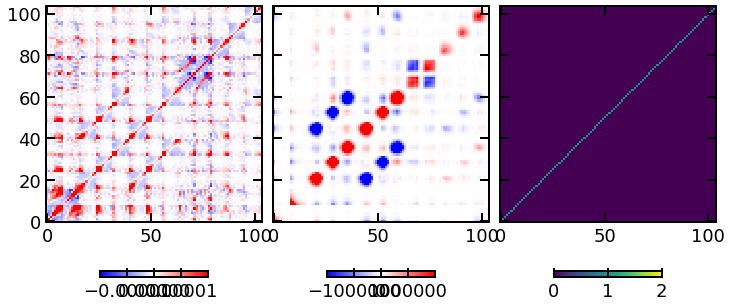

In [13]:
make_chi2plot('bmzls')

region: ndecals
........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

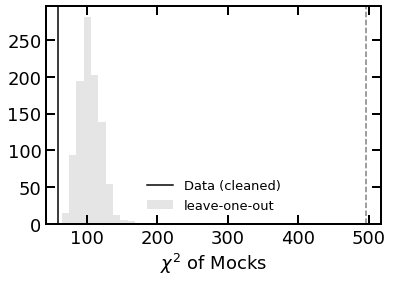

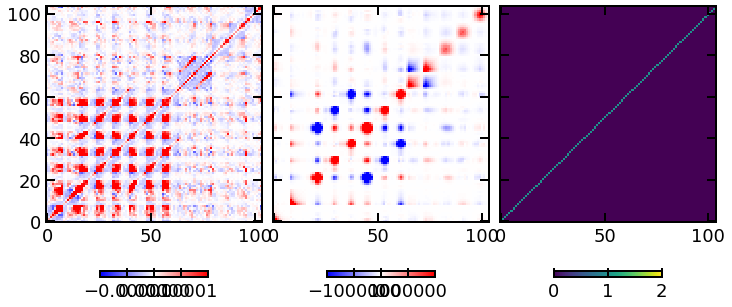

In [14]:
make_chi2plot('ndecals')

region: sdecals
........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

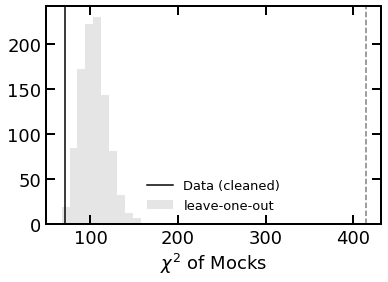

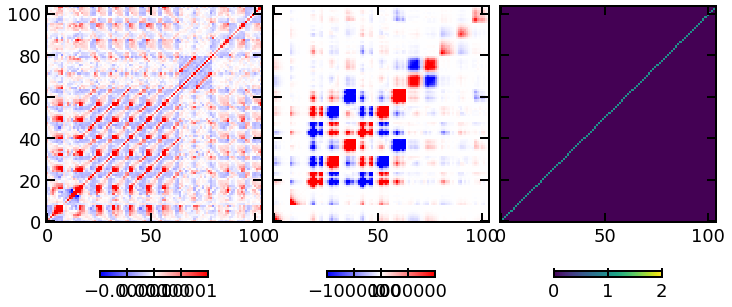

In [15]:
make_chi2plot('sdecals')

In [16]:
region = 'bmzls'
print(f'region: {region}')

list_nbars = glob(f'/home/mehdi/data/lognormal/v0/clustering/nbarmock_*_lrg_{region}_256_noweight.npy')
err_mat = read_nbmocks(list_nbars)
err_0 = read_nnbar(f'/home/mehdi/data/rongpu/imaging_sys/clustering/v2/nbar_lrg_{region}_256_noweight.npy')
err_1 = read_nnbar(f'/home/mehdi/data/rongpu/imaging_sys/clustering/v2/nbar_lrg_{region}_256_nn.npy')

print('# mocks', len(list_nbars))
invcov, covmax = get_inv(err_mat, True)

region: bmzls
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [18]:
err_min, err_max = np.percentile(err_mat, [15, 85], axis=0)

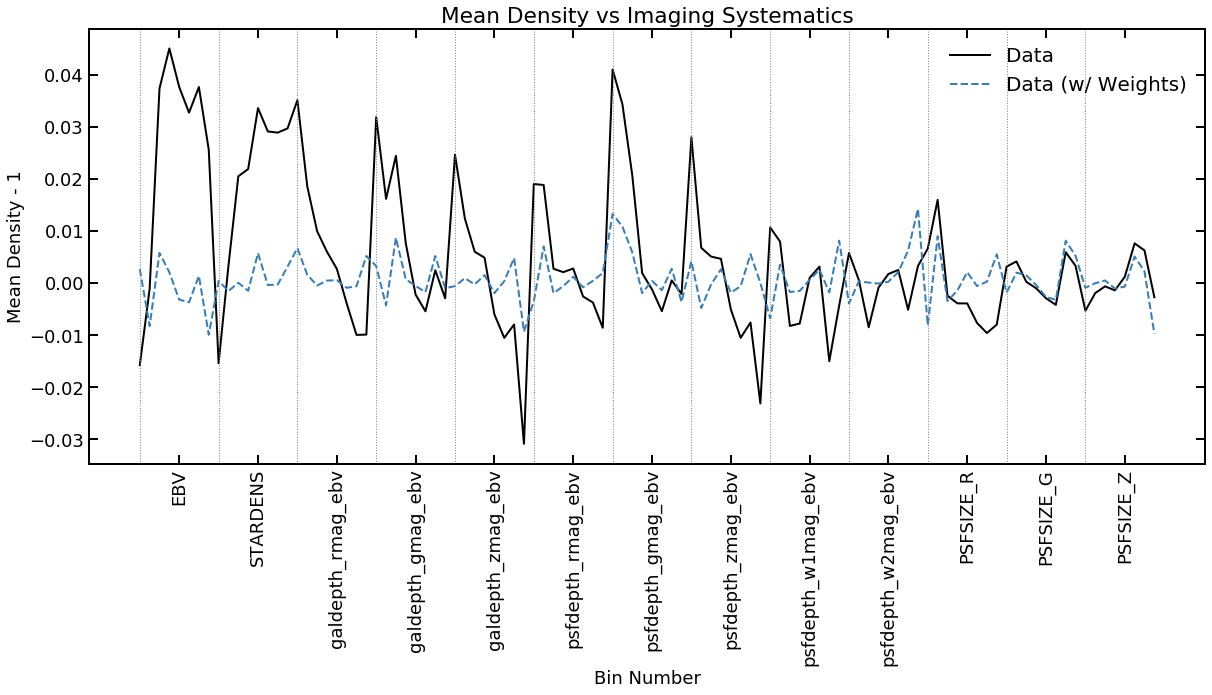

In [19]:
plt.figure(figsize=(20, 8))
plt.plot(err_0, color='C0', label='Data', lw=2, zorder=-1)
plt.plot(err_1, color='C1', ls='--', label='Data (w/ Weights)', lw=2)

#for err_mi in err_mat:
#    plt.plot(err_mi, color='C1', alpha=0.1, zorder=-2)
# plt.fill_between(np.arange(err_min.size), err_min, err_max, color='C1', alpha=0.2)

plt.xlabel('Bin Number')
plt.ylabel('Mean Density - 1')
plt.title('Mean Density vs Imaging Systematics')
plt.legend(fontsize=20)
_=plt.xticks([i*8+4 for i in range(13)], labels=maps_dr9, rotation=90)
for i in range(13):
    plt.axvline(i*8, ls=':', color='grey', lw=1)
# plt.ylim(-0.02, 0.02)

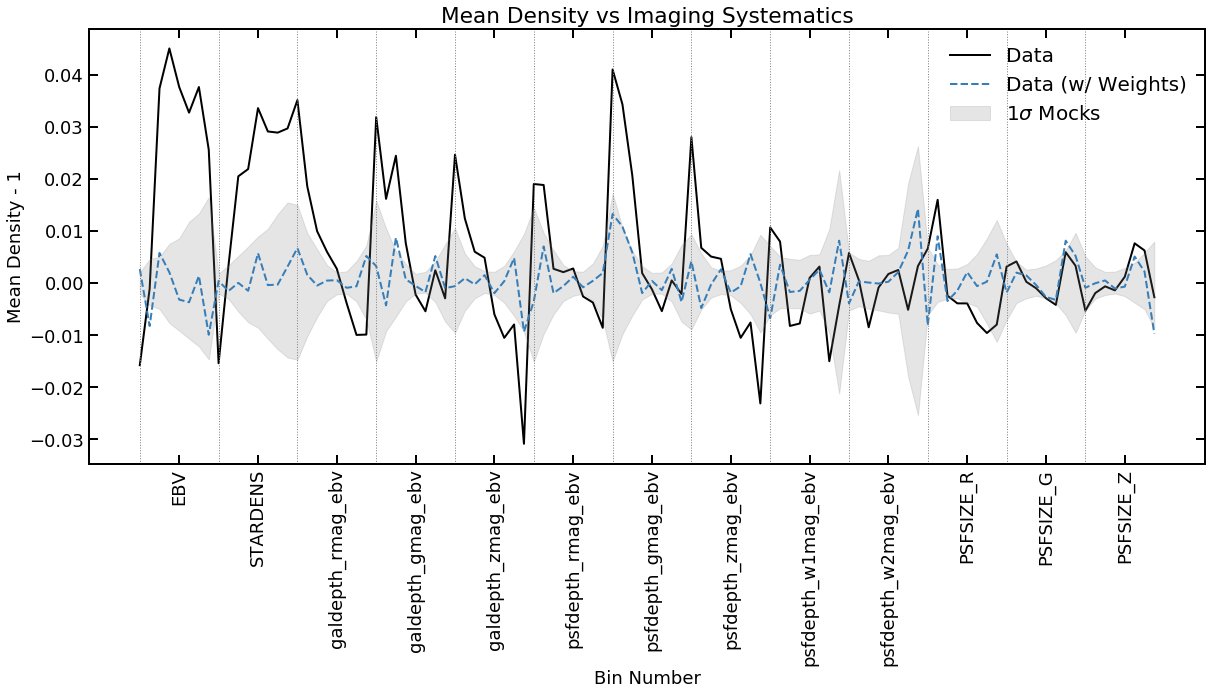

In [22]:
plt.figure(figsize=(20, 8))
plt.plot(err_0, color='C0', label='Data', lw=2, zorder=-1)
plt.plot(err_1, color='C1', ls='--', label='Data (w/ Weights)', lw=2)

#for err_mi in err_mat:
#    plt.plot(err_mi, color='C1', alpha=0.1, zorder=-2)
plt.fill_between(np.arange(err_min.size), err_min, err_max, color='grey', alpha=0.2, 
                label=r'$1\sigma$ Mocks')

plt.xlabel('Bin Number')
plt.ylabel('Mean Density - 1')
plt.title('Mean Density vs Imaging Systematics')
plt.legend(fontsize=20)
_=plt.xticks([i*8+4 for i in range(13)], labels=maps_dr9, rotation=90)
for i in range(13):
    plt.axvline(i*8, ls=':', color='grey', lw=1)
# plt.ylim(-0.02, 0.02)

In [92]:
err_scale = err_mat - err_mat.mean(axis=0)

In [95]:
covs = np.cov(err_scale, rowvar=False)

In [96]:
invcovs = np.linalg.inv(covs)

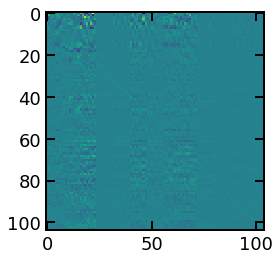

In [98]:
plt.imshow(covs.dot(invcovs))

In [36]:
d0 = np.load(list_nbars[0], allow_pickle=True)
d1 = np.load(list_nbars[10], allow_pickle=True)

In [37]:
d0[0]

{'nnbar': array([0.99585615, 1.00197567, 0.99586151, 1.00315507, 1.00664504,
        0.9914709 , 1.00287094, 1.00216488]),
 'area': array([12222., 12222., 12222., 12222., 12222., 12222., 12222., 12221.]),
 'nnbar_err': array([0.00296832, 0.00223668, 0.00280899, 0.00262396, 0.00251104,
        0.00167031, 0.00294963, 0.00239442]),
 'bin_edges': array([0.00367896, 0.01166427, 0.01457686, 0.01783316, 0.02281092,
        0.03234769, 0.04577622, 0.06690618, 0.41883251]),
 'bin_avg': array([0.00951587, 0.01314601, 0.01615297, 0.02008719, 0.02713269,
        0.03881256, 0.05500321, 0.10328343]),
 'attr': {'njack': 20, 'nbar': 30.524377397085143, 'npix2area': 1.0},
 'sys': 'EBV'}

In [38]:
d1[0]

{'nnbar': array([0.99679299, 1.00678415, 0.99902492, 0.99694914, 1.00104684,
        1.00213992, 0.9989253 , 0.9983366 ]),
 'area': array([12222., 12222., 12222., 12222., 12222., 12222., 12222., 12221.]),
 'nnbar_err': array([0.00309704, 0.00221506, 0.00235517, 0.00261592, 0.00255848,
        0.00312274, 0.002693  , 0.00330425]),
 'bin_edges': array([0.00367896, 0.01166427, 0.01457686, 0.01783316, 0.02281092,
        0.03234769, 0.04577622, 0.06690618, 0.41883251]),
 'bin_avg': array([0.00951587, 0.01314601, 0.01615297, 0.02008719, 0.02713269,
        0.03881256, 0.05500321, 0.10328343]),
 'attr': {'njack': 20, 'nbar': 30.390130401431858, 'npix2area': 1.0},
 'sys': 'EBV'}

In [100]:
dd = np.load('/home/mehdi/data/rongpu/imaging_sys/clustering/v2/nbar_lrg_bmzls_256_nn.npy', allow_pickle=True)
dd[0]

{'nnbar': array([0.99375002, 1.00171952, 1.00407873, 1.00527443, 0.99580699,
        0.9939571 , 1.00634445, 0.99906858]),
 'area': array([12221.93515835, 12222.77626307, 12222.22381377, 12221.98880691,
        12222.91208552, 12222.19999904, 12222.26856452, 12218.69530881]),
 'nnbar_err': array([0.00400074, 0.0025467 , 0.00222308, 0.00226435, 0.00331056,
        0.00136965, 0.00253457, 0.00172797]),
 'bin_edges': array([0.00367896, 0.01155863, 0.01439689, 0.01749723, 0.02209954,
        0.03091424, 0.04398893, 0.06449677, 0.41883251]),
 'bin_avg': array([0.00943713, 0.01300348, 0.01589296, 0.01956954, 0.0260189 ,
        0.03723095, 0.05299107, 0.0991519 ]),
 'attr': {'njack': 20,
  'nbar': 1.0003323740528882,
  'npix2area': 1.0982169373903181},
 'sys': 'EBV'}

In [33]:
maps_dr9 = ['EBV', 'STARDENS']\
          + [f'galdepth_{b}mag_ebv' for b in ['r', 'g', 'z']]\
          + [f'psfdepth_{b}mag_ebv' for b in ['r', 'g', 'z', 'w1', 'w2']] \
          + [f'PSFSIZE_{b}' for b in ['R', 'G', 'Z']]
for i, mapi in enumerate(maps_dr9):
    print(i, mapi)

0 EBV
1 STARDENS
2 galdepth_rmag_ebv
3 galdepth_gmag_ebv
4 galdepth_zmag_ebv
5 psfdepth_rmag_ebv
6 psfdepth_gmag_ebv
7 psfdepth_zmag_ebv
8 psfdepth_w1mag_ebv
9 psfdepth_w2mag_ebv
10 PSFSIZE_R
11 PSFSIZE_G
12 PSFSIZE_Z


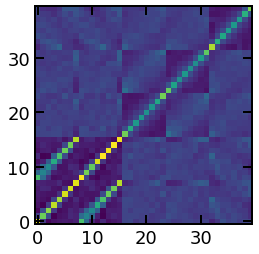

In [27]:
plt.imshow(covmax[8*8:,8*8:], origin='lower')

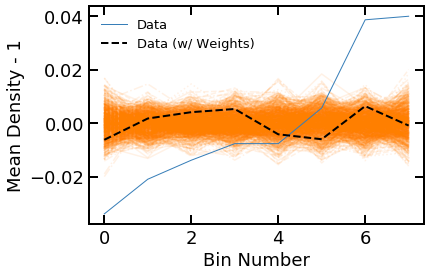

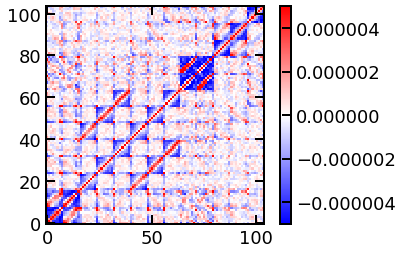

In [7]:
plt.imshow(errcov*hartlapf, origin='lower', 
           cmap=plt.cm.bwr, vmin=-5.0e-6, vmax=5.0e-6)
plt.colorbar()

8.0

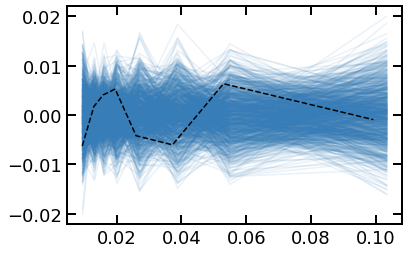

In [101]:
for nbar_i in list_nbars:
    d_i = np.load(nbar_i, allow_pickle=True)[0]
    
    plt.plot(d_i['bin_avg'], d_i['nnbar']-1, ls='-', color='C0', alpha=0.1)    
    
plt.plot(dd[0]['bin_avg'], dd[0]['nnbar']-1, 'k--')

## Mean Density of Mocks

In [42]:
def read_nbar(filename):
    # read nbar file
    d = np.load(filename, allow_pickle=True)

    bins = []
    nbar = []
    for d_i in d:
        bins.append(d_i['bin_edges'])
        nbar.append(d_i['nnbar'])

    return np.concatenate(bins), np.concatenate(nbar)


def get_nbars(r):

    nnbar_list = glob(f'/fs/ess/PHS0336/data/lognormal/v0/clustering/nbarmock_*_lrg_{r}_256_noweight.npy')
    print(r, len(nnbar_list))
    bins, nbar_0 = read_nbar(nnbar_list[0])
    nbar_mat = []
    for nbar_i in nnbar_list:

        bins_i, nbar_i = read_nbar(nbar_i)
        assert np.array_equiv(bins_i, bins)

        nbar_mat.append(nbar_i)
        print('.', end='')


    cov = np.cov(nbar_mat, rowvar=False)    

    return (bins, cov)

In [43]:

covs = {}
for r in ['bmzls', 'ndecals', 'sdecals']:
    covs[r] = get_nbars(r)

bmzls 1000
.............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

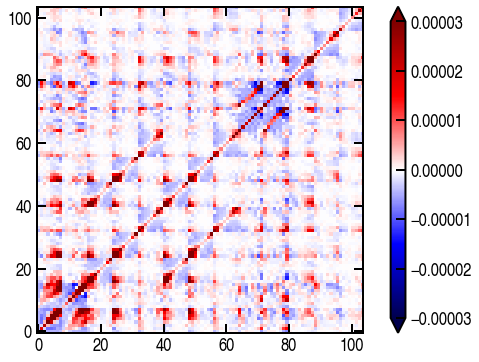

In [45]:
plt.figure(figsize=(10, 6))
plt.imshow(covs['bmzls'][1], 
           origin='lower', cmap='seismic', vmin=-3.0e-5, vmax=3.0e-5)
plt.colorbar(extend='both')

In [46]:
np.savez('/fs/ess/PHS0336/data/lognormal/v0/clustering/cov_nbarmocks_nside256.npz', **covs)

In [47]:
covs['bmzls'][0].size

117

In [49]:
covs['bmzls'][1].shape

(104, 104)

In [17]:
np.concatenate(bins).size

117

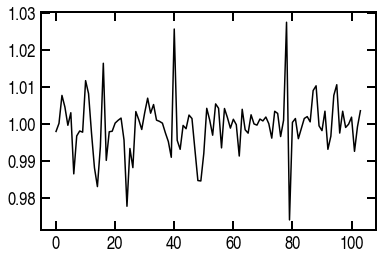

In [12]:
plt.plot(np.concatenate(nbar))

In [ ]:
#---- Next

# create ensemble of full sky log-normal mocks
# check if the observed data cell agrees with the mock dispersion on high-ell (ell > 20)?
# split into BASS / DECaLS North / DECaLS South
# measure C_ell, mean density, etc 
# construct covariance matrices
# test for remaining systematics,
# create non-zero fNL mocks, something close to yield the observed C_ell after mitigation


# keep in mind
# look at the nbar after the mitigation
# make sure high ell of the data matches that of the input model to FLASK
# adjust the maximum volume density